SMA, EMA, MACD, Kalman, Fourier, Wavelet, STL on ARIMA, LSTM, CNN, RNN on different datasets

[Source](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

[Source2](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

[Source3](https://medium.com/@wl8380/mastering-day-trading-with-lstm-predicting-the-next-10-minutes-4e03f89fef3f)

[Optuna](https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html), [Link2](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc), [Link3](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc)

[Tensorflow example](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-output_models)

#### Import Libraries

In [1]:
# def import_libraries():
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Attention, Add, LayerNormalization, Layer, SimpleRNN
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
# import keras_tuner as kt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cb
from pykalman import KalmanFilter

from scipy.fft import fft,ifft
from scipy.signal import morlet, cwt
import pywt

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error   
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU

2025-01-08 12:36:23.743621: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 12:36:23.774808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 12:36:23.774838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 12:36:23.775629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 12:36:23.780788: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import pickle

#### Fetch data

In [3]:
def fetch_stock_data(ticker):
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = ticker
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    # tesla = yf.download(ticker, start=start_date, end=end_date)
    ticker = yf.Ticker(ticker)
    stock_data = ticker.history(period="max",interval="1d")
    # tesla.head(4)
    # Return a DataFrame with the adjusted close prices
    # stock_data = tesla[['Adj Close']].rename(columns={"Adj Close": "adjClose"})
    # stock_data.index.name = "date"
    return stock_data
# Fetch Tesla stock data
# stock_data = fetch_tesla_stock_data()

# Display the first few rows of data
# print(stock_data.head(10))

#### Filtering functions

##### Comparison plot of Actual(TEST), kalman, fourier, SMA, EMA, MACD, Wavelet

In [4]:
def plot_comparison(actual_test,pred_test, kalman=None, fourier=None, sma=None, ema=None, macd=None, wavelet=None):
# plot dataframe line chart
    global scaler, stock_data
    plt.figure(figsize=(10, 6))
    # Inverse scale the actual stock prices
    y_raw = scaler.inverse_transform(actual_test.reshape(-1, 1))
    s = stock_data.index[-len(y_raw):]
    plt.plot(s,y_raw,'black' ,label='Actual')
    plt.plot(s,pred_test,'orange' ,label='Predicted')
    if kalman is not None:
        #read csv file into dataframe
        kalman_df_pred = pd.read_csv(f'predicted_stock_price_kalman.csv',index=False)
        plt.plot(s,kalman_df_pred['kalman_pred'], 'red',label='Kalman')
    if fourier is not None:
        fourier_df_Pred = pd.read_csv(f'predicted_stock_price_fourier.csv',index=False)
        plt.plot(s,fourier_df_Pred['fourier_pred'],'green',label='Fourier')
    if sma is not None:
        sma_df_pred = pd.read_csv(f'predicted_stock_price_SMA.csv',index=False)
        plt.plot(s,sma_df_pred['sma_pred'],'yellow', label='SMA')
    if ema is not None:
        ema_df_pred = pd.read_csv(f'predicted_stock_price_EMA.csv',index=False)
        plt.plot(s,ema_df_pred['ema_pred'],'lightblue' ,label='EMA')
    if macd is not None:
        macd_df_pred = pd.read_csv(f'predicted_stock_price_MACD.csv',index=False)
        plt.plot(s,macd_df_pred['macd_pred'],'magenta' ,label='MACD')
    if wavelet is not None:
        wavelet_df_pred = pd.read_csv(f'predicted_stock_price_wavelet.csv',index=False)
        plt.plot(s,wavelet_df_pred['wavelet_pred'], 'cyan',label='Wavelet')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')           
    plt.ylabel('Value')
    plt.legend()
    plt.show()


##### Kalman

In [5]:
def kalman_filtering(org_data):
    kf = KalmanFilter(transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.0001)

    mean, cov = kf.filter(org_data.values)
    mean = pd.Series(mean.flatten(), index=org_data.index)

    # Apply the smoother to the observations
    smoothed_state_means, smoothed_state_covariances = kf.smooth(org_data.values)
    s_mean = pd.Series(smoothed_state_means.flatten(), index=org_data.index)

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,org_data.values - mean, 'red', lw=1.5,label='kalman filtered')
    plt.plot(org_data.index,org_data.values - s_mean, 'yellow', lw=1.5,label='Kalman smoothed')
    plt.title(f"{filter} -Kalman filtered price fluctuation")
    plt.ylabel("Deviation from the mean ($)")
    plt.xlabel("Years")
    plt.legend()
    #convert to dataframe
    kalman_df = pd.DataFrame({'filtered': org_data.values - mean, 'kal_smoothed':org_data.values - s_mean})    
    return kalman_df

##### Fourier

In [6]:
def fourier_transform(org_data):
    global frequencies,fourier_reconstructed_signal,fft_values
    # calcualte the fourier transform
    fft_values = np.fft.fft(org_data)

    # plot the original signal
    plt.figure(figsize=(20,11))
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, org_data)
    plt.title(f'{filter} -Original Signal (Time Domain)')
    plt.xlabel('Time [s]')
    plt.ylabel('Price')

    # plot the fourier transform of the simulated sequence
    frequencies = np.fft.fftfreq(len(stock_data.index), d=1)
    print("freq-",frequencies)
    print("amp-",np.abs(fft_values))
    plt.subplot(3, 1, 2)
    plt.plot(frequencies, np.abs(fft_values))
    plt.title(f'{filter} -Fourier Transform (Frequency Domain)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    

    # Step 2: Filter High Frequencies (Denoising) 
    threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
    # Filter threshold: keep only low frequencies 
    fft_filtered = np.copy(fft_values) 
    fft_filtered[np.abs(frequencies) > threshold] = 0 # Zero out high frequencies 
    # Reconstruct the Signal (Inverse Fourier Transform) 
    fourier_reconstructed_signal = np.fft.ifft(fft_filtered).real
    
    # Plot Reconstructed Signal 
    plt.subplot(3, 1, 3)   
    plt.plot(stock_data.index, fourier_reconstructed_signal, label="Reconstructed Signal (Low Pass Filter)") 
    plt.xlabel("Time") 
    plt.ylabel("Price") 
    plt.title(f"{filter} -Denoised Time Series") 
    plt.legend() 
    plt.tight_layout()
    plt.show()

    fourier_df = pd.DataFrame({'filtered': fourier_reconstructed_signal}) 
    return fourier_df

In [7]:
#find the lowest positive value in an array frequencies
# def find_lowest_positive_value(frequencies):
#     return min([freq for freq in frequencies if freq > 0])
# find_lowest_positive_value(frequencies)

# Step 3: Identify Dominant Frequencies 
# dominant_freqs = frequencies[np.argsort(np.abs(fft_values))[-5:]]
# dominant_freqs
# dominant_amplitudes = np.abs(fft_values)[np.argsort(np.abs(fft_values))[-5:]] 
# dominant_amplitudes

In [8]:
# Step 4: Add Sinusoidal Features for Forecasting 
# sin_features = [np.sin(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# cos_features = [np.cos(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# seasonality_features = np.column_stack(sin_features + cos_features) 

# Combine Features with Original Signal 
# time_series_df = pd.DataFrame({ "Time": t, "Original_Signal": signal, "Denoised_Signal": reconstructed_signal }) 
# for i, freq in enumerate(dominant_freqs[dominant_freqs > 0]): 
#     time_series_df[f"Sin_{i}"] = np.sin(2 * np.pi * freq * t) 
#     time_series_df[f"Cos_{i}"] = np.cos(2 * np.pi * freq * t)

##### SMA

In [9]:
def SMA_transform(org_data):
    #transform close price to simple moving average
    sma_win = 20
    temp = org_data.rolling(window=sma_win,min_periods=1).mean()
    # print(temp)
    sma_df = pd.DataFrame(temp)
    #rename the column in sma_df   
    sma_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,sma_df.filtered, 'red', lw=1.5,label='SMA filtered')
    plt.title(f"{filter} -SMA filtered price fluctuation")
    plt.ylabel("SMA values")
    plt.xlabel("Years")
    plt.legend()

    return sma_df

##### EMA

In [10]:
def EMA_transform(org_data):
    #transform close price to simple moving average
    win = 20
    temp = org_data.ewm(span=win).mean()
    # print(temp)
    ema_df = pd.DataFrame(temp)
    #rename the column in sma_df
    ema_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,ema_df.filtered, 'red', lw=1.5,label='EMA filtered')
    plt.title(f"{filter} -EMA filtered price fluctuation")
    plt.ylabel("EMA values")
    plt.xlabel("Years")
    plt.legend()

    return ema_df

##### MACD

In [11]:
def MACD_transform(org_data):
    # Create MACD
    d_26ema = org_data.ewm(span=26).mean()
    d_12ema = org_data.ewm(span=12).mean()
    d_MACD = d_12ema-d_26ema
    macd_df = pd.DataFrame({'filtered': d_MACD})
    #rename the column in sma_df
    # macd_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,macd_df.filtered, 'red', lw=1.5,label='MACD filtered')
    plt.title(f"{filter} -MACD filtered price fluctuation")
    plt.ylabel("MACD values")
    plt.xlabel("Years")
    plt.legend()

    return macd_df
#calculate MACD

##### Wavelet

In [12]:
def wavelet_deconstruction_plot(data, wavelet_name):
    global details, approximation, wavelet
    # Step 1: Generate Synthetic Time Series Data 
    # np.random.seed(42) 
    # t = np.linspace(0, 10, 1024) 
    # Time vector (must be a power of 2 for DWT) 
    # signal = 5 * np.sin(2 * np.pi * 1 * t) + 2 * np.sin(2 * np.pi * 0.25 * t) + np.random.normal(0, 0.5, len(t)) 
    # Plot Original Signal 
    # plt.figure(figsize=(10, 4)) 
    # print('HEREEEEEEEEE')
    # plt.plot(data.index, data['Close'].values, label="Original Signal") 
    # plt.xlabel("Time") 
    # plt.ylabel("Close price") 
    # plt.title("Time Series Data") 
    # plt.legend() 
    # plt.show() 
    # Step 2: Perform Discrete Wavelet Transform (DWT) 
    wavelet = wavelet_name # 'db4' 
#Different wavelet families can be tested
    # Daubechies wavelet
    max_level = pywt.dwt_max_level(len(data['Close'].values), pywt.Wavelet(wavelet).dec_len) 
    # Max decomposition level 
    coeffs = pywt.wavedec(data['Close'].values, wavelet, level=max_level)

    # Perform wavelet decomposition 
    approximation = coeffs[0] 
    # Approximation coefficients (low-frequency) 
    details = coeffs[1:] 
    # Detail coefficients (high-frequency) 
    print("length of details-",len(details))
    # Step 3: Visualize Wavelet Decomposition 
    
    # plt.figure(figsize=(20, 15)) 
    # plt.subplot(len(details)+1, 1, 1) 
    # plt.plot(approximation, label="Approximation (Low Frequencies)") 
    # plt.title("Approximation Coefficients (A)") 
    # plt.legend() 
    # for i, detail in enumerate(details, 1): 
    #     plt.subplot(len(details)+1, 1, i + 1) 
    #     plt.plot(detail, label=f"Detail Coefficients (D{i})") 
    #     plt.title(f"Detail Coefficients (D{i})") 
    #     plt.legend() 
    # plt.tight_layout() 
    # plt.show() 

In [13]:
def wavelet_denoising(data,detail_index,approx_enable=True,threshold_enable=False,thresh_value=0):
    global details, approximation, wavelet,wavelet_df
    # Step 4: Reconstruct Signal (Inverse Wavelet Transform) 
    # Reconstruct only the approximation (low-frequency content) 
    # if not detail_index in range(len(details)):
    #     detail_index = 0
    #     print("Detail_index",detail_index)
    
    print("Threshold enabled-",threshold_enable)
    if not threshold_enable:
        if approx_enable:
            reconstructed_signal_low = pywt.waverec([approximation] + [np.zeros_like(d) for d in details], wavelet) 
            # Reconstruct signal with selective details (e.g., smooth trends + some details) 
        else:
        # Different details coefficients can be tested
            selective_coeffs = [approximation] + [details[i] if i == detail_index else np.zeros_like(d) for i, d in enumerate(details)] 
            reconstructed_signal_selective = pywt.waverec(selective_coeffs, wavelet) 

        # Plot Original vs Reconstructed Signal 

        plt.figure(figsize=(12, 6)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        if approx_enable:
            plt.plot(data.index[:len(reconstructed_signal_low)], reconstructed_signal_low[:-1], label="Low Frequencies (Approximation)", color='red') 
        else:
            plt.plot(data.index[:len(reconstructed_signal_selective)], reconstructed_signal_selective[:-1], label="Selective Reconstruction", color='green') 
        plt.xlabel("Time") 
        plt.ylabel("Close Price") 
        plt.title("Signal Reconstruction from Wavelet Coefficients") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        threshold = thresh_value
        # Adjust based on noise level 
        thresholded_details = [pywt.threshold(d, threshold, mode='soft') for d in details] 

        # Reconstruct the denoised signal 
        denoised_coeffs = [approximation] + thresholded_details 
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet) 

        # Plot Denoised Signal 
        plt.figure(figsize=(10, 4)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        plt.plot(data.index[:len(denoised_signal)], denoised_signal, label="Denoised Signal", color='orange') 
        plt.xlabel("Time") 
        plt.ylabel("Amplitude") 
        plt.title("Denoised Signal Using Wavelet Transform") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        wavelet_df = pd.DataFrame({'filtered': denoised_signal})
        #rename the column in sma_df
        # print(wavelet_df)
        return wavelet_df
    else:
        if approx_enable:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_low})
            # print(wavelet_df)
            return wavelet_df
        else:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_selective})
            # print(wavelet_df)
            return wavelet_df

In [14]:
def wavelet_transform(org_data,detail_index, wavelet_name,approx_enable=True,threshold_enable=False,thresh_value=0):
    wavelet_deconstruction_plot(org_data, wavelet_name)
    ret_df = wavelet_denoising(org_data,detail_index,approx_enable,threshold_enable,thresh_value)
    return ret_df

##### STL

In [15]:
def plot_components_STL(result,org):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [16]:
#Assuming period of 1 day
def stl_transform(stock_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    stl = STL(stock_data['Close'], period=period)
    result_stl = stl.fit()

    # Plot the results
    plot_components_STL(result_stl,stock_data)
    stl_df = pd.DataFrame({'filtered':result_stl.observed - result_stl.resid})
    return stl_df

##### MSTL

In [17]:
def plot_components(result,org):
  
  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

In [18]:
#code to calculate variance 
#High variance indicate the presence of noise
# def calculate_variance(data):
#     mean = sum(data) / len(data)
#     variance = sum((x - mean) ** 2 for x in data) / len(data)
#     return variance
                                                        

In [19]:
# from statsmodels.tsa.stattools import adfuller
# def Augmented_Dickey_Fuller_Test_func(series):
#     # print (f'Dickey-Fuller test results for columns: {column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     if dftest[1] <= 0.05:
#         print("Conclusion:====>")
#         print("Reject the null hypothesis")
#         print("The data is stationary")
#     else:
#         print("Conclusion:====>")
#         print("The null hypothesis cannot be rejected")
#         print("The data is not stationary")

In [20]:
# result_mstl.observed
# Augmented_Dickey_Fuller_Test_func(result_mstl.resid)
# calculate_variance(result_mstl.resid)

In [21]:
#Assuming period of 1 day
def mstl_transform(stock_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    mstl = MSTL(stock_data['Close'], periods=period)
    result_mstl = mstl.fit()

    # Plot the results
    plot_components(result_mstl,stock_data)
    mstl_df = pd.DataFrame({'filtered':result_mstl.observed - result_mstl.resid})
    return mstl_df

#### Create sequences

In [22]:
# def create_sequences(data, window_size, prediction_steps):
#     X = []
#     y = []
#     for i in range(window_size, len(data) - prediction_steps):
#         X.append(data[i-window_size:i, 0]) # input sequence
#         y.append(data[i, 0]) # target value (price at the next timestep)
#     return np.array(X), np.array(y)

def create_sequences(data, window_size, prediction_steps=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0]) # input sequence
        y.append(data[i + window_size, 0]) # target value (price at the next timestep)
    return np.array(X), np.array(y)

#### Model Definition

In [23]:
# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)
        a = tf.matmul(q, inputs, transpose_b=True)
        attention_weights = tf.nn.softmax(a, axis=-1)
        return tf.matmul(attention_weights, inputs)

# rnn model with attention and early stopping
def build_rnn_model_with_attention(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(SimpleRNN(units=u, return_sequences=True, input_shape=input_shape,activation=actv_name))
    model.add(Dropout(d))
    
    # Attention layer
    model.add(AttentionLayer())
    model.add(LayerNormalization())
    for i in range(no_of_layers):
        model.add(SimpleRNN(units=u, return_sequences=True,activation=actv_name))
        model.add(Dropout(d))
    model.add(SimpleRNN(units=u, return_sequences=False,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

# RNN model without attention and early stopping
def build_rnn_model(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    print(input_shape)
    model.add(SimpleRNN(units=u, return_sequences=True, input_shape=input_shape))#,activation=actv_name))
    model.add(Dropout(d))
    for i in range(no_of_layers):
        model.add(SimpleRNN(units=u, return_sequences=True))#,activation=actv_name))
        model.add(Dropout(d))
    # model.add(SimpleRNN(units=u, return_sequences=True))
    # model.add(Dropout(d))
    model.add(SimpleRNN(units=u, return_sequences=False))#,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

#### Build Model

In [24]:
def build_model(window_size,d,u,split_size,optimizer_option,num_of_layers,loss_options,actv_option):
    global scaler_X,scaler_Y,raw_data,scaled_data,attn,X_train, X_test, y_train, y_test,scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    X, y = create_sequences(raw_data, window_size)
    # Reshape input data to be in the shape [samples, time steps, features]
    # X = X.reshape(X.shape[0], X.shape[1], 1)
    # Split the data into training and testing sets
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=split_size, shuffle=False)
    # print(f"Training data shape: {X_train.shape}")
    # print(f"Testing data shape: {X_test.shape}")
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=False)
    print("unscaled X_train size",X_train.shape)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))
   
    scaled_train_X = scaler_X.fit_transform(X_train)
    scaled_val_X = scaler_X.transform(X_val)
    scaled_test_X = scaler_X.transform(X_test)

    scaled_train_Y = scaler_Y.fit_transform(y_train.reshape(-1,1)).flatten()
    scaled_val_Y = scaler_Y.transform(y_val.reshape(-1,1)).flatten()
    scaled_test_Y = scaler_Y.transform(y_test.reshape(-1,1)).flatten()

    scaled_train_X = scaled_train_X.reshape(scaled_train_X.shape[0], scaled_train_X.shape[1], 1)
    scaled_val_X = scaled_val_X.reshape(scaled_val_X.shape[0], scaled_val_X.shape[1], 1)
    scaled_test_X = scaled_test_X.reshape(scaled_test_X.shape[0], scaled_test_X.shape[1], 1)

    print("scaled X_train size",scaled_train_X.shape,scaled_train_Y.shape)
    if attn:
        model = build_rnn_model_with_attention(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
        # Implement EarlyStopping to prevent overfitting            
    else:
        # Build the RNN model
        model = build_rnn_model(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
    return model

#### Hyperparameter Optimization

In [25]:
def objective_rnn(trial):
    global  X_train,y_train,X_test,y_test,history, model, scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    win_size = trial.suggest_int('win_size', 10, 100,step=10, log=False)
    epoch_no = trial.suggest_int('epoch_no', 10, 100,step=10, log=False)
    split_size = trial.suggest_float('split_size', 0.2, 0.5,step=0.1,log=False)
    # attn = trial.suggest_categorical('attn', [True, False])
    units = trial.suggest_int('units', 30, 70,step=10,log=False)
    drop_out = trial.suggest_float('drop_out', 0.2, 0.5,step=0.1,log=False)
    optimizer_options = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    num_of_layers = trial.suggest_int('no_layers', 2, 9,step=2, log=False)
    loss_options = trial.suggest_categorical('loss_fn_name', ['mean_squared_error', 'mean_squared_logarithmic_error', 'huber_loss','log_cosh'])    
    activation_option = trial.suggest_categorical('activation_name', ['relu', 'gelu','selu'])
    
    model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_options,activation_option)
    # build_rnn_model(input_shape,u,d)
    # model.compile(optimizer='adam', loss='mean_squared_error')
    

    # Implement EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping and 50 epochs
    
    history = model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y),verbose=1, shuffle=False, callbacks=[early_stopping])
    loss = history.history['val_loss']
    print("loss value",loss)
    return min(loss)

#### Evaluate model

In [26]:
# Evaluate the model
def evaluate_model(model, x_data,y_data,filter):
    global predicted_stock_price,scaler_X,scaler_Y,mape, mae, rmse, r2,y_raw,predicted_stock_price_raw
    predicted_stock_price = model.predict(x_data)
    predicted_stock_price_raw = scaler_Y.inverse_transform(predicted_stock_price)

    # Inverse scale the actual stock prices
    y_raw = scaler_Y.inverse_transform(y_data.reshape(-1, 1))
    #save predicted value in a dataframe
    predicted_stock_price_raw = predicted_stock_price_raw.flatten()
    pred_df = pd.DataFrame({f"{filter}_pred":predicted_stock_price_raw})
    pred_df.to_csv(f'RNN_predicted_stock_price_{filter}.csv', index=False)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_raw, predicted_stock_price_raw)
    #calculate MAE, RMSE, R2
    mae = mean_absolute_error(y_raw, predicted_stock_price_raw)
    rmse = root_mean_squared_error(y_raw, predicted_stock_price_raw)
    r2 = r2_score(y_raw, predicted_stock_price_raw)
    #save 
    print(f"**********************{filter} filter***************************")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print mae, rmse and r2
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    # return mape, mae, rmse, r2
    # return rmse
    



#### Plot simple & interative graph

In [27]:
def plot_simple(df,split,title,ticker,y_actual, predicted_stock_price_raw,width=10,height=6):
    # Plot the results
    global window_size,y_train
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    #plot date in x axis
    plt.figure(figsize=(width,height))
 
    plt.figure(figsize=(width, height))    
    plt.plot(s,y_actual, label=f"Actual {ticker} Stock Price", color='blue')
    plt.plot(s,predicted_stock_price_raw, label=f"Predicted {ticker} Stock Price", color='red')
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Raw Stock Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_interative(df,split,title,tick,y_actual,y_pred):
    global y_train,window_size
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    fig = go.Figure(data=[
           go.Scatter(x=s, y=y_actual.flatten(), mode='lines', name='Actual'),
           go.Scatter(x=s, y=y_pred.flatten(), mode='lines', name='Predicted')])
    fig.update_layout(title=title+f'-{tick}', xaxis_title='Time', yaxis_title='Close price')
    fig.show()

#### Original data Scaled

In [28]:
def org_data_split(org_data,split_size,window_size):
    global Org_X_train,Org_y_train,Org_X_val,Org_y_val,Org_X_test,Org_y_test
    Org_X, Org_y = create_sequences(org_data, window_size)
    Org_X_train, Org_X_rest, Org_y_train, Org_y_rest = train_test_split(Org_X, Org_y, test_size=split_size, shuffle=False)
    Org_X_val, Org_X_test, Org_y_val, Org_y_test = train_test_split(Org_X_rest, Org_y_rest, test_size=0.5, shuffle=False)
    

#### Save model

In [29]:
#save tensorflow model  


#### Compile all functions

In [30]:
# def abc(tick,ws,ps,u,d,n_t,filter,epoch_no=70,batch_size_no=32,split_size=0.2,attn=False):
def abc(file_name,tick,n_t,filter,study_name,tuning,detail_index=0,wavelet_name="db4",approx_enable=True,threshold_enable=False,thresh_value=0,mstl_period=[7],stl_period=7):
    global model,study_rnn, window_size,stock_data, raw_data,scaler, scaled_data, X, y,X_train, X_test, y_train, y_test,history,model
    # import_libraries()

    
    # stock_data = fetch_stock_data(tick)
    if filter == 'hybrid':
        hybrid_df = pd.read_csv(file_name,index_col=0)
        stock_data = hybrid_df
    else:
        # stock_data = fetch_stock_data(tick)
        if os.path.isfile(file_name):
            print(f"The file '{file_name}' does exist.")
            stock_data = pd.read_csv(file_name, index_col=0)
                # print(content)    
        else:
            print(f"The file '{file_name}' does not exist.")
            stock_data = fetch_stock_data(tick)
            stock_data.to_csv(file_name,index=True)
   
    if filter=="kalman":
        filtered_df = kalman_filtering(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'fourier':
        filtered_df = fourier_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'SMA':
        filtered_df = SMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'EMA':
        filtered_df = EMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'MACD':
        filtered_df = MACD_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'wavelet':
        filtered_df = wavelet_transform(stock_data,detail_index, wavelet_name,approx_enable,threshold_enable,thresh_value) 
        print("Filter Name-",filter)
    elif filter == 'STL':
        filtered_df = stl_transform(stock_data,stl_period)
    elif filter == 'mstl':
        filtered_df = mstl_transform(stock_data,mstl_period)
    elif filter == 'hybrid':
        filtered_df = hybrid_df[['filtered_akam']].values
    else:
        pass

    # Fetch Tesla stock data
    # Define the window size and prediction time
    # window_size = ws
    # prediction_steps = ps
    if filter == 'na':
        raw_data = stock_data[['Close']].values
    elif filter == 'hybrid':
        raw_data = filtered_df
    else:
        raw_data = filtered_df[['filtered']].values
    # Normalize the data using MinMaxScaler
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(raw_data)
    
    
    # Create sequences for the model
    
    # build_model(window_size,d,u,attn,ps=10)
    # Run Hyperband tuning with Optuna for each model
    if tuning:
        study_rnn = optuna.create_study(direction="minimize",sampler=TPESampler(),study_name=f'{study_name}')#, pruner=optuna.pruners.HyperbandPruner())

        # Optimize each study
        study_rnn.optimize(objective_rnn, n_trials=n_t)

        best_trial = study_rnn.best_trial
        print(f'Best parameters: for {filter} filter', best_trial.params)
        print(f'Best value: for {filter} filter', best_trial.value)
        for key, value in best_trial.params.items():
            print("    {}: {}".format(key, value))
        return best_trial.params, best_trial.value

    # if attn:
    #     a = "attention"
    # else:
    #     a = ""
    # print("****************************TEST************************************")
    # evaluate_model(model, X_test,y_test)
    # plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

    # print("*****************************TRAIN***********************************")
    # evaluate_model(model, X_train,y_train)
    # plot_simple(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)    

#### MMM - Original

##### Start Tuning

First run

In [110]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=True
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

[I 2024-12-19 10:43:48,739] A new study created in memory with name: Original


The file 'MMM_data.csv' does exist.
unscaled X_train size (11073, 30)
scaled X_train size (11073, 30, 1) (11073,)
(30, 1)
Epoch 1/10


2024-12-19 10:43:54.176228: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 10:43:54.295599: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



347/347 [==============================] - 53s 137ms/step - loss: 0.3932 - val_loss: 0.2334
Epoch 2/10
347/347 [==============================] - 46s 134ms/step - loss: 0.2659 - val_loss: 0.2339
Epoch 3/10
347/347 [==============================] - 47s 134ms/step - loss: 0.2377 - val_loss: 0.2554
Epoch 4/10
347/347 [==============================] - 47s 135ms/step - loss: 0.2120 - val_loss: 0.2510
Epoch 5/10
347/347 [==============================] - 47s 134ms/step - loss: 0.1973 - val_loss: 0.2362
Epoch 6/10
347/347 [==============================] - 47s 135ms/step - loss: 0.1899 - val_loss: 0.2361
Epoch 7/10
347/347 [==============================] - 47s 134ms/step - loss: 0.1770 - val_loss: 0.2358
Epoch 8/10
347/347 [==============================] - 47s 135ms/step - loss: 0.1650 - val_loss: 0.2347
Epoch 9/10
347/347 [==============================] - 47s 135ms/step - loss: 0.1581 - val_loss: 0.2368
Epoch 10/10
347/347 [==============================] - 47s 135ms/step - loss: 0.1528

[I 2024-12-19 10:51:43,159] Trial 0 finished with value: 0.23338082432746887 and parameters: {'win_size': 30, 'epoch_no': 10, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error'}. Best is trial 0 with value: 0.23338082432746887.


loss value [0.23338082432746887, 0.23391856253147125, 0.25544437766075134, 0.25095340609550476, 0.23620697855949402, 0.23611260950565338, 0.23583927750587463, 0.23472361266613007, 0.2368253618478775, 0.24513375759124756]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/30


2024-12-19 10:51:48.715094: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 10:51:48.718554: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-19 10:51:48.771623: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 10:51:48.775092: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-19 10:51:48.868712: E external/local_xla/xla/str

445/445 [==============================] - 100s 210ms/step - loss: 0.0977 - val_loss: 0.1565
Epoch 2/30
445/445 [==============================] - 93s 209ms/step - loss: 0.0444 - val_loss: 0.1020
Epoch 3/30
445/445 [==============================] - 93s 209ms/step - loss: 0.0291 - val_loss: 0.0635
Epoch 4/30
445/445 [==============================] - 93s 209ms/step - loss: 0.0210 - val_loss: 0.0665
Epoch 5/30
445/445 [==============================] - 93s 208ms/step - loss: 0.0166 - val_loss: 0.0532
Epoch 6/30
445/445 [==============================] - 93s 208ms/step - loss: 0.0145 - val_loss: 0.0375
Epoch 7/30
445/445 [==============================] - 93s 209ms/step - loss: 0.0125 - val_loss: 0.0315
Epoch 8/30
445/445 [==============================] - 92s 208ms/step - loss: 0.0115 - val_loss: 0.0269
Epoch 9/30
445/445 [==============================] - 93s 209ms/step - loss: 0.0108 - val_loss: 0.0221
Epoch 10/30
445/445 [==============================] - 93s 209ms/step - loss: 0.009

[I 2024-12-19 11:38:17,020] Trial 1 finished with value: 0.003157940926030278 and parameters: {'win_size': 50, 'epoch_no': 30, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adamax', 'no_layers': 8, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.15647341310977936, 0.10204862058162689, 0.06347502022981644, 0.06645317375659943, 0.0532061792910099, 0.037508051842451096, 0.03147933632135391, 0.026931004598736763, 0.022111503407359123, 0.01579204574227333, 0.012929265387356281, 0.013618046417832375, 0.008329196833074093, 0.009604963473975658, 0.007506786845624447, 0.0071603525429964066, 0.006625334732234478, 0.0071088215336203575, 0.008870626799762249, 0.007703628856688738, 0.008248090744018555, 0.007619814481586218, 0.00858790148049593, 0.008541982620954514, 0.01120093371719122, 0.008514519780874252, 0.006099733989685774, 0.005647046025842428, 0.003157940926030278, 0.007250826805830002]
unscaled X_train size (12671, 10)
scaled X_train size (12671, 10, 1) (12671,)
(10, 1)
Epoch 1/25
396/396 [==============================] - 14s 29ms/step - loss: 0.0661 - val_loss: 1.0588
Epoch 2/25
396/396 [==============================] - 11s 28ms/step - loss: 0.0626 - val_loss: 1.0588
Epoch 3/25
396/396 [==========================

[I 2024-12-19 11:42:56,456] Trial 2 finished with value: 0.047923699021339417 and parameters: {'win_size': 10, 'epoch_no': 25, 'split_size': 0.2, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 1.0588438510894775, 0.8116174340248108, 0.7994958758354187, 0.6731564402580261, 0.5904055237770081, 0.4403923451900482, 0.4221859574317932, 0.20332610607147217, 0.21028773486614227, 0.1577107310295105, 0.12304940819740295, 0.07367263734340668, 0.08698002994060516, 0.07973316311836243, 0.06852231174707413, 0.04972614347934723, 0.047923699021339417]
unscaled X_train size (14228, 40)
scaled X_train size (14228, 40, 1) (14228,)
(40, 1)
Epoch 1/30


2024-12-19 11:42:59.197631: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 11:42:59.201154: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-19 11:42:59.367770: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 11:42:59.444797: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

445/445 [==============================] - 35s 72ms/step - loss: 0.1131 - val_loss: 0.1000
Epoch 2/30
445/445 [==============================] - 32s 72ms/step - loss: 0.0079 - val_loss: 0.0739
Epoch 3/30
445/445 [==============================] - 32s 72ms/step - loss: 0.0048 - val_loss: 0.0754
Epoch 4/30
445/445 [==============================] - 32s 72ms/step - loss: 0.0045 - val_loss: 0.0742
Epoch 5/30
445/445 [==============================] - 32s 71ms/step - loss: 0.0043 - val_loss: 0.0747
Epoch 6/30
445/445 [==============================] - 32s 72ms/step - loss: 0.0041 - val_loss: 0.0729
Epoch 7/30
445/445 [==============================] - 32s 72ms/step - loss: 0.0042 - val_loss: 0.0775
Epoch 8/30
445/445 [==============================] - 32s 71ms/step - loss: 0.0041 - val_loss: 0.0769
Epoch 9/30
445/445 [==============================] - 31s 71ms/step - loss: 0.0041 - val_loss: 0.0691
Epoch 10/30
445/445 [==============================] - 32s 71ms/step - loss: 0.0045 - val_los

[I 2024-12-19 11:59:00,261] Trial 3 finished with value: 0.037554409354925156 and parameters: {'win_size': 40, 'epoch_no': 30, 'split_size': 0.1, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'huber_loss'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.09998109936714172, 0.07391650229692459, 0.07543708384037018, 0.07418335974216461, 0.0746980533003807, 0.0729314461350441, 0.07752690464258194, 0.07686205208301544, 0.06906378269195557, 0.06811284273862839, 0.06259263306856155, 0.06053546443581581, 0.05969387665390968, 0.06320062279701233, 0.06068313866853714, 0.06358100473880768, 0.06086991727352142, 0.0602857805788517, 0.05547395721077919, 0.05468151345849037, 0.04941420629620552, 0.053567156195640564, 0.048143479973077774, 0.05014310032129288, 0.0476631261408329, 0.04635690152645111, 0.04493952915072441, 0.04386270418763161, 0.04555249214172363, 0.037554409354925156]
unscaled X_train size (14228, 40)
scaled X_train size (14228, 40, 1) (14228,)
(40, 1)
Epoch 1/5


2024-12-19 11:59:03.098389: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 11:59:03.233841: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 11:59:03.378488: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 11:59:03.514561: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

445/445 [==============================] - 37s 74ms/step - loss: 0.0191 - val_loss: 0.0507
Epoch 2/5
445/445 [==============================] - 32s 73ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 3/5
445/445 [==============================] - 32s 73ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 4/5
445/445 [==============================] - 33s 73ms/step - loss: 0.0016 - val_loss: 0.0101
Epoch 5/5
445/445 [==============================] - 32s 73ms/step - loss: 0.0012 - val_loss: 0.0038


[I 2024-12-19 12:01:47,243] Trial 4 finished with value: 0.0038357889279723167 and parameters: {'win_size': 40, 'epoch_no': 5, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.050693076103925705, 0.005258967634290457, 0.005321424920111895, 0.010122711770236492, 0.0038357889279723167]
unscaled X_train size (9485, 40)
scaled X_train size (9485, 40, 1) (9485,)
(40, 1)
Epoch 1/10


2024-12-19 12:01:50.729534: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:01:50.866054: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



297/297 [==============================] - 38s 113ms/step - loss: 0.0580 - val_loss: 0.9854
Epoch 2/10
297/297 [==============================] - 33s 112ms/step - loss: 0.0571 - val_loss: 0.9854
Epoch 3/10
297/297 [==============================] - 33s 112ms/step - loss: 0.0571 - val_loss: 0.9854
Epoch 4/10
297/297 [==============================] - 33s 112ms/step - loss: 0.0571 - val_loss: 0.9854
Epoch 5/10
297/297 [==============================] - 33s 112ms/step - loss: 0.0571 - val_loss: 0.9854
Epoch 6/10
297/297 [==============================] - 33s 112ms/step - loss: 0.0571 - val_loss: 0.9854
Epoch 7/10
297/297 [==============================] - 33s 112ms/step - loss: 0.0321 - val_loss: 0.0395
Epoch 8/10
297/297 [==============================] - 33s 113ms/step - loss: 0.0611 - val_loss: 0.9854
Epoch 9/10
297/297 [==============================] - 34s 113ms/step - loss: 0.0571 - val_loss: 0.9854
Epoch 10/10
297/297 [==============================] - 34s 113ms/step - loss: 0.0571

[I 2024-12-19 12:07:25,732] Trial 5 finished with value: 0.039538368582725525 and parameters: {'win_size': 40, 'epoch_no': 10, 'split_size': 0.4, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.9853986501693726, 0.9853986501693726, 0.9853986501693726, 0.9853986501693726, 0.9853986501693726, 0.9853986501693726, 0.039538368582725525, 0.9853986501693726, 0.9853986501693726, 0.9853986501693726]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/5


2024-12-19 12:07:31.311986: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:07:31.398798: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:07:31.486452: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



446/446 [==============================] - 33s 60ms/step - loss: 0.1267 - val_loss: 0.3063
Epoch 2/5
446/446 [==============================] - 26s 59ms/step - loss: 0.0979 - val_loss: 0.3063
Epoch 3/5
446/446 [==============================] - 26s 58ms/step - loss: 0.0817 - val_loss: 0.3063
Epoch 4/5
446/446 [==============================] - 26s 58ms/step - loss: 0.0741 - val_loss: 0.3063
Epoch 5/5
446/446 [==============================] - 26s 58ms/step - loss: 0.0664 - val_loss: 0.3063


[I 2024-12-19 12:09:43,448] Trial 6 finished with value: 0.3063127398490906 and parameters: {'win_size': 10, 'epoch_no': 5, 'split_size': 0.1, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.3063127398490906, 0.3063127398490906, 0.3063127398490906, 0.3063127398490906, 0.3063127398490906]
unscaled X_train size (11066, 40)
scaled X_train size (11066, 40, 1) (11066,)
(40, 1)
Epoch 1/25
346/346 [==============================] - 30s 76ms/step - loss: 0.0676 - val_loss: 0.3223
Epoch 2/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0087 - val_loss: 0.3952
Epoch 3/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0049 - val_loss: 0.2831
Epoch 4/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0030 - val_loss: 0.2990
Epoch 5/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0025 - val_loss: 0.3054
Epoch 6/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0019 - val_loss: 0.2796
Epoch 7/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0017 - val_loss: 0.2898
Epoch 8/25
346/346 [==============================] - 26s 75ms/step - loss: 0.0025 - val

[I 2024-12-19 12:18:00,760] Trial 7 finished with value: 0.2737704813480377 and parameters: {'win_size': 40, 'epoch_no': 25, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.3223457336425781, 0.3951531648635864, 0.28305870294570923, 0.29902932047843933, 0.30539470911026, 0.2796095609664917, 0.28978317975997925, 0.294221431016922, 0.2737704813480377, 0.2953038811683655, 0.3707195222377777, 0.3365110456943512, 0.3183506429195404, 0.31966009736061096, 0.3402406871318817, 0.34134629368782043, 0.3182021975517273, 0.3344905972480774, 0.36180752515792847]
unscaled X_train size (12663, 20)
scaled X_train size (12663, 20, 1) (12663,)
(20, 1)
Epoch 1/20


2024-12-19 12:18:03.139272: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:18:03.292139: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 20s 44ms/step - loss: 0.1208 - val_loss: 0.4215
Epoch 2/20
396/396 [==============================] - 17s 43ms/step - loss: 0.0517 - val_loss: 0.4221
Epoch 3/20
396/396 [==============================] - 17s 43ms/step - loss: 0.0309 - val_loss: 0.4335
Epoch 4/20
396/396 [==============================] - 17s 44ms/step - loss: 0.0202 - val_loss: 0.4645
Epoch 5/20
396/396 [==============================] - 17s 44ms/step - loss: 0.0142 - val_loss: 0.5418
Epoch 6/20
396/396 [==============================] - 17s 43ms/step - loss: 0.0105 - val_loss: 0.5959
Epoch 7/20
396/396 [==============================] - 17s 44ms/step - loss: 0.0076 - val_loss: 0.6742
Epoch 8/20
396/396 [==============================] - 17s 43ms/step - loss: 0.0067 - val_loss: 0.7719
Epoch 9/20
396/396 [==============================] - 17s 43ms/step - loss: 0.0063 - val_loss: 0.7531
Epoch 10/20
396/396 [==============================] - 17s 43ms/step - loss: 0.0055 - val_los

[I 2024-12-19 12:21:13,207] Trial 8 finished with value: 0.42152705788612366 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.2, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.42152705788612366, 0.4221336245536804, 0.433516263961792, 0.4645484685897827, 0.5417709350585938, 0.5958824753761292, 0.67415452003479, 0.7719277739524841, 0.7530785202980042, 0.7450361251831055, 0.7796992659568787]
unscaled X_train size (11080, 20)
scaled X_train size (11080, 20, 1) (11080,)
(20, 1)
Epoch 1/15


2024-12-19 12:21:20.178815: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:21:20.306067: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



347/347 [==============================] - 36s 84ms/step - loss: 0.2662 - val_loss: 0.1541
Epoch 2/15
347/347 [==============================] - 28s 82ms/step - loss: 0.0289 - val_loss: 0.1103
Epoch 3/15
347/347 [==============================] - 29s 82ms/step - loss: 0.0112 - val_loss: 0.1132
Epoch 4/15
347/347 [==============================] - 29s 83ms/step - loss: 0.0112 - val_loss: 0.4335
Epoch 5/15
347/347 [==============================] - 29s 83ms/step - loss: 0.0050 - val_loss: 0.1152
Epoch 6/15
347/347 [==============================] - 29s 83ms/step - loss: 0.0034 - val_loss: 0.1257
Epoch 7/15
347/347 [==============================] - 29s 83ms/step - loss: 0.0034 - val_loss: 0.1335
Epoch 8/15
347/347 [==============================] - 29s 83ms/step - loss: 0.0028 - val_loss: 0.1548
Epoch 9/15
347/347 [==============================] - 29s 82ms/step - loss: 0.0021 - val_loss: 0.1414
Epoch 10/15
347/347 [==============================] - 29s 82ms/step - loss: 0.0019 - val_los

[I 2024-12-19 12:27:05,057] Trial 9 finished with value: 0.11029396206140518 and parameters: {'win_size': 20, 'epoch_no': 15, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.5, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.15408673882484436, 0.11029396206140518, 0.11318851262331009, 0.43351390957832336, 0.11518402397632599, 0.12570969760417938, 0.13350838422775269, 0.15477871894836426, 0.14144185185432434, 0.1614004224538803, 0.16558361053466797, 0.16566334664821625]
unscaled X_train size (12639, 50)
scaled X_train size (12639, 50, 1) (12639,)
(50, 1)
Epoch 1/30
395/395 [==============================] - 109s 258ms/step - loss: 0.1589 - val_loss: 1.5028
Epoch 2/30
395/395 [==============================] - 101s 256ms/step - loss: 0.0665 - val_loss: 1.5592
Epoch 3/30
395/395 [==============================] - 100s 254ms/step - loss: 0.0324 - val_loss: 0.3199
Epoch 4/30
395/395 [==============================] - 99s 252ms/step - loss: 0.0171 - val_loss: 0.3843
Epoch 5/30
395/395 [==============================] - 100s 252ms/step - loss: 0.0109 - val_loss: 0.3029
Epoch 6/30
395/395 [==============================] - 100s 253ms/step - loss: 0.0068 - val_loss: 0.3191
Epoch 7/30
395/395 [========

[I 2024-12-19 12:52:16,332] Trial 10 finished with value: 0.3029137849807739 and parameters: {'win_size': 50, 'epoch_no': 30, 'split_size': 0.2, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 10, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [1.5028479099273682, 1.5592336654663086, 0.3198987543582916, 0.38433927297592163, 0.3029137849807739, 0.3190556466579437, 0.3382311463356018, 0.3540542721748352, 0.3638271689414978, 0.37157315015792847, 0.38158857822418213, 0.3953019678592682, 0.37672552466392517, 0.4634629786014557, 0.4364996552467346]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/5


2024-12-19 12:52:21.471721: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:52:21.568489: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:52:21.670382: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



445/445 [==============================] - 81s 170ms/step - loss: 0.0872 - val_loss: 0.0343
Epoch 2/5
445/445 [==============================] - 76s 170ms/step - loss: 0.0021 - val_loss: 0.0195
Epoch 3/5
445/445 [==============================] - 76s 170ms/step - loss: 0.0020 - val_loss: 0.0103
Epoch 4/5
445/445 [==============================] - 76s 170ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 5/5
445/445 [==============================] - 76s 170ms/step - loss: 0.0018 - val_loss: 0.0217


[I 2024-12-19 12:58:40,825] Trial 11 finished with value: 0.010315658524632454 and parameters: {'win_size': 50, 'epoch_no': 5, 'split_size': 0.1, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 6, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.03428144380450249, 0.019510995596647263, 0.010315658524632454, 0.010448619723320007, 0.021726803854107857]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/15


2024-12-19 12:58:48.692835: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:58:48.848822: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:58:48.995294: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 12:58:49.117022: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

445/445 [==============================] - 125s 254ms/step - loss: 0.0606 - val_loss: 0.0324
Epoch 2/15
445/445 [==============================] - 112s 251ms/step - loss: 0.0082 - val_loss: 0.0442
Epoch 3/15
445/445 [==============================] - 112s 252ms/step - loss: 0.0036 - val_loss: 0.0185
Epoch 4/15
445/445 [==============================] - 112s 253ms/step - loss: 0.0031 - val_loss: 0.0171
Epoch 5/15
445/445 [==============================] - 112s 252ms/step - loss: 0.0029 - val_loss: 0.0156
Epoch 6/15
445/445 [==============================] - 111s 250ms/step - loss: 0.0028 - val_loss: 0.0176
Epoch 7/15
445/445 [==============================] - 108s 242ms/step - loss: 0.0029 - val_loss: 0.0151
Epoch 8/15
445/445 [==============================] - 108s 242ms/step - loss: 0.0029 - val_loss: 0.0126
Epoch 9/15
445/445 [==============================] - 108s 242ms/step - loss: 0.0028 - val_loss: 0.0102
Epoch 10/15
445/445 [==============================] - 107s 240ms/step - lo

[I 2024-12-19 13:26:12,863] Trial 12 finished with value: 0.009453191421926022 and parameters: {'win_size': 50, 'epoch_no': 15, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 10, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.0324440523982048, 0.04418386518955231, 0.018451044335961342, 0.017057111486792564, 0.015641311183571815, 0.01763692870736122, 0.015099644660949707, 0.01264861784875393, 0.010203149169683456, 0.010712881572544575, 0.013258564285933971, 0.011869116686284542, 0.010766438208520412, 0.010723952203989029, 0.009453191421926022]
unscaled X_train size (14228, 40)
scaled X_train size (14228, 40, 1) (14228,)
(40, 1)
Epoch 1/20


2024-12-19 13:26:18.616776: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 13:26:18.740112: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 13:26:18.873691: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 13:26:18.995738: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  1/445 [..............................] - ETA: 51:27 - loss: 0.7289

2024-12-19 13:26:20.161466: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



445/445 [==============================] - 67s 135ms/step - loss: 0.0691 - val_loss: 0.0340
Epoch 2/20
445/445 [==============================] - 60s 134ms/step - loss: 0.0111 - val_loss: 0.0351
Epoch 3/20
445/445 [==============================] - 60s 134ms/step - loss: 0.0043 - val_loss: 0.0354
Epoch 4/20
445/445 [==============================] - 60s 134ms/step - loss: 0.0040 - val_loss: 0.0278
Epoch 5/20
445/445 [==============================] - 60s 135ms/step - loss: 0.0038 - val_loss: 0.0263
Epoch 6/20
445/445 [==============================] - 60s 135ms/step - loss: 0.0036 - val_loss: 0.0242
Epoch 7/20
445/445 [==============================] - 60s 134ms/step - loss: 0.0035 - val_loss: 0.0236
Epoch 8/20
445/445 [==============================] - 62s 138ms/step - loss: 0.0034 - val_loss: 0.0191
Epoch 9/20
445/445 [==============================] - 62s 140ms/step - loss: 0.0033 - val_loss: 0.0178
Epoch 10/20
445/445 [==============================] - 63s 141ms/step - loss: 0.0033

[I 2024-12-19 13:46:52,703] Trial 13 finished with value: 0.013073832727968693 and parameters: {'win_size': 40, 'epoch_no': 20, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.0339728482067585, 0.03509758040308952, 0.035403914749622345, 0.027798213064670563, 0.026316974312067032, 0.024245813488960266, 0.02360137179493904, 0.019075891003012657, 0.017800865694880486, 0.02100483328104019, 0.0172402523458004, 0.015303580090403557, 0.017789827659726143, 0.016657408326864243, 0.015642328187823296, 0.013484734110534191, 0.014528175815939903, 0.014176486060023308, 0.014370620250701904, 0.013073832727968693]
unscaled X_train size (12655, 30)
scaled X_train size (12655, 30, 1) (12655,)
(30, 1)
Epoch 1/10


2024-12-19 13:46:58.252446: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 13:46:58.396834: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 60s 136ms/step - loss: 0.4252 - val_loss: 0.2973
Epoch 2/10
396/396 [==============================] - 53s 133ms/step - loss: 0.2076 - val_loss: 0.6445
Epoch 3/10
396/396 [==============================] - 53s 134ms/step - loss: 0.1306 - val_loss: 0.6260
Epoch 4/10
396/396 [==============================] - 53s 134ms/step - loss: 0.0863 - val_loss: 0.7138
Epoch 5/10
396/396 [==============================] - 53s 135ms/step - loss: 0.0663 - val_loss: 0.7572
Epoch 6/10
396/396 [==============================] - 54s 135ms/step - loss: 0.0401 - val_loss: 0.8123
Epoch 7/10
396/396 [==============================] - 54s 135ms/step - loss: 0.0249 - val_loss: 0.7671
Epoch 8/10
396/396 [==============================] - 54s 136ms/step - loss: 0.0214 - val_loss: 0.8762
Epoch 9/10
396/396 [==============================] - 54s 135ms/step - loss: 0.0132 - val_loss: 0.8881
Epoch 10/10
396/396 [==============================] - 53s 135ms/step - loss: 0.0144

[I 2024-12-19 13:55:53,376] Trial 14 finished with value: 0.2972866892814636 and parameters: {'win_size': 30, 'epoch_no': 10, 'split_size': 0.2, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.2972866892814636, 0.644474446773529, 0.6260221004486084, 0.7138341665267944, 0.757209837436676, 0.8122963905334473, 0.7671071290969849, 0.8761659264564514, 0.8881080746650696, 0.9784881472587585]
unscaled X_train size (9479, 50)
scaled X_train size (9479, 50, 1) (9479,)
(50, 1)
Epoch 1/25
297/297 [==============================] - 45s 137ms/step - loss: 0.0804 - val_loss: 0.1256
Epoch 2/25
297/297 [==============================] - 40s 136ms/step - loss: 0.0145 - val_loss: 0.2753
Epoch 3/25
297/297 [==============================] - 40s 133ms/step - loss: 0.0037 - val_loss: 0.2752
Epoch 4/25
297/297 [==============================] - 40s 135ms/step - loss: 0.0037 - val_loss: 0.2862
Epoch 5/25
297/297 [==============================] - 40s 134ms/step - loss: 0.0037 - val_loss: 0.2803
Epoch 6/25
297/297 [==============================] - 39s 133ms/step - loss: 0.0092 - val_loss: 0.3214
Epoch 7/25
297/297 [==============================] - 40s 135ms/step - loss: 0.0035 - val

[I 2024-12-19 14:03:19,841] Trial 15 finished with value: 0.1255938559770584 and parameters: {'win_size': 50, 'epoch_no': 25, 'split_size': 0.4, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.1255938559770584, 0.2753005623817444, 0.2752196788787842, 0.28623655438423157, 0.2803133726119995, 0.32139140367507935, 0.28907516598701477, 0.3114793598651886, 0.31736159324645996, 0.3199378252029419, 0.28160005807876587]
unscaled X_train size (14237, 30)
scaled X_train size (14237, 30, 1) (14237,)
(30, 1)
Epoch 1/5


2024-12-19 14:03:23.056342: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 14:03:23.133894: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



445/445 [==============================] - 40s 84ms/step - loss: 0.1112 - val_loss: 0.2129
Epoch 2/5
445/445 [==============================] - 36s 82ms/step - loss: 0.0102 - val_loss: 0.1784
Epoch 3/5
445/445 [==============================] - 37s 82ms/step - loss: 0.0088 - val_loss: 0.1540
Epoch 4/5
445/445 [==============================] - 37s 83ms/step - loss: 0.0077 - val_loss: 0.1416
Epoch 5/5
445/445 [==============================] - 37s 83ms/step - loss: 0.0069 - val_loss: 0.1495


[I 2024-12-19 14:06:27,606] Trial 16 finished with value: 0.14161042869091034 and parameters: {'win_size': 30, 'epoch_no': 5, 'split_size': 0.1, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.21291886270046234, 0.17843501269817352, 0.15399305522441864, 0.14161042869091034, 0.14953815937042236]
unscaled X_train size (12647, 40)
scaled X_train size (12647, 40, 1) (12647,)
(40, 1)
Epoch 1/20


2024-12-19 14:06:33.152305: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 14:06:33.294896: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 76s 175ms/step - loss: 0.5010 - val_loss: 1.5544
Epoch 2/20
396/396 [==============================] - 69s 173ms/step - loss: 0.4690 - val_loss: 1.3051
Epoch 3/20
396/396 [==============================] - 69s 175ms/step - loss: 0.4729 - val_loss: 1.1027
Epoch 4/20
396/396 [==============================] - 69s 174ms/step - loss: 0.4601 - val_loss: 0.9546
Epoch 5/20
396/396 [==============================] - 69s 174ms/step - loss: 0.4552 - val_loss: 0.8581
Epoch 6/20
396/396 [==============================] - 69s 174ms/step - loss: 0.4474 - val_loss: 0.7225
Epoch 7/20
396/396 [==============================] - 69s 174ms/step - loss: 0.4453 - val_loss: 0.6461
Epoch 8/20
396/396 [==============================] - 67s 170ms/step - loss: 0.4409 - val_loss: 0.5677
Epoch 9/20
396/396 [==============================] - 67s 168ms/step - loss: 0.4337 - val_loss: 0.5011
Epoch 10/20
396/396 [==============================] - 66s 167ms/step - loss: 0.4252

[I 2024-12-19 14:29:20,669] Trial 17 finished with value: 0.3849509656429291 and parameters: {'win_size': 40, 'epoch_no': 20, 'split_size': 0.2, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 8, 'loss_fn_name': 'huber_loss'}. Best is trial 1 with value: 0.003157940926030278.


loss value [1.5543596744537354, 1.3051460981369019, 1.102685809135437, 0.9546346068382263, 0.8581257462501526, 0.7225454449653625, 0.6461403965950012, 0.5676848888397217, 0.5011321902275085, 0.4339325428009033, 0.4176173210144043, 0.4009683430194855, 0.3931826949119568, 0.3918551504611969, 0.38620689511299133, 0.3865085542201996, 0.3849509656429291, 0.3860577344894409, 0.3901245892047882, 0.3955167233943939]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/30
445/445 [==============================] - 61s 128ms/step - loss: 0.2555 - val_loss: 0.1132
Epoch 2/30
445/445 [==============================] - 56s 127ms/step - loss: 0.1152 - val_loss: 0.1271
Epoch 3/30
445/445 [==============================] - 57s 128ms/step - loss: 0.0712 - val_loss: 0.1399
Epoch 4/30
445/445 [==============================] - 57s 127ms/step - loss: 0.0547 - val_loss: 0.1527
Epoch 5/30
445/445 [==============================] - 57s 128ms/step - loss: 0.0405 - val_

[I 2024-12-19 14:57:43,930] Trial 18 finished with value: 0.023563669994473457 and parameters: {'win_size': 50, 'epoch_no': 30, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.11324268579483032, 0.12705090641975403, 0.13992060720920563, 0.15272322297096252, 0.201394185423851, 0.19320112466812134, 0.211051806807518, 0.14618343114852905, 0.1156877651810646, 0.08869949728250504, 0.07307281345129013, 0.06375516206026077, 0.061206504702568054, 0.05193908140063286, 0.042208924889564514, 0.042056843638420105, 0.033112525939941406, 0.033637139946222305, 0.027607157826423645, 0.02720964327454567, 0.036576878279447556, 0.03302673250436783, 0.030816368758678436, 0.030891049653291702, 0.029316619038581848, 0.027845662087202072, 0.028375981375575066, 0.032687656581401825, 0.023563669994473457, 0.027127975597977638]
unscaled X_train size (12647, 40)
scaled X_train size (12647, 40, 1) (12647,)
(40, 1)
Epoch 1/15
  1/396 [..............................] - ETA: 44:27 - loss: 0.2544

2024-12-19 14:57:50.975877: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 63s 142ms/step - loss: 0.0916 - val_loss: 0.3063
Epoch 2/15
396/396 [==============================] - 56s 140ms/step - loss: 0.0128 - val_loss: 0.3485
Epoch 3/15
396/396 [==============================] - 56s 140ms/step - loss: 0.0063 - val_loss: 0.3983
Epoch 4/15
396/396 [==============================] - 56s 141ms/step - loss: 0.0057 - val_loss: 0.3959
Epoch 5/15
396/396 [==============================] - 55s 140ms/step - loss: 0.0057 - val_loss: 0.4122
Epoch 6/15
396/396 [==============================] - 56s 140ms/step - loss: 0.0054 - val_loss: 0.4220
Epoch 7/15
396/396 [==============================] - 56s 141ms/step - loss: 0.0053 - val_loss: 0.4289
Epoch 8/15
396/396 [==============================] - 56s 142ms/step - loss: 0.0054 - val_loss: 0.4239
Epoch 9/15
396/396 [==============================] - 56s 141ms/step - loss: 0.0051 - val_loss: 0.4477
Epoch 10/15
396/396 [==============================] - 56s 141ms/step - loss: 0.0049

[I 2024-12-19 15:08:05,118] Trial 19 finished with value: 0.30630847811698914 and parameters: {'win_size': 40, 'epoch_no': 15, 'split_size': 0.2, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.30630847811698914, 0.34848809242248535, 0.39832186698913574, 0.3958624303340912, 0.412229984998703, 0.42196938395500183, 0.4289190471172333, 0.4238968789577484, 0.44768816232681274, 0.4538688361644745, 0.45265331864356995]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/25
446/446 [==============================] - 60s 114ms/step - loss: 0.0969 - val_loss: 0.1800
Epoch 2/25
446/446 [==============================] - 50s 111ms/step - loss: 0.0395 - val_loss: 0.0831
Epoch 3/25
446/446 [==============================] - 50s 112ms/step - loss: 0.0256 - val_loss: 0.1094
Epoch 4/25
446/446 [==============================] - 50s 112ms/step - loss: 0.0193 - val_loss: 0.0536
Epoch 5/25
446/446 [==============================] - 50s 113ms/step - loss: 0.0158 - val_loss: 0.0599
Epoch 6/25
446/446 [==============================] - 50s 112ms/step - loss: 0.0102 - val_loss: 0.0493
Epoch 7/25
446/446 [==============================] - 50s 1

[I 2024-12-19 15:28:41,598] Trial 20 finished with value: 0.009905938059091568 and parameters: {'win_size': 20, 'epoch_no': 25, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adamax', 'no_layers': 10, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.18001459538936615, 0.08305978775024414, 0.10935433954000473, 0.05360402911901474, 0.059928301721811295, 0.049314502626657486, 0.038150038570165634, 0.0388462208211422, 0.030180392786860466, 0.01624823920428753, 0.013453247025609016, 0.01160987839102745, 0.017356522381305695, 0.017180824652314186, 0.012159409001469612, 0.012548909522593021, 0.016744812950491905, 0.017618795856833458, 0.012187418527901173, 0.013900195248425007, 0.015396695584058762, 0.009905938059091568, 0.010697285644710064, 0.01277822908014059, 0.013334029354155064]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/15
445/445 [==============================] - 116s 240ms/step - loss: 0.0506 - val_loss: 0.0327
Epoch 2/15
445/445 [==============================] - 107s 239ms/step - loss: 0.0068 - val_loss: 0.0278
Epoch 3/15
445/445 [==============================] - 106s 238ms/step - loss: 0.0028 - val_loss: 0.0360
Epoch 4/15
445/445 [=============================

[I 2024-12-19 15:55:55,378] Trial 21 finished with value: 0.009023320861160755 and parameters: {'win_size': 50, 'epoch_no': 15, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 10, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.03266629949212074, 0.027820197865366936, 0.03597034141421318, 0.04550991952419281, 0.894761323928833, 0.40254929661750793, 0.014655379578471184, 0.01571309007704258, 0.013634494505822659, 0.010234409011900425, 0.009989275597035885, 0.012731445021927357, 0.00993591919541359, 0.009023320861160755, 0.040264058858156204]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/10
445/445 [==============================] - 120s 249ms/step - loss: 0.0471 - val_loss: 0.0401
Epoch 2/10
445/445 [==============================] - 111s 248ms/step - loss: 0.0059 - val_loss: 0.0369
Epoch 3/10
445/445 [==============================] - 110s 248ms/step - loss: 0.0017 - val_loss: 0.0174
Epoch 4/10
445/445 [==============================] - 111s 249ms/step - loss: 0.0014 - val_loss: 0.0148
Epoch 5/10
445/445 [==============================] - 110s 247ms/step - loss: 0.0019 - val_loss: 0.0079
Epoch 6/10
445/445 [==============================] - 111s 24

[I 2024-12-19 16:14:29,698] Trial 22 finished with value: 0.007862888276576996 and parameters: {'win_size': 50, 'epoch_no': 10, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 10, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.040131933987140656, 0.036873847246170044, 0.01737518236041069, 0.014767352491617203, 0.007862888276576996, 0.011322024278342724, 0.01573850028216839, 0.015587163157761097, 0.009702403098344803, 0.011621842160820961]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/10
445/445 [==============================] - 97s 202ms/step - loss: 0.0701 - val_loss: 0.0487
Epoch 2/10
445/445 [==============================] - 89s 199ms/step - loss: 0.0097 - val_loss: 0.0459
Epoch 3/10
445/445 [==============================] - 89s 200ms/step - loss: 0.0036 - val_loss: 0.0276
Epoch 4/10
445/445 [==============================] - 90s 201ms/step - loss: 0.0034 - val_loss: 0.0179
Epoch 5/10
445/445 [==============================] - 91s 204ms/step - loss: 0.0028 - val_loss: 0.0153
Epoch 6/10
445/445 [==============================] - 90s 203ms/step - loss: 0.0027 - val_loss: 0.0159
Epoch 7/10
445/445 [==============================] - 90s 202ms/st

[I 2024-12-19 16:29:37,549] Trial 23 finished with value: 0.01008100900799036 and parameters: {'win_size': 50, 'epoch_no': 10, 'split_size': 0.1, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 8, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.04865582659840584, 0.045856866985559464, 0.027640847489237785, 0.0179490577429533, 0.01533332746475935, 0.015894625335931778, 0.013509176671504974, 0.010831045918166637, 0.010883201844990253, 0.01008100900799036]
unscaled X_train size (12647, 40)
scaled X_train size (12647, 40, 1) (12647,)
(40, 1)
Epoch 1/5


2024-12-19 16:29:47.132243: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 16:29:47.267024: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 16:29:47.390940: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 16:29:47.503493: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  1/396 [..............................] - ETA: 1:09:40 - loss: 0.3790

2024-12-19 16:29:48.710906: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 93s 209ms/step - loss: 0.0893 - val_loss: 0.4165
Epoch 2/5
396/396 [==============================] - 79s 200ms/step - loss: 0.0117 - val_loss: 0.3393
Epoch 3/5
396/396 [==============================] - 79s 200ms/step - loss: 0.0034 - val_loss: 0.3793
Epoch 4/5
396/396 [==============================] - 79s 199ms/step - loss: 0.0028 - val_loss: 1.3161
Epoch 5/5
396/396 [==============================] - 80s 202ms/step - loss: 0.0060 - val_loss: 0.3718


[I 2024-12-19 16:36:28,779] Trial 24 finished with value: 0.3393409550189972 and parameters: {'win_size': 40, 'epoch_no': 5, 'split_size': 0.2, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 10, 'loss_fn_name': 'log_cosh'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.41653764247894287, 0.3393409550189972, 0.3792806565761566, 1.3161122798919678, 0.3718191981315613]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/10
  1/445 [..............................] - ETA: 1:00:55 - loss: 0.6883

2024-12-19 16:36:37.420405: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



445/445 [==============================] - 100s 206ms/step - loss: 0.1651 - val_loss: 0.0721
Epoch 2/10
445/445 [==============================] - 91s 204ms/step - loss: 0.0252 - val_loss: 0.0997
Epoch 3/10
445/445 [==============================] - 91s 204ms/step - loss: 0.0102 - val_loss: 0.0636
Epoch 4/10
445/445 [==============================] - 91s 205ms/step - loss: 0.0074 - val_loss: 0.0607
Epoch 5/10
445/445 [==============================] - 90s 203ms/step - loss: 0.0076 - val_loss: 0.0528
Epoch 6/10
445/445 [==============================] - 91s 205ms/step - loss: 0.0069 - val_loss: 0.0395
Epoch 7/10
445/445 [==============================] - 91s 204ms/step - loss: 0.0064 - val_loss: 0.0491
Epoch 8/10
445/445 [==============================] - 91s 205ms/step - loss: 0.0064 - val_loss: 0.0342
Epoch 9/10
445/445 [==============================] - 91s 204ms/step - loss: 0.0064 - val_loss: 0.0346
Epoch 10/10
445/445 [==============================] - 91s 205ms/step - loss: 0.006

[I 2024-12-19 16:51:47,762] Trial 25 finished with value: 0.031037606298923492 and parameters: {'win_size': 50, 'epoch_no': 10, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.07212421298027039, 0.099697045981884, 0.06357985734939575, 0.060695163905620575, 0.05278755724430084, 0.03947105258703232, 0.04914083704352379, 0.03418508544564247, 0.03464443236589432, 0.031037606298923492]
unscaled X_train size (12647, 40)
scaled X_train size (12647, 40, 1) (12647,)
(40, 1)
Epoch 1/5
396/396 [==============================] - 85s 200ms/step - loss: 0.0835 - val_loss: 1.0624
Epoch 2/5
396/396 [==============================] - 79s 200ms/step - loss: 0.0723 - val_loss: 1.0624
Epoch 3/5
396/396 [==============================] - 79s 200ms/step - loss: 0.0720 - val_loss: 1.0624
Epoch 4/5
396/396 [==============================] - 80s 201ms/step - loss: 0.0719 - val_loss: 1.0624
Epoch 5/5
396/396 [==============================] - 79s 200ms/step - loss: 0.0719 - val_loss: 1.0624


[I 2024-12-19 16:58:30,449] Trial 26 finished with value: 1.0624234676361084 and parameters: {'win_size': 40, 'epoch_no': 5, 'split_size': 0.2, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 10, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 1 with value: 0.003157940926030278.


loss value [1.0624234676361084, 1.0624234676361084, 1.0624234676361084, 1.0624234676361084, 1.0624234676361084]
unscaled X_train size (14219, 50)
scaled X_train size (14219, 50, 1) (14219,)
(50, 1)
Epoch 1/10
445/445 [==============================] - 96s 204ms/step - loss: 0.1922 - val_loss: 0.0591
Epoch 2/10
445/445 [==============================] - 90s 202ms/step - loss: 0.1431 - val_loss: 0.0053
Epoch 3/10
445/445 [==============================] - 88s 199ms/step - loss: 0.1248 - val_loss: 0.0036
Epoch 4/10
445/445 [==============================] - 90s 202ms/step - loss: 0.1133 - val_loss: 0.0035
Epoch 5/10
445/445 [==============================] - 90s 202ms/step - loss: 0.1041 - val_loss: 0.0036
Epoch 6/10
445/445 [==============================] - 90s 203ms/step - loss: 0.0958 - val_loss: 0.0034
Epoch 7/10
445/445 [==============================] - 89s 201ms/step - loss: 0.0900 - val_loss: 0.0036
Epoch 8/10
445/445 [==============================] - 89s 200ms/step - loss: 0.08

[I 2024-12-19 17:13:34,297] Trial 27 finished with value: 0.003257759613916278 and parameters: {'win_size': 50, 'epoch_no': 10, 'split_size': 0.1, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'huber_loss'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.05906478688120842, 0.0053096855990588665, 0.0035999221727252007, 0.0034771484788507223, 0.003568582236766815, 0.0033762804232537746, 0.003564219456166029, 0.003257759613916278, 0.005811230279505253, 0.005046062637120485]
unscaled X_train size (11066, 40)
scaled X_train size (11066, 40, 1) (11066,)
(40, 1)
Epoch 1/5
346/346 [==============================] - 65s 173ms/step - loss: 0.3760 - val_loss: 0.7862
Epoch 2/5
346/346 [==============================] - 59s 171ms/step - loss: 0.2997 - val_loss: 0.7223
Epoch 3/5
346/346 [==============================] - 59s 172ms/step - loss: 0.2696 - val_loss: 0.4795
Epoch 4/5
346/346 [==============================] - 59s 171ms/step - loss: 0.2526 - val_loss: 0.4167
Epoch 5/5
346/346 [==============================] - 59s 170ms/step - loss: 0.2247 - val_loss: 0.5859


[I 2024-12-19 17:18:36,902] Trial 28 finished with value: 0.41672733426094055 and parameters: {'win_size': 40, 'epoch_no': 5, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'huber_loss'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.7861651182174683, 0.7222706079483032, 0.4794887900352478, 0.41672733426094055, 0.5858962535858154]
unscaled X_train size (11073, 30)
scaled X_train size (11073, 30, 1) (11073,)
(30, 1)
Epoch 1/10
347/347 [==============================] - 51s 132ms/step - loss: 0.1677 - val_loss: 0.1455
Epoch 2/10
347/347 [==============================] - 46s 132ms/step - loss: 0.1187 - val_loss: 0.1253
Epoch 3/10
347/347 [==============================] - 45s 131ms/step - loss: 0.0989 - val_loss: 0.1102
Epoch 4/10
347/347 [==============================] - 46s 131ms/step - loss: 0.0879 - val_loss: 0.0976
Epoch 5/10
347/347 [==============================] - 45s 130ms/step - loss: 0.0831 - val_loss: 0.0727
Epoch 6/10
347/347 [==============================] - 45s 130ms/step - loss: 0.0738 - val_loss: 0.0883
Epoch 7/10
347/347 [==============================] - 45s 130ms/step - loss: 0.0703 - val_loss: 0.1029
Epoch 8/10
347/347 [==============================] - 45s 131ms/step - loss: 0.0

[I 2024-12-19 17:26:16,693] Trial 29 finished with value: 0.07266053557395935 and parameters: {'win_size': 30, 'epoch_no': 10, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'huber_loss'}. Best is trial 1 with value: 0.003157940926030278.


loss value [0.1455042064189911, 0.12534579634666443, 0.11019574850797653, 0.09764857590198517, 0.07266053557395935, 0.08831412345170975, 0.1028880923986435, 0.10108669847249985, 0.0968383178114891, 0.1020832508802414]
unscaled X_train size (14237, 30)
scaled X_train size (14237, 30, 1) (14237,)
(30, 1)
Epoch 1/15
445/445 [==============================] - 51s 105ms/step - loss: 0.1526 - val_loss: 0.0157
Epoch 2/15
445/445 [==============================] - 46s 103ms/step - loss: 0.1154 - val_loss: 0.0219
Epoch 3/15
445/445 [==============================] - 46s 102ms/step - loss: 0.0940 - val_loss: 0.0134
Epoch 4/15
445/445 [==============================] - 46s 103ms/step - loss: 0.0837 - val_loss: 0.0035
Epoch 5/15
445/445 [==============================] - 46s 103ms/step - loss: 0.0773 - val_loss: 0.0017
Epoch 6/15
445/445 [==============================] - 46s 103ms/step - loss: 0.0718 - val_loss: 0.0019
Epoch 7/15
445/445 [==============================] - 46s 103ms/step - loss: 0

[I 2024-12-19 17:37:49,962] Trial 30 finished with value: 0.001728941802866757 and parameters: {'win_size': 30, 'epoch_no': 15, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.015722863376140594, 0.02188529446721077, 0.01337978895753622, 0.0035251968074589968, 0.001728941802866757, 0.0019376750569790602, 0.0024674448650330305, 0.0034929474350064993, 0.00275678769685328, 0.0021868005860596895, 0.004070421680808067, 0.004622362554073334, 0.00646904157474637, 0.009635933674871922, 0.009197299368679523]
unscaled X_train size (14237, 30)
scaled X_train size (14237, 30, 1) (14237,)
(30, 1)
Epoch 1/15
445/445 [==============================] - 54s 106ms/step - loss: 0.1878 - val_loss: 0.0034
Epoch 2/15
445/445 [==============================] - 47s 105ms/step - loss: 0.1491 - val_loss: 0.0103
Epoch 3/15
445/445 [==============================] - 47s 105ms/step - loss: 0.1251 - val_loss: 0.0080
Epoch 4/15
445/445 [==============================] - 47s 105ms/step - loss: 0.1122 - val_loss: 0.0068
Epoch 5/15
445/445 [==============================] - 46s 104ms/step - loss: 0.1034 - val_loss: 0.0096
Epoch 6/15
445/445 [==============================] - 46

[I 2024-12-19 17:46:26,312] Trial 31 finished with value: 0.00337496236898005 and parameters: {'win_size': 30, 'epoch_no': 15, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.00337496236898005, 0.010309427976608276, 0.00802732352167368, 0.006843918934464455, 0.009577306918799877, 0.007713712751865387, 0.01241011917591095, 0.012348669581115246, 0.011034057475626469, 0.0073253316804766655, 0.00699852267280221]
unscaled X_train size (14237, 30)
scaled X_train size (14237, 30, 1) (14237,)
(30, 1)
Epoch 1/15
445/445 [==============================] - 50s 103ms/step - loss: 0.1857 - val_loss: 0.0105
Epoch 2/15
445/445 [==============================] - 45s 102ms/step - loss: 0.1438 - val_loss: 0.0045
Epoch 3/15
445/445 [==============================] - 46s 102ms/step - loss: 0.1280 - val_loss: 0.0038
Epoch 4/15
445/445 [==============================] - 46s 103ms/step - loss: 0.1155 - val_loss: 0.0058
Epoch 5/15
445/445 [==============================] - 46s 103ms/step - loss: 0.1064 - val_loss: 0.0047
Epoch 6/15
445/445 [==============================] - 46s 103ms/step - loss: 0.0993 - val_loss: 0.0065
Epoch 7/15
445/445 [=========================

[I 2024-12-19 17:56:29,642] Trial 32 finished with value: 0.003827692475169897 and parameters: {'win_size': 30, 'epoch_no': 15, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.010526841506361961, 0.004547676537185907, 0.003827692475169897, 0.0058317361399531364, 0.004679318517446518, 0.006469118874520063, 0.011854543350636959, 0.009554301388561726, 0.010883369483053684, 0.012703240849077702, 0.013107913546264172, 0.01136821135878563, 0.014108194969594479]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/20
446/446 [==============================] - 39s 77ms/step - loss: 0.2381 - val_loss: 0.0071
Epoch 2/20
446/446 [==============================] - 34s 75ms/step - loss: 0.1742 - val_loss: 0.0102
Epoch 3/20
446/446 [==============================] - 34s 77ms/step - loss: 0.1565 - val_loss: 0.0057
Epoch 4/20
446/446 [==============================] - 34s 77ms/step - loss: 0.1431 - val_loss: 0.0064
Epoch 5/20
446/446 [==============================] - 34s 76ms/step - loss: 0.1342 - val_loss: 0.0062
Epoch 6/20
446/446 [==============================] - 34s 76ms/step - loss: 0.1234 - val_loss: 0.0048
Epoc

[I 2024-12-19 18:07:54,855] Trial 33 finished with value: 0.002740470925346017 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.00705066928640008, 0.01020130980759859, 0.005731300450861454, 0.006374221295118332, 0.006215888075530529, 0.004776233807206154, 0.0042750719003379345, 0.005638000089675188, 0.00661478890106082, 0.004291970748454332, 0.004527069162577391, 0.004286466632038355, 0.0038091293536126614, 0.0037822332233190536, 0.003245333908125758, 0.003536264644935727, 0.003068402875214815, 0.002740470925346017, 0.003535258350893855, 0.0028455934952944517]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/20
446/446 [==============================] - 26s 49ms/step - loss: 0.1359 - val_loss: 0.0212
Epoch 2/20
446/446 [==============================] - 21s 47ms/step - loss: 0.1107 - val_loss: 0.0055
Epoch 3/20
446/446 [==============================] - 21s 47ms/step - loss: 0.0932 - val_loss: 0.0032
Epoch 4/20
446/446 [==============================] - 21s 47ms/step - loss: 0.0773 - val_loss: 0.0032
Epoch 5/20
446/446 [==============================] -

[I 2024-12-19 18:12:34,837] Trial 34 finished with value: 0.003191273659467697 and parameters: {'win_size': 10, 'epoch_no': 20, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.021160876378417015, 0.005455461796373129, 0.003191273659467697, 0.0032245395705103874, 0.003295588307082653, 0.003978224936872721, 0.0036126943305134773, 0.00411735475063324, 0.00572582520544529, 0.010304904542863369, 0.008606454357504845, 0.009074625559151173, 0.007900162599980831]
unscaled X_train size (12671, 10)
scaled X_train size (12671, 10, 1) (12671,)
(10, 1)
Epoch 1/20
396/396 [==============================] - 24s 50ms/step - loss: 0.5131 - val_loss: 0.8264
Epoch 2/20
396/396 [==============================] - 19s 48ms/step - loss: 0.4265 - val_loss: 0.7098
Epoch 3/20
396/396 [==============================] - 19s 48ms/step - loss: 0.3639 - val_loss: 0.5967
Epoch 4/20
396/396 [==============================] - 19s 48ms/step - loss: 0.3404 - val_loss: 0.5744
Epoch 5/20
396/396 [==============================] - 19s 48ms/step - loss: 0.3115 - val_loss: 0.5673
Epoch 6/20
396/396 [==============================] - 19s 49ms/step - loss: 0.2924 - val_loss: 0.5768
Epoc

[I 2024-12-19 18:17:25,857] Trial 35 finished with value: 0.5672502517700195 and parameters: {'win_size': 10, 'epoch_no': 20, 'split_size': 0.2, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.8264263272285461, 0.7097688913345337, 0.5967316031455994, 0.5744005441665649, 0.5672502517700195, 0.5767757296562195, 0.5908728837966919, 0.5945709943771362, 0.5903094410896301, 0.6014009118080139, 0.6135801076889038, 0.612638533115387, 0.6203505396842957, 0.6268882155418396, 0.6283285617828369]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/25
446/446 [==============================] - 30s 60ms/step - loss: 0.1435 - val_loss: 0.0076
Epoch 2/25
446/446 [==============================] - 26s 59ms/step - loss: 0.1057 - val_loss: 0.0128
Epoch 3/25
446/446 [==============================] - 26s 59ms/step - loss: 0.0854 - val_loss: 0.0159
Epoch 4/25
446/446 [==============================] - 27s 60ms/step - loss: 0.0697 - val_loss: 0.0339
Epoch 5/25
446/446 [==============================] - 27s 60ms/step - loss: 0.0631 - val_loss: 0.0295
Epoch 6/25
446/446 [==============================] - 27s 60ms/step - loss: 0.0574 - val_loss

[I 2024-12-19 18:22:23,300] Trial 36 finished with value: 0.007641182281076908 and parameters: {'win_size': 20, 'epoch_no': 25, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.007641182281076908, 0.012787769548594952, 0.01594398356974125, 0.03393291309475899, 0.029484955593943596, 0.021772820502519608, 0.036025434732437134, 0.02793295681476593, 0.03550206869840622, 0.032943785190582275, 0.045106761157512665]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/20
446/446 [==============================] - 26s 48ms/step - loss: 0.2415 - val_loss: 0.5262
Epoch 2/20
446/446 [==============================] - 21s 47ms/step - loss: 0.1979 - val_loss: 0.2719
Epoch 3/20
446/446 [==============================] - 21s 47ms/step - loss: 0.1632 - val_loss: 0.1071
Epoch 4/20
446/446 [==============================] - 21s 46ms/step - loss: 0.1419 - val_loss: 0.1096
Epoch 5/20
446/446 [==============================] - 20s 46ms/step - loss: 0.1283 - val_loss: 0.0845
Epoch 6/20
446/446 [==============================] - 21s 46ms/step - loss: 0.1172 - val_loss: 0.0643
Epoch 7/20
446/446 [==============================] 

[I 2024-12-19 18:29:25,945] Trial 37 finished with value: 0.003463465953245759 and parameters: {'win_size': 10, 'epoch_no': 20, 'split_size': 0.1, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 30 with value: 0.001728941802866757.


loss value [0.526172399520874, 0.2718801200389862, 0.10706669092178345, 0.10961659997701645, 0.08448903262615204, 0.0643056333065033, 0.036913853138685226, 0.026838673278689384, 0.015235736966133118, 0.010724354535341263, 0.013763978146016598, 0.012270006351172924, 0.009653189219534397, 0.0052097938023507595, 0.004415532574057579, 0.003463465953245759, 0.003799293888732791, 0.0037994326557964087, 0.0056705167517066, 0.005983408074826002]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/30


2024-12-19 18:29:30.464710: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 18:29:30.617788: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



446/446 [==============================] - 27s 49ms/step - loss: 0.0639 - val_loss: 0.0514
Epoch 2/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0129 - val_loss: 0.0967
Epoch 3/30
446/446 [==============================] - 21s 47ms/step - loss: 0.0040 - val_loss: 0.0240
Epoch 4/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0017 - val_loss: 0.0361
Epoch 5/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0024 - val_loss: 0.0428
Epoch 6/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0029 - val_loss: 0.0361
Epoch 7/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0014 - val_loss: 0.0346
Epoch 8/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0025 - val_loss: 0.0331
Epoch 9/30
446/446 [==============================] - 21s 47ms/step - loss: 0.0017 - val_loss: 0.0410
Epoch 10/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0019 - val_los

[I 2024-12-19 18:37:21,327] Trial 38 finished with value: 0.0007579205557703972 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.051406726241111755, 0.09667886048555374, 0.024047430604696274, 0.03607228398323059, 0.0428423248231411, 0.036055855453014374, 0.03455934301018715, 0.03308422118425369, 0.04104899242520332, 0.0239444337785244, 0.026782790198922157, 0.0007579205557703972, 0.0029308381490409374, 0.01999034732580185, 0.011622226797044277, 0.01912972889840603, 0.018164847046136856, 0.02095102332532406, 0.01679723896086216, 0.019172487780451775, 0.02119215577840805, 0.024149861186742783]
unscaled X_train size (9497, 20)
scaled X_train size (9497, 20, 1) (9497,)
(20, 1)
Epoch 1/30
297/297 [==============================] - 24s 66ms/step - loss: 0.0421 - val_loss: 0.0351
Epoch 2/30
297/297 [==============================] - 19s 64ms/step - loss: 0.0614 - val_loss: 0.9834
Epoch 3/30
297/297 [==============================] - 19s 64ms/step - loss: 0.0567 - val_loss: 0.9834
Epoch 4/30
297/297 [==============================] - 19s 64ms/step - loss: 0.0567 - val_loss: 0.9834
Epoch 5/30
297/297 [=====

[I 2024-12-19 18:40:55,676] Trial 39 finished with value: 0.035065021365880966 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.4, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.035065021365880966, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815, 0.9834431409835815]
unscaled X_train size (12663, 20)
scaled X_train size (12663, 20, 1) (12663,)
(20, 1)
Epoch 1/30
396/396 [==============================] - 37s 80ms/step - loss: 0.1238 - val_loss: 0.3158
Epoch 2/30
396/396 [==============================] - 31s 79ms/step - loss: 0.0191 - val_loss: 0.3203
Epoch 3/30
396/396 [==============================] - 31s 78ms/step - loss: 0.0109 - val_loss: 0.3477
Epoch 4/30
396/396 [==============================] - 31s 78ms/step - loss: 0.0075 - val_loss: 0.3656
Epoch 5/30
396/396 [==============================] - 31s 78ms/step - loss: 0.0096 - val_loss: 0.3673
Epoch 6/30
396/396 [==============================] - 31s 78ms/step - loss: 0.0091 - val_loss: 0.3789
Epoch 7/30
396/396 [==============================] - 30s 77ms/step 

[I 2024-12-19 18:46:41,316] Trial 40 finished with value: 0.31578508019447327 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.2, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.31578508019447327, 0.32033470273017883, 0.34769344329833984, 0.3655776083469391, 0.3673444390296936, 0.37885501980781555, 0.3892049193382263, 0.38730189204216003, 0.38195738196372986, 0.39512625336647034, 0.3964456617832184]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/25
446/446 [==============================] - 27s 48ms/step - loss: 0.0661 - val_loss: 0.0643
Epoch 2/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0148 - val_loss: 0.0535
Epoch 3/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0055 - val_loss: 0.0491
Epoch 4/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0057 - val_loss: 0.0486
Epoch 5/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0058 - val_loss: 0.0418
Epoch 6/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0053 - val_loss: 0.0438
Epoch 7/25
446/446 [==============================] - 21s 46ms/

[I 2024-12-19 18:55:31,539] Trial 41 finished with value: 0.025814559310674667 and parameters: {'win_size': 10, 'epoch_no': 25, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.06428206712007523, 0.053464341908693314, 0.04912293702363968, 0.04861905798316002, 0.04182733967900276, 0.04384284093976021, 0.036304671317338943, 0.03420643135905266, 0.0369543619453907, 0.036252133548259735, 0.030923590064048767, 0.031691860407590866, 0.031150957569479942, 0.03226452320814133, 0.030516384169459343, 0.027087384834885597, 0.027906320989131927, 0.02946445718407631, 0.030947020277380943, 0.027951650321483612, 0.025814559310674667, 0.02618434652686119, 0.02992115542292595, 0.02583305351436138, 0.027863148599863052]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/30
446/446 [==============================] - 30s 50ms/step - loss: 0.1961 - val_loss: 0.0133
Epoch 2/30
446/446 [==============================] - 22s 48ms/step - loss: 0.1809 - val_loss: 0.0107
Epoch 3/30
446/446 [==============================] - 22s 48ms/step - loss: 0.1734 - val_loss: 0.0084
Epoch 4/30
446/446 [==============================] - 22s 4

[I 2024-12-19 19:00:42,000] Trial 42 finished with value: 0.005884986836463213 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adadelta', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.013333015143871307, 0.0106651047244668, 0.008427576161921024, 0.005884986836463213, 0.006556979380548, 0.00795486755669117, 0.008599103428423405, 0.008433583192527294, 0.010909046977758408, 0.012325184419751167, 0.008299472741782665, 0.006921811029314995, 0.00829438678920269, 0.007840104401111603]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/20
446/446 [==============================] - 27s 50ms/step - loss: 0.1205 - val_loss: 0.1069
Epoch 2/20
446/446 [==============================] - 21s 48ms/step - loss: 0.0993 - val_loss: 0.0979
Epoch 3/20
446/446 [==============================] - 21s 48ms/step - loss: 0.0814 - val_loss: 0.0574
Epoch 4/20
446/446 [==============================] - 21s 48ms/step - loss: 0.0692 - val_loss: 0.0573
Epoch 5/20
446/446 [==============================] - 21s 48ms/step - loss: 0.0634 - val_loss: 0.0491
Epoch 6/20
446/446 [==============================] - 21s 48ms/step - loss: 0.0586 - val_lo

[I 2024-12-19 19:06:06,573] Trial 43 finished with value: 0.049119733273983 and parameters: {'win_size': 10, 'epoch_no': 20, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.10687495023012161, 0.09794429689645767, 0.05742954835295677, 0.057347144931554794, 0.049119733273983, 0.05822798237204552, 0.07146354019641876, 0.06298276036977768, 0.06369413435459137, 0.07634701579809189, 0.07519830018281937, 0.06115875765681267, 0.05043309926986694, 0.051413144916296005, 0.054747339338064194]
unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/25
446/446 [==============================] - 27s 49ms/step - loss: 0.0698 - val_loss: 0.0826
Epoch 2/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0128 - val_loss: 0.0603
Epoch 3/25
446/446 [==============================] - 21s 47ms/step - loss: 0.0052 - val_loss: 0.0534
Epoch 4/25
446/446 [==============================] - 21s 48ms/step - loss: 0.0022 - val_loss: 0.0545
Epoch 5/25
446/446 [==============================] - 21s 48ms/step - loss: 0.0022 - val_loss: 0.0358
Epoch 6/25
446/446 [==============================] - 21s 47ms/step - loss: 

[I 2024-12-19 19:14:01,025] Trial 44 finished with value: 0.005831854417920113 and parameters: {'win_size': 10, 'epoch_no': 25, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.08264791965484619, 0.060320328921079636, 0.05344216525554657, 0.054475367069244385, 0.03581361472606659, 0.028872555121779442, 0.021841194480657578, 0.025629913434386253, 0.02100490592420101, 0.01890651509165764, 0.009749828837811947, 0.005831854417920113, 0.009650965221226215, 0.011127148754894733, 0.010099096223711967, 0.011599011719226837, 0.013653161935508251, 0.014076109044253826, 0.01693735271692276, 0.01410395186394453, 0.015792926773428917, 0.022153716534376144]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/25


2024-12-19 19:14:04.340156: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-19 19:14:04.463717: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



446/446 [==============================] - 31s 61ms/step - loss: 0.0575 - val_loss: 0.0437
Epoch 2/25
446/446 [==============================] - 27s 60ms/step - loss: 0.0034 - val_loss: 0.0156
Epoch 3/25
446/446 [==============================] - 27s 61ms/step - loss: 0.0020 - val_loss: 0.0113
Epoch 4/25
446/446 [==============================] - 27s 61ms/step - loss: 0.0015 - val_loss: 0.0300
Epoch 5/25
446/446 [==============================] - 27s 61ms/step - loss: 0.0023 - val_loss: 0.0209
Epoch 6/25
446/446 [==============================] - 27s 61ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 7/25
446/446 [==============================] - 27s 61ms/step - loss: 0.0012 - val_loss: 0.0096
Epoch 8/25
446/446 [==============================] - 27s 60ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/25
446/446 [==============================] - 27s 61ms/step - loss: 9.5221e-04 - val_loss: 0.0033
Epoch 10/25
446/446 [==============================] - 27s 60ms/step - loss: 8.9727e-04 -

[I 2024-12-19 19:22:11,373] Trial 45 finished with value: 0.0018759606173262 and parameters: {'win_size': 20, 'epoch_no': 25, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'huber_loss'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.04371979087591171, 0.01561566349118948, 0.011263271793723106, 0.029966238886117935, 0.020937569439411163, 0.006939493585377932, 0.00963490642607212, 0.0018759606173262, 0.0033009627368301153, 0.0037410876248031855, 0.010079378262162209, 0.004221152514219284, 0.008426081389188766, 0.00871137622743845, 0.010817677713930607, 0.0168899055570364, 0.009848715737462044, 0.017211388796567917]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/30
446/446 [==============================] - 21s 43ms/step - loss: 0.0332 - val_loss: 0.3062
Epoch 2/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0288 - val_loss: 0.0028
Epoch 3/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0211 - val_loss: 0.0162
Epoch 4/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0329 - val_loss: 0.3062
Epoch 5/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0329 - val_loss: 0.3062
Ep

[I 2024-12-19 19:25:58,788] Trial 46 finished with value: 0.002804199466481805 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.3062373995780945, 0.002804199466481805, 0.016162391752004623, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945]
unscaled X_train size (12663, 20)
scaled X_train size (12663, 20, 1) (12663,)
(20, 1)
Epoch 1/30
396/396 [==============================] - 19s 43ms/step - loss: 0.0313 - val_loss: 0.0477
Epoch 2/30
396/396 [==============================] - 17s 43ms/step - loss: 0.0735 - val_loss: 1.0600
Epoch 3/30
396/396 [==============================] - 17s 43ms/step - loss: 0.0350 - val_loss: 0.0745
Epoch 4/30
396/396 [==============================] - 17s 43ms/step - loss: 0.0237 - val_loss: 0.1161
Epoch 5/30
396/396 [==============================] - 17s 43ms/step - loss: 0.0137 - val_loss: 0.1046
Epoch 6/30
396/396 [==============================] - 17s 43ms/step - loss: 0.0081 - val_loss: 0.1209
Epoch 7/30
396/396 [==========================

[I 2024-12-19 19:29:07,811] Trial 47 finished with value: 0.047655604779720306 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.2, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.047655604779720306, 1.0600346326828003, 0.07453696429729462, 0.11610641330480576, 0.10462063550949097, 0.12094607204198837, 0.14157859981060028, 0.1738668978214264, 0.18888165056705475, 0.19120332598686218, 0.18704991042613983]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/30
446/446 [==============================] - 22s 43ms/step - loss: 0.0261 - val_loss: 0.0140
Epoch 2/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0266 - val_loss: 0.0125
Epoch 3/30
446/446 [==============================] - 19s 43ms/step - loss: 0.0217 - val_loss: 0.0814
Epoch 4/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0203 - val_loss: 0.0577
Epoch 5/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0169 - val_loss: 0.0703
Epoch 6/30
446/446 [==============================] - 19s 42ms/step - loss: 0.0169 - val_loss: 0.0488
Epoch 7/30
446/446 [==============================] - 19s 42

[I 2024-12-19 19:38:38,785] Trial 48 finished with value: 0.0039860219694674015 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.1, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.01399416383355856, 0.012549158185720444, 0.08140521496534348, 0.05770393833518028, 0.07032863795757294, 0.04879730939865112, 0.0309983529150486, 0.04176023229956627, 0.015586796216666698, 0.00739688565954566, 0.008494073525071144, 0.01172239426523447, 0.004536841064691544, 0.00890415720641613, 0.007847510278224945, 0.006997933145612478, 0.004941270686686039, 0.0061234356835484505, 0.005454313475638628, 0.007267271168529987, 0.00521606020629406, 0.004335721489042044, 0.004286634735763073, 0.005581693723797798, 0.005262349732220173, 0.006189906969666481, 0.006383752450346947, 0.0066656265407800674, 0.0039860219694674015, 0.007196375634521246]
unscaled X_train size (14246, 20)
scaled X_train size (14246, 20, 1) (14246,)
(20, 1)
Epoch 1/25
446/446 [==============================] - 31s 62ms/step - loss: 0.0330 - val_loss: 0.3062
Epoch 2/25
446/446 [==============================] - 27s 61ms/step - loss: 0.0329 - val_loss: 0.3062
Epoch 3/25
446/446 [===========================

[I 2024-12-19 19:43:44,010] Trial 49 finished with value: 0.3062373995780945 and parameters: {'win_size': 20, 'epoch_no': 25, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error'}. Best is trial 38 with value: 0.0007579205557703972.


loss value [0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945, 0.3062373995780945]
Best parameters: for na filter {'win_size': 10, 'epoch_no': 30, 'split_size': 0.1, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 6, 'loss_fn_name': 'huber_loss'}
Best value: for na filter 0.0007579205557703972
    win_size: 10
    epoch_no: 30
    split_size: 0.1
    units: 50
    drop_out: 0.2
    optimizer_name: adam
    no_layers: 6
    loss_fn_name: huber_loss


({'win_size': 10,
  'epoch_no': 30,
  'split_size': 0.1,
  'units': 50,
  'drop_out': 0.2,
  'optimizer_name': 'adam',
  'no_layers': 6,
  'loss_fn_name': 'huber_loss'},
 0.0007579205557703972)

Second run - changes in hyperparameters and activation function

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=True
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'MMM_data.csv' does exist.


[I 2024-12-23 09:48:02,169] A new study created in memory with name: Original
/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


unscaled X_train size (12663, 20)
scaled X_train size (12663, 20, 1) (12663,)


2024-12-23 09:48:03.560827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13916 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6


(20, 1)


2024-12-23 09:48:04.752766: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 09:48:04.756721: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-23 09:48:04.756774: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-23 09:48:04.756902: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


Epoch 1/10


2024-12-23 09:48:09.258795: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 09:48:09.259256: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 09:48:09.259320: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 09:48:09.259385: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  2/396 [..............................] - ETA: 23s - loss: 7.6464  

2024-12-23 09:48:13.323365: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 33s 64ms/step - loss: 0.1983 - val_loss: 1.0600
Epoch 2/10
396/396 [==============================] - 25s 63ms/step - loss: 0.0718 - val_loss: 1.0600
Epoch 3/10
396/396 [==============================] - 25s 63ms/step - loss: 0.0716 - val_loss: 1.0600
Epoch 4/10
396/396 [==============================] - 25s 62ms/step - loss: 0.0717 - val_loss: 1.0600
Epoch 5/10
396/396 [==============================] - 25s 62ms/step - loss: 0.0716 - val_loss: 1.0600
Epoch 6/10
396/396 [==============================] - 25s 62ms/step - loss: 0.0716 - val_loss: 1.0600
Epoch 7/10
396/396 [==============================] - 25s 62ms/step - loss: 0.0716 - val_loss: 1.0600
Epoch 8/10
396/396 [==============================] - 25s 63ms/step - loss: 0.0716 - val_loss: 1.0600
Epoch 9/10
396/396 [==============================] - 25s 62ms/step - loss: 0.0716 - val_loss: 1.0600
Epoch 10/10
396/396 [==============================] - 25s 62ms/step - loss: 0.0716 - val_los

[I 2024-12-23 09:52:21,071] Trial 0 finished with value: 1.0600346326828003 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'selu'}. Best is trial 0 with value: 1.0600346326828003.


loss value [1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003, 1.0600346326828003]
unscaled X_train size (11045, 70)
scaled X_train size (11045, 70, 1) (11045,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40


2024-12-23 09:52:23.775027: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 09:52:23.778409: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-23 09:52:23.904003: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 09:52:23.968367: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

346/346 [==============================] - 54s 146ms/step - loss: 0.0012 - val_loss: 0.0505
Epoch 2/40
346/346 [==============================] - 52s 149ms/step - loss: 0.0050 - val_loss: 0.0168
Epoch 3/40
346/346 [==============================] - 52s 150ms/step - loss: 0.0019 - val_loss: 0.0244
Epoch 4/40
346/346 [==============================] - 51s 149ms/step - loss: 0.0014 - val_loss: 0.0286
Epoch 5/40
346/346 [==============================] - 51s 149ms/step - loss: 0.0014 - val_loss: 0.0356
Epoch 6/40
346/346 [==============================] - 52s 149ms/step - loss: 0.0012 - val_loss: 0.0494
Epoch 7/40
346/346 [==============================] - 51s 148ms/step - loss: 0.0013 - val_loss: 0.0432
Epoch 8/40
346/346 [==============================] - 51s 147ms/step - loss: 9.4211e-04 - val_loss: 0.0559
Epoch 9/40
346/346 [==============================] - 51s 148ms/step - loss: 8.4761e-04 - val_loss: 0.0593
Epoch 10/40
346/346 [==============================] - 51s 149ms/step - loss

[I 2024-12-23 10:02:40,772] Trial 1 finished with value: 0.01684749871492386 and parameters: {'win_size': 70, 'epoch_no': 40, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.05051849037408829, 0.01684749871492386, 0.024405499920248985, 0.028583688661456108, 0.03560516983270645, 0.04936875030398369, 0.043161939829587936, 0.055885087698698044, 0.059309203177690506, 0.05783594027161598, 0.060239605605602264, 0.06251642107963562]
unscaled X_train size (7874, 100)
scaled X_train size (7874, 100, 1) (7874,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20


2024-12-23 10:02:49.020056: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:02:49.177856: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:02:49.315372: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:02:49.455331: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

247/247 [==============================] - 145s 542ms/step - loss: 9.6239e-04 - val_loss: 0.4021
Epoch 2/20
247/247 [==============================] - 132s 536ms/step - loss: 0.0148 - val_loss: 0.4169
Epoch 3/20
247/247 [==============================] - 132s 535ms/step - loss: 0.0072 - val_loss: 0.3743
Epoch 4/20
247/247 [==============================] - 132s 534ms/step - loss: 0.0097 - val_loss: 0.3947
Epoch 5/20
247/247 [==============================] - 134s 542ms/step - loss: 0.0131 - val_loss: 0.4635
Epoch 6/20
247/247 [==============================] - 133s 539ms/step - loss: 0.0203 - val_loss: 0.3796
Epoch 7/20
247/247 [==============================] - 133s 540ms/step - loss: 0.0233 - val_loss: 0.4096
Epoch 8/20
247/247 [==============================] - 132s 535ms/step - loss: 0.0253 - val_loss: 0.7194
Epoch 9/20
247/247 [==============================] - 132s 535ms/step - loss: 0.0228 - val_loss: 0.3612
Epoch 10/20
247/247 [==============================] - 133s 539ms/step 

[I 2024-12-23 10:44:50,955] Trial 2 finished with value: 0.3611794710159302 and parameters: {'win_size': 100, 'epoch_no': 20, 'split_size': 0.5, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.4020519554615021, 0.4168940484523773, 0.3742508292198181, 0.3946681320667267, 0.4635120928287506, 0.37962180376052856, 0.40964266657829285, 0.7193703651428223, 0.3611794710159302, 0.8504045605659485, 0.6735342741012573, 0.8301248550415039, 0.8710747957229614, 0.9977104067802429, 1.0405974388122559, 1.0559890270233154, 1.0572433471679688, 1.0719116926193237, 1.0718036890029907]
unscaled X_train size (9467, 70)
scaled X_train size (9467, 70, 1) (9467,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100
296/296 [==============================] - 48s 154ms/step - loss: 7.7338e-04 - val_loss: 0.0415
Epoch 2/100
296/296 [==============================] - 45s 153ms/step - loss: 0.0047 - val_loss: 0.0202
Epoch 3/100
296/296 [==============================] - 45s 153ms/step - loss: 0.0024 - val_loss: 0.0698
Epoch 4/100
296/296 [==============================] - 45s 152ms/step - loss: 0.0018 - val_loss: 0.0501
Epoch 5/100
296/296 [==============================] - 45s 153ms/step - loss: 0.0019 - val_loss: 0.0564
Epoch 6/100
296/296 [==============================] - 45s 152ms/step - loss: 0.0013 - val_loss: 0.1037
Epoch 7/100
296/296 [==============================] - 45s 152ms/step - loss: 0.0011 - val_loss: 0.0893
Epoch 8/100
296/296 [==============================] - 45s 153ms/step - loss: 0.0014 - val_loss: 0.0914
Epoch 9/100
296/296 [==============================] - 45s 153ms/step - loss: 8.7357e-04 - val_loss: 0.0823
Epoch 10/100
296/296 [==============================] - 

[I 2024-12-23 10:53:57,016] Trial 3 finished with value: 0.020242445170879364 and parameters: {'win_size': 70, 'epoch_no': 100, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.041518792510032654, 0.020242445170879364, 0.06976953893899918, 0.050138235092163086, 0.05638054013252258, 0.10370983928442001, 0.08931156992912292, 0.09144958108663559, 0.08228526264429092, 0.10373211652040482, 0.11393039673566818, 0.07881485670804977]
unscaled X_train size (11080, 20)
scaled X_train size (11080, 20, 1) (11080,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10


2024-12-23 10:53:59.462670: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:53:59.543315: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:53:59.604729: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



347/347 [==============================] - 18s 44ms/step - loss: 2.5496 - val_loss: 1.7611
Epoch 2/10
347/347 [==============================] - 15s 44ms/step - loss: 2.2684 - val_loss: 1.8483
Epoch 3/10
347/347 [==============================] - 15s 44ms/step - loss: 2.1553 - val_loss: 1.9629
Epoch 4/10
347/347 [==============================] - 15s 44ms/step - loss: 2.0371 - val_loss: 1.8976
Epoch 5/10
347/347 [==============================] - 15s 44ms/step - loss: 2.0048 - val_loss: 1.8253
Epoch 6/10
347/347 [==============================] - 15s 44ms/step - loss: 1.9124 - val_loss: 1.7823
Epoch 7/10
347/347 [==============================] - 15s 44ms/step - loss: 1.8455 - val_loss: 1.8861
Epoch 8/10
347/347 [==============================] - 15s 44ms/step - loss: 1.8102 - val_loss: 1.7982
Epoch 9/10
347/347 [==============================] - 15s 44ms/step - loss: 1.7772 - val_loss: 1.7269
Epoch 10/10
347/347 [==============================] - 15s 45ms/step - loss: 1.6934 - val_los

[I 2024-12-23 10:56:33,374] Trial 4 finished with value: 1.7268872261047363 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [1.7611442804336548, 1.848260521888733, 1.9628645181655884, 1.897559404373169, 1.8253164291381836, 1.7822951078414917, 1.8861298561096191, 1.7981724739074707, 1.7268872261047363, 1.7451432943344116]
unscaled X_train size (12663, 20)
scaled X_train size (12663, 20, 1) (12663,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-23 10:56:40.191136: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:56:40.269455: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 10:56:40.363391: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 55s 118ms/step - loss: 0.0028 - val_loss: 1.3356
Epoch 2/30
396/396 [==============================] - 46s 116ms/step - loss: 0.0106 - val_loss: 1.3508
Epoch 3/30
396/396 [==============================] - 46s 116ms/step - loss: 0.0113 - val_loss: 1.2252
Epoch 4/30
396/396 [==============================] - 46s 117ms/step - loss: 0.0129 - val_loss: 1.4957
Epoch 5/30
396/396 [==============================] - 46s 117ms/step - loss: 1.7302 - val_loss: 1.9056
Epoch 6/30
396/396 [==============================] - 46s 117ms/step - loss: 0.0794 - val_loss: 2.0991
Epoch 7/30
396/396 [==============================] - 46s 117ms/step - loss: 0.0761 - val_loss: 2.1604
Epoch 8/30
396/396 [==============================] - 46s 116ms/step - loss: 0.0756 - val_loss: 2.1969
Epoch 9/30
396/396 [==============================] - 46s 117ms/step - loss: 0.0757 - val_loss: 2.2210
Epoch 10/30
396/396 [==============================] - 46s 117ms/step - loss: 0.0756

[I 2024-12-23 11:06:42,876] Trial 5 finished with value: 1.225211262702942 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.2, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [1.3356115818023682, 1.3508373498916626, 1.225211262702942, 1.4957337379455566, 1.905609369277954, 2.099067449569702, 2.1604228019714355, 2.196943521499634, 2.2210166454315186, 2.240551471710205, 2.2599875926971436, 2.269801139831543, 2.286278486251831]
unscaled X_train size (9485, 40)
scaled X_train size (9485, 40, 1) (9485,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-23 11:06:46.434246: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 11:06:46.481651: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 11:06:46.511270: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



297/297 [==============================] - 37s 113ms/step - loss: nan - val_loss: nan
Epoch 2/100
297/297 [==============================] - 33s 111ms/step - loss: nan - val_loss: nan
Epoch 3/100
297/297 [==============================] - 33s 110ms/step - loss: nan - val_loss: nan
Epoch 4/100
297/297 [==============================] - 33s 112ms/step - loss: nan - val_loss: nan
Epoch 5/100
297/297 [==============================] - 33s 111ms/step - loss: nan - val_loss: nan
Epoch 6/100
297/297 [==============================] - 33s 111ms/step - loss: nan - val_loss: nan
Epoch 7/100
297/297 [==============================] - 33s 112ms/step - loss: nan - val_loss: nan
Epoch 8/100
297/297 [==============================] - 33s 112ms/step - loss: nan - val_loss: nan
Epoch 9/100
297/297 [==============================] - 33s 111ms/step - loss: nan - val_loss: nan
Epoch 10/100
297/297 [==============================] - 33s 112ms/step - loss: nan - val_loss: nan


[W 2024-12-23 11:12:17,684] Trial 6 failed with parameters: {'win_size': 40, 'epoch_no': 100, 'split_size': 0.4, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'} because of the following error: The value nan is not acceptable.
[W 2024-12-23 11:12:17,685] Trial 6 failed with value nan.


loss value [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
unscaled X_train size (7884, 80)
scaled X_train size (7884, 80, 1) (7884,)
(80, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-23 11:12:24.165018: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 11:12:24.226198: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 11:12:24.297900: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



247/247 [==============================] - 115s 438ms/step - loss: 0.0377 - val_loss: 1.4455
Epoch 2/50
247/247 [==============================] - 107s 434ms/step - loss: 0.0314 - val_loss: 1.4087
Epoch 3/50
247/247 [==============================] - 107s 434ms/step - loss: 0.0306 - val_loss: 1.3884
Epoch 4/50
247/247 [==============================] - 107s 433ms/step - loss: 0.0302 - val_loss: 1.3758
Epoch 5/50
247/247 [==============================] - 107s 435ms/step - loss: 0.0302 - val_loss: 1.3681
Epoch 6/50
247/247 [==============================] - 107s 435ms/step - loss: 0.0301 - val_loss: 1.3627
Epoch 7/50
247/247 [==============================] - 108s 437ms/step - loss: 0.0301 - val_loss: 1.3590
Epoch 8/50
247/247 [==============================] - 107s 435ms/step - loss: 0.0302 - val_loss: 1.3566
Epoch 9/50
247/247 [==============================] - 108s 438ms/step - loss: 0.0304 - val_loss: 1.3551
Epoch 10/50
247/247 [==============================] - 108s 437ms/step - lo

[I 2024-12-23 11:51:48,419] Trial 7 finished with value: 1.352613091468811 and parameters: {'win_size': 80, 'epoch_no': 50, 'split_size': 0.5, 'units': 30, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [1.4455265998840332, 1.4086558818817139, 1.3884379863739014, 1.3757991790771484, 1.3681405782699585, 1.3627382516860962, 1.3589942455291748, 1.356592059135437, 1.3550853729248047, 1.3538401126861572, 1.3533244132995605, 1.352613091468811, 1.3527195453643799, 1.3527415990829468, 1.352729082107544, 1.3532178401947021, 1.3536732196807861, 1.3539856672286987, 1.3543779850006104, 1.355010747909546, 1.3555841445922852, 1.3562066555023193]
unscaled X_train size (12663, 20)
scaled X_train size (12663, 20, 1) (12663,)
(20, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20


2024-12-23 11:51:51.130828: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 11:51:51.252325: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



396/396 [==============================] - 25s 55ms/step - loss: 0.0898 - val_loss: 2.8334
Epoch 2/20
396/396 [==============================] - 21s 52ms/step - loss: 0.0714 - val_loss: 2.5752
Epoch 3/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0649 - val_loss: 2.3951
Epoch 4/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0612 - val_loss: 2.2377
Epoch 5/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0583 - val_loss: 2.0800
Epoch 6/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0551 - val_loss: 1.9092
Epoch 7/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0520 - val_loss: 1.7200
Epoch 8/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0481 - val_loss: 1.5107
Epoch 9/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0450 - val_loss: 1.2824
Epoch 10/20
396/396 [==============================] - 20s 51ms/step - loss: 0.0416 - val_los

[I 2024-12-23 11:58:38,630] Trial 8 finished with value: 0.025133565068244934 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.2, 'units': 50, 'drop_out': 0.2, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [2.8333775997161865, 2.5752193927764893, 2.3951027393341064, 2.2377140522003174, 2.0800232887268066, 1.9091796875, 1.7199714183807373, 1.510682225227356, 1.2824302911758423, 1.0393165349960327, 0.7888273596763611, 0.5552383065223694, 0.35611245036125183, 0.20119787752628326, 0.09834139049053192, 0.041861288249492645, 0.025133565068244934, 0.028825445100665092, 0.042244281619787216, 0.06205107644200325]
unscaled X_train size (7904, 40)
scaled X_train size (7904, 40, 1) (7904,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-23 11:58:43.541183: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 11:58:43.543398: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


247/247 [==============================] - 42s 148ms/step - loss: 0.0732 - val_loss: 5.9415
Epoch 2/30
247/247 [==============================] - 36s 145ms/step - loss: 0.0394 - val_loss: 5.1405
Epoch 3/30
247/247 [==============================] - 36s 145ms/step - loss: 0.0320 - val_loss: 4.8820
Epoch 4/30
247/247 [==============================] - 36s 144ms/step - loss: 0.0312 - val_loss: 4.6840
Epoch 5/30
247/247 [==============================] - 36s 145ms/step - loss: 0.0272 - val_loss: 4.6612
Epoch 6/30
247/247 [==============================] - 36s 145ms/step - loss: 0.0252 - val_loss: 4.6576
Epoch 7/30
247/247 [==============================] - 35s 144ms/step - loss: 0.0229 - val_loss: 4.6322
Epoch 8/30
247/247 [==============================] - 35s 143ms/step - loss: 0.0211 - val_loss: 4.5945
Epoch 9/30
247/247 [==============================] - 36s 146ms/step - loss: 0.0196 - val_loss: 4.5765
Epoch 10/30
247/247 [==============================] - 36s 144ms/step - loss: 0.0191

[I 2024-12-23 12:10:40,391] Trial 9 finished with value: 4.509055137634277 and parameters: {'win_size': 40, 'epoch_no': 30, 'split_size': 0.5, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adadelta', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'relu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [5.941544532775879, 5.140456199645996, 4.881987571716309, 4.684038162231445, 4.661204814910889, 4.657646656036377, 4.632188320159912, 4.5944929122924805, 4.576451778411865, 4.509055137634277, 4.533968925476074, 4.528936862945557, 4.685581207275391, 4.6338677406311035, 4.554832935333252, 4.627388954162598, 4.619959831237793, 4.682899475097656, 4.635958194732666, 4.6592020988464355]
unscaled X_train size (12599, 100)
scaled X_train size (12599, 100, 1) (12599,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-23 12:10:46.413461: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 12:10:46.502888: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 12:10:46.585767: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 12:10:46.671161: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  1/394 [..............................] - ETA: 49:20 - loss: 8.6991e-07

2024-12-23 12:10:48.297598: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 12:10:48.376502: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



394/394 [==============================] - 163s 395ms/step - loss: 0.0011 - val_loss: 0.5069
Epoch 2/30
394/394 [==============================] - 156s 395ms/step - loss: 0.0051 - val_loss: 0.5035
Epoch 3/30
394/394 [==============================] - 155s 394ms/step - loss: 0.0057 - val_loss: 0.5410
Epoch 4/30
394/394 [==============================] - 155s 395ms/step - loss: 0.0057 - val_loss: 0.5591
Epoch 5/30
394/394 [==============================] - 159s 402ms/step - loss: 0.0051 - val_loss: 0.5289
Epoch 6/30
394/394 [==============================] - 160s 406ms/step - loss: 0.0055 - val_loss: 0.5580
Epoch 7/30
394/394 [==============================] - 160s 407ms/step - loss: 0.0062 - val_loss: 0.5495
Epoch 8/30
394/394 [==============================] - 159s 404ms/step - loss: 0.0056 - val_loss: 0.5485
Epoch 9/30
394/394 [==============================] - 160s 405ms/step - loss: 0.0084 - val_loss: 0.5357
Epoch 10/30
394/394 [==============================] - 160s 407ms/step - lo

[I 2024-12-23 12:42:26,650] Trial 10 finished with value: 0.5035020709037781 and parameters: {'win_size': 100, 'epoch_no': 30, 'split_size': 0.2, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.5069015622138977, 0.5035020709037781, 0.5410209894180298, 0.5590627193450928, 0.5288929343223572, 0.5580390691757202, 0.5494687557220459, 0.5485209226608276, 0.5357095003128052, 0.5483798980712891, 0.5516149997711182, 0.5287635922431946]
unscaled X_train size (11059, 50)
scaled X_train size (11059, 50, 1) (11059,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-23 12:42:29.893753: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 12:42:29.896583: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-23 12:42:29.965539: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 12:42:29.967595: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-23 12:42:30.030784: E external/local_xla/xla/str

346/346 [==============================] - 50s 134ms/step - loss: 0.0017 - val_loss: 0.1924
Epoch 2/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0069 - val_loss: 0.1965
Epoch 3/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0075 - val_loss: 0.1608
Epoch 4/80
346/346 [==============================] - 46s 132ms/step - loss: 0.0068 - val_loss: 0.1727
Epoch 5/80
346/346 [==============================] - 46s 132ms/step - loss: 0.0061 - val_loss: 0.1968
Epoch 6/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0059 - val_loss: 0.1689
Epoch 7/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0072 - val_loss: 0.1955
Epoch 8/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0064 - val_loss: 0.1727
Epoch 9/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0077 - val_loss: 0.1908
Epoch 10/80
346/346 [==============================] - 45s 131ms/step - loss: 0.0074

[I 2024-12-23 12:52:21,758] Trial 11 finished with value: 0.1608419418334961 and parameters: {'win_size': 50, 'epoch_no': 80, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.19238503277301788, 0.19650159776210785, 0.1608419418334961, 0.1727287918329239, 0.19682003557682037, 0.16888119280338287, 0.19553251564502716, 0.17274659872055054, 0.19083136320114136, 0.17233841121196747, 0.1694098562002182, 0.17856508493423462, 0.20822054147720337]
unscaled X_train size (9467, 70)
scaled X_train size (9467, 70, 1) (9467,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100
296/296 [==============================] - 48s 155ms/step - loss: 0.0011 - val_loss: 0.1232
Epoch 2/100
296/296 [==============================] - 45s 154ms/step - loss: 0.0050 - val_loss: 0.0240
Epoch 3/100
296/296 [==============================] - 45s 153ms/step - loss: 0.0035 - val_loss: 0.0223
Epoch 4/100
296/296 [==============================] - 45s 151ms/step - loss: 0.0023 - val_loss: 0.0448
Epoch 5/100
296/296 [==============================] - 44s 149ms/step - loss: 0.0021 - val_loss: 0.0609
Epoch 6/100
296/296 [==============================] - 44s 148ms/step - loss: 0.0016 - val_loss: 0.0798
Epoch 7/100
296/296 [==============================] - 44s 148ms/step - loss: 0.0014 - val_loss: 0.1093
Epoch 8/100
296/296 [==============================] - 44s 148ms/step - loss: 0.0013 - val_loss: 0.1300
Epoch 9/100
296/296 [==============================] - 44s 149ms/step - loss: 0.0011 - val_loss: 0.1391
Epoch 10/100
296/296 [==============================] - 44s 148m

[I 2024-12-23 13:02:01,935] Trial 12 finished with value: 0.022283926606178284 and parameters: {'win_size': 70, 'epoch_no': 100, 'split_size': 0.4, 'units': 70, 'drop_out': 0.5, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.12324955314397812, 0.02397482842206955, 0.022283926606178284, 0.0447818860411644, 0.06093272194266319, 0.07984355092048645, 0.10927387326955795, 0.13002100586891174, 0.13910573720932007, 0.16044822335243225, 0.08710502088069916, 0.10820870846509933, 0.14480407536029816]
unscaled X_train size (9467, 70)
scaled X_train size (9467, 70, 1) (9467,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60
296/296 [==============================] - 71s 227ms/step - loss: 0.0023 - val_loss: 0.1533
Epoch 2/60
296/296 [==============================] - 67s 227ms/step - loss: 0.0042 - val_loss: 0.1292
Epoch 3/60
296/296 [==============================] - 67s 227ms/step - loss: 0.0033 - val_loss: 0.0858
Epoch 4/60
296/296 [==============================] - 67s 227ms/step - loss: 0.0028 - val_loss: 0.0699
Epoch 5/60
296/296 [==============================] - 67s 228ms/step - loss: 0.0030 - val_loss: 0.1003
Epoch 6/60
296/296 [==============================] - 67s 228ms/step - loss: 0.0026 - val_loss: 0.1095
Epoch 7/60
296/296 [==============================] - 68s 229ms/step - loss: 0.0029 - val_loss: 0.1076
Epoch 8/60
296/296 [==============================] - 67s 228ms/step - loss: 0.0025 - val_loss: 0.1255
Epoch 9/60
296/296 [==============================] - 68s 229ms/step - loss: 0.0022 - val_loss: 0.1120
Epoch 10/60
296/296 [==============================] - 68s 229ms/step - l

[I 2024-12-23 13:17:49,763] Trial 13 finished with value: 0.06992243230342865 and parameters: {'win_size': 70, 'epoch_no': 60, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.1533445119857788, 0.12923750281333923, 0.08581704646348953, 0.06992243230342865, 0.10028531402349472, 0.10947584360837936, 0.10757315903902054, 0.12548428773880005, 0.11200344562530518, 0.1303175687789917, 0.12249474227428436, 0.13584314286708832, 0.11645955592393875, 0.12529857456684113]
unscaled X_train size (9461, 80)
scaled X_train size (9461, 80, 1) (9461,)
(80, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-23 13:17:52.149341: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 13:17:52.212715: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 13:17:52.274694: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



296/296 [==============================] - 44s 138ms/step - loss: 0.0027 - val_loss: 0.4616
Epoch 2/60
296/296 [==============================] - 40s 137ms/step - loss: 0.0073 - val_loss: 0.3374
Epoch 3/60
296/296 [==============================] - 40s 136ms/step - loss: 0.0040 - val_loss: 0.3041
Epoch 4/60
296/296 [==============================] - 40s 136ms/step - loss: 0.0029 - val_loss: 0.3075
Epoch 5/60
296/296 [==============================] - 41s 137ms/step - loss: 0.0022 - val_loss: 0.2839
Epoch 6/60
296/296 [==============================] - 40s 136ms/step - loss: 0.0020 - val_loss: 0.3693
Epoch 7/60
296/296 [==============================] - 40s 136ms/step - loss: 0.0018 - val_loss: 0.3066
Epoch 8/60
296/296 [==============================] - 41s 137ms/step - loss: 0.0019 - val_loss: 0.3571
Epoch 9/60
296/296 [==============================] - 40s 137ms/step - loss: 0.0024 - val_loss: 0.3082
Epoch 10/60
296/296 [==============================] - 40s 137ms/step - loss: 0.0016

[I 2024-12-23 13:27:59,653] Trial 14 finished with value: 0.283945769071579 and parameters: {'win_size': 80, 'epoch_no': 60, 'split_size': 0.4, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.4615785777568817, 0.3374166786670685, 0.30412596464157104, 0.307515025138855, 0.283945769071579, 0.36934417486190796, 0.3065934479236603, 0.35712432861328125, 0.3082328140735626, 0.31569409370422363, 0.3948665261268616, 0.34219497442245483, 0.3339429199695587, 0.35421738028526306, 0.3490145802497864]
unscaled X_train size (11052, 60)
scaled X_train size (11052, 60, 1) (11052,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-23 13:28:03.787293: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 13:28:03.880671: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



346/346 [==============================] - 76s 207ms/step - loss: 0.0909 - val_loss: 0.6683
Epoch 2/100
346/346 [==============================] - 71s 204ms/step - loss: 0.0567 - val_loss: 0.6683
Epoch 3/100
346/346 [==============================] - 71s 205ms/step - loss: 0.0574 - val_loss: 0.6683
Epoch 4/100
346/346 [==============================] - 71s 206ms/step - loss: 0.0564 - val_loss: 0.6683
Epoch 5/100
346/346 [==============================] - 71s 205ms/step - loss: 0.0564 - val_loss: 0.6683
Epoch 6/100
346/346 [==============================] - 71s 206ms/step - loss: 0.0564 - val_loss: 0.6683
Epoch 7/100
346/346 [==============================] - 71s 205ms/step - loss: 0.0564 - val_loss: 0.6683
Epoch 8/100
346/346 [==============================] - 72s 207ms/step - loss: 0.0564 - val_loss: 0.6683
Epoch 9/100
346/346 [==============================] - 71s 205ms/step - loss: 0.0564 - val_loss: 0.6683
Epoch 10/100
346/346 [==============================] - 71s 205ms/step - los

[I 2024-12-23 13:41:06,638] Trial 15 finished with value: 0.6683429479598999 and parameters: {'win_size': 60, 'epoch_no': 100, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 6, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'selu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999, 0.6683429479598999]
unscaled X_train size (9485, 40)
scaled X_train size (9485, 40, 1) (9485,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-23 13:41:10.539265: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 13:41:10.637811: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



297/297 [==============================] - 46s 141ms/step - loss: 0.0011 - val_loss: 0.1307
Epoch 2/80
297/297 [==============================] - 41s 138ms/step - loss: 0.0079 - val_loss: 0.0394
Epoch 3/80
297/297 [==============================] - 41s 137ms/step - loss: 0.0051 - val_loss: 0.0314
Epoch 4/80
297/297 [==============================] - 41s 139ms/step - loss: 0.0036 - val_loss: 0.0561
Epoch 5/80
297/297 [==============================] - 41s 138ms/step - loss: 0.0038 - val_loss: 0.0583
Epoch 6/80
297/297 [==============================] - 41s 138ms/step - loss: 0.0035 - val_loss: 0.0367
Epoch 7/80
297/297 [==============================] - 41s 139ms/step - loss: 0.0031 - val_loss: 0.0571
Epoch 8/80
297/297 [==============================] - 41s 139ms/step - loss: 0.0033 - val_loss: 0.1019
Epoch 9/80
297/297 [==============================] - 41s 138ms/step - loss: 0.0024 - val_loss: 0.0775
Epoch 10/80
297/297 [==============================] - 41s 139ms/step - loss: 0.0024

[I 2024-12-23 13:50:05,868] Trial 16 finished with value: 0.031389642506837845 and parameters: {'win_size': 40, 'epoch_no': 80, 'split_size': 0.4, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.13068658113479614, 0.039352793246507645, 0.031389642506837845, 0.05614997074007988, 0.058281462639570236, 0.036673855036497116, 0.05705777183175087, 0.10192930698394775, 0.0775129571557045, 0.11311895400285721, 0.1223536878824234, 0.08458888530731201, 0.13253948092460632]
unscaled X_train size (11031, 90)
scaled X_train size (11031, 90, 1) (11031,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
345/345 [==============================] - 68s 190ms/step - loss: 0.0015 - val_loss: 0.0503
Epoch 2/50
345/345 [==============================] - 66s 190ms/step - loss: 0.0040 - val_loss: 0.0392
Epoch 3/50
345/345 [==============================] - 65s 190ms/step - loss: 0.0018 - val_loss: 0.0289
Epoch 4/50
345/345 [==============================] - 65s 190ms/step - loss: 0.0015 - val_loss: 0.0354
Epoch 5/50
345/345 [==============================] - 66s 192ms/step - loss: 0.0014 - val_loss: 0.0297
Epoch 6/50
345/345 [==============================] - 66s 191ms/step - loss: 0.0013 - val_loss: 0.0382
Epoch 7/50
345/345 [==============================] - 66s 190ms/step - loss: 0.0011 - val_loss: 0.0374
Epoch 8/50
345/345 [==============================] - 65s 189ms/step - loss: 0.0010 - val_loss: 0.0531
Epoch 9/50
345/345 [==============================] - 66s 190ms/step - loss: 8.3523e-04 - val_loss: 0.0515
Epoch 10/50
345/345 [==============================] - 65s 189ms/step

[I 2024-12-23 14:04:20,644] Trial 17 finished with value: 0.028908759355545044 and parameters: {'win_size': 90, 'epoch_no': 50, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.01684749871492386.


loss value [0.05025368556380272, 0.03916556388139725, 0.028908759355545044, 0.03543010726571083, 0.029735727235674858, 0.038177598267793655, 0.03742226958274841, 0.05311897397041321, 0.05154665187001228, 0.05743890255689621, 0.060470230877399445, 0.06578929722309113, 0.0701894462108612]
unscaled X_train size (9473, 60)
scaled X_train size (9473, 60, 1) (9473,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-23 14:04:23.362185: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 14:04:23.446326: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



297/297 [==============================] - 43s 135ms/step - loss: 0.0097 - val_loss: 0.5086
Epoch 2/80
297/297 [==============================] - 40s 134ms/step - loss: 0.0179 - val_loss: 0.3187
Epoch 3/80
297/297 [==============================] - 40s 134ms/step - loss: 0.0139 - val_loss: 0.0873
Epoch 4/80
297/297 [==============================] - 40s 134ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 5/80
297/297 [==============================] - 40s 134ms/step - loss: 0.0065 - val_loss: 0.0630
Epoch 6/80
297/297 [==============================] - 40s 134ms/step - loss: 0.0045 - val_loss: 0.1433
Epoch 7/80
297/297 [==============================] - 39s 132ms/step - loss: 0.0037 - val_loss: 0.1857
Epoch 8/80
297/297 [==============================] - 39s 132ms/step - loss: 0.0032 - val_loss: 0.0538
Epoch 9/80
297/297 [==============================] - 40s 133ms/step - loss: 0.0027 - val_loss: 0.1351
Epoch 10/80
297/297 [==============================] - 40s 133ms/step - loss: 0.0028

[I 2024-12-23 14:13:37,275] Trial 18 finished with value: 0.009551355615258217 and parameters: {'win_size': 60, 'epoch_no': 80, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 18 with value: 0.009551355615258217.


loss value [0.5085711479187012, 0.3186851441860199, 0.0872841328382492, 0.009551355615258217, 0.06298951804637909, 0.14330542087554932, 0.18568678200244904, 0.05376554653048515, 0.13513730466365814, 0.01793820410966873, 0.06519905477762222, 0.061689749360084534, 0.029381385073065758, 0.049607157707214355]
unscaled X_train size (11059, 50)
scaled X_train size (11059, 50, 1) (11059,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
346/346 [==============================] - 64s 174ms/step - loss: nan - val_loss: nan
Epoch 2/80
346/346 [==============================] - 60s 173ms/step - loss: nan - val_loss: nan
Epoch 3/80
346/346 [==============================] - 60s 172ms/step - loss: nan - val_loss: nan
Epoch 4/80
346/346 [==============================] - 60s 172ms/step - loss: nan - val_loss: nan
Epoch 5/80
346/346 [==============================] - 59s 172ms/step - loss: nan - val_loss: nan
Epoch 6/80
346/346 [==============================] - 60s 173ms/step - loss: nan - val_loss: nan
Epoch 7/80
346/346 [==============================] - 60s 173ms/step - loss: nan - val_loss: nan
Epoch 8/80
346/346 [==============================] - 60s 173ms/step - loss: nan - val_loss: nan
Epoch 9/80
346/346 [==============================] - 59s 172ms/step - loss: nan - val_loss: nan
Epoch 10/80
346/346 [==============================] - 59s 172ms/step - loss: nan - val_loss: nan


[W 2024-12-23 14:23:38,903] Trial 19 failed with parameters: {'win_size': 50, 'epoch_no': 80, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 6, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'} because of the following error: The value nan is not acceptable.
[W 2024-12-23 14:23:38,904] Trial 19 failed with value nan.


loss value [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
unscaled X_train size (11059, 50)
scaled X_train size (11059, 50, 1) (11059,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
346/346 [==============================] - 64s 174ms/step - loss: 0.0113 - val_loss: 0.3159
Epoch 2/80
346/346 [==============================] - 60s 172ms/step - loss: 0.0113 - val_loss: 0.3240
Epoch 3/80
346/346 [==============================] - 60s 173ms/step - loss: 0.0090 - val_loss: 0.3239
Epoch 4/80
346/346 [==============================] - 60s 172ms/step - loss: 0.0078 - val_loss: 0.3311
Epoch 5/80
346/346 [==============================] - 60s 174ms/step - loss: 0.0069 - val_loss: 0.3412
Epoch 6/80
346/346 [==============================] - 60s 174ms/step - loss: 0.0057 - val_loss: 0.3386
Epoch 7/80
346/346 [==============================] - 60s 175ms/step - loss: 0.0054 - val_loss: 0.3447
Epoch 8/80
346/346 [==============================] - 60s 175ms/step - loss: 0.0048 - val_loss: 0.3205
Epoch 9/80
346/346 [==============================] - 60s 175ms/step - loss: 0.0048 - val_loss: 0.3402
Epoch 10/80
346/346 [==============================] - 60s 175ms/step - l

[I 2024-12-23 14:34:44,959] Trial 20 finished with value: 0.3158549964427948 and parameters: {'win_size': 50, 'epoch_no': 80, 'split_size': 0.30000000000000004, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 6, 'loss_fn_name': 'huber_loss', 'activation_name': 'relu'}. Best is trial 18 with value: 0.009551355615258217.


loss value [0.3158549964427948, 0.3239684998989105, 0.3238784074783325, 0.3311443626880646, 0.3411555290222168, 0.3386370837688446, 0.34471654891967773, 0.3204520344734192, 0.3402177095413208, 0.32715722918510437, 0.326157808303833]
unscaled X_train size (9485, 40)
scaled X_train size (9485, 40, 1) (9485,)
(40, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
297/297 [==============================] - 37s 112ms/step - loss: 0.3044 - val_loss: 0.4272
Epoch 2/70
297/297 [==============================] - 33s 110ms/step - loss: 0.0071 - val_loss: 0.3866
Epoch 3/70
297/297 [==============================] - 33s 111ms/step - loss: 0.0050 - val_loss: 0.4707
Epoch 4/70
297/297 [==============================] - 33s 111ms/step - loss: 0.0050 - val_loss: 0.5525
Epoch 5/70
297/297 [==============================] - 33s 111ms/step - loss: 0.0042 - val_loss: 0.5531
Epoch 6/70
297/297 [==============================] - 33s 111ms/step - loss: 0.0047 - val_loss: 0.4171
Epoch 7/70
297/297 [==============================] - 33s 110ms/step - loss: 0.0037 - val_loss: 0.3813
Epoch 8/70
297/297 [==============================] - 33s 110ms/step - loss: 0.0045 - val_loss: 0.4157
Epoch 9/70
297/297 [==============================] - 33s 110ms/step - loss: 0.0044 - val_loss: 0.3162
Epoch 10/70
297/297 [==============================] - 33s 110ms/step - l

[I 2024-12-23 14:45:12,273] Trial 21 finished with value: 0.3162056505680084 and parameters: {'win_size': 40, 'epoch_no': 70, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'}. Best is trial 18 with value: 0.009551355615258217.


loss value [0.42723187804222107, 0.3866293132305145, 0.47074374556541443, 0.5525460839271545, 0.553094744682312, 0.4171479642391205, 0.3812985122203827, 0.4156653583049774, 0.3162056505680084, 0.381079763174057, 0.416766881942749, 0.4834049344062805, 0.4555172622203827, 0.3820480406284332, 0.37136805057525635, 0.3417714834213257, 0.34511706233024597, 0.33450260758399963, 0.3971221446990967]
unscaled X_train size (11052, 60)
scaled X_train size (11052, 60, 1) (11052,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40


2024-12-23 14:45:15.192599: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 14:45:15.327187: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



346/346 [==============================] - 49s 131ms/step - loss: 0.0026 - val_loss: 0.1323
Epoch 2/40
346/346 [==============================] - 45s 130ms/step - loss: 0.0096 - val_loss: 0.1264
Epoch 3/40
346/346 [==============================] - 45s 129ms/step - loss: 0.0033 - val_loss: 0.1194
Epoch 4/40
346/346 [==============================] - 45s 130ms/step - loss: 0.0049 - val_loss: 0.0960
Epoch 5/40
346/346 [==============================] - 45s 130ms/step - loss: 0.0029 - val_loss: 0.0826
Epoch 6/40
346/346 [==============================] - 45s 130ms/step - loss: 0.0028 - val_loss: 0.0890
Epoch 7/40
346/346 [==============================] - 45s 129ms/step - loss: 0.0026 - val_loss: 0.1101
Epoch 8/40
346/346 [==============================] - 45s 129ms/step - loss: 0.0021 - val_loss: 0.1089
Epoch 9/40
346/346 [==============================] - 45s 129ms/step - loss: 0.0021 - val_loss: 0.1135
Epoch 10/40
346/346 [==============================] - 45s 129ms/step - loss: 0.0019

[I 2024-12-23 14:56:26,685] Trial 22 finished with value: 0.08259589970111847 and parameters: {'win_size': 60, 'epoch_no': 40, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 18 with value: 0.009551355615258217.


loss value [0.1322965919971466, 0.12644776701927185, 0.11940837651491165, 0.09597359597682953, 0.08259589970111847, 0.08895718306303024, 0.11014968156814575, 0.10885395854711533, 0.11347167193889618, 0.11679849028587341, 0.1326828896999359, 0.12162012606859207, 0.12741972506046295, 0.13237231969833374, 0.12036459147930145]
unscaled X_train size (9467, 70)
scaled X_train size (9467, 70, 1) (9467,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90


2024-12-23 14:56:30.388060: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 14:56:30.503330: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



296/296 [==============================] - 49s 152ms/step - loss: 0.0280 - val_loss: 0.9761
Epoch 2/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0274 - val_loss: 0.9238
Epoch 3/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0266 - val_loss: 0.8847
Epoch 4/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0257 - val_loss: 0.8479
Epoch 5/90
296/296 [==============================] - 45s 151ms/step - loss: 0.0247 - val_loss: 0.8079
Epoch 6/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0232 - val_loss: 0.7629
Epoch 7/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0217 - val_loss: 0.7103
Epoch 8/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0199 - val_loss: 0.6471
Epoch 9/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0184 - val_loss: 0.5711
Epoch 10/90
296/296 [==============================] - 45s 152ms/step - loss: 0.0161

[I 2024-12-23 15:16:47,747] Trial 23 finished with value: 0.00171449757181108 and parameters: {'win_size': 70, 'epoch_no': 90, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9760954976081848, 0.9238236546516418, 0.8847164511680603, 0.8479037284851074, 0.8078629374504089, 0.7628617882728577, 0.7102692723274231, 0.6471270322799683, 0.5710622072219849, 0.48004692792892456, 0.3727124333381653, 0.256152868270874, 0.1465255618095398, 0.0671604797244072, 0.021038683131337166, 0.0037846872583031654, 0.00171449757181108, 0.004586921073496342, 0.006481920834630728, 0.011453579179942608, 0.011749817989766598, 0.015150000341236591, 0.011844348162412643, 0.012702499516308308, 0.014253202825784683, 0.013322903774678707, 0.011845528148114681]
unscaled X_train size (9461, 80)
scaled X_train size (9461, 80, 1) (9461,)
(80, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
296/296 [==============================] - 54s 174ms/step - loss: 0.0291 - val_loss: 0.9336
Epoch 2/90
296/296 [==============================] - 51s 172ms/step - loss: 0.0259 - val_loss: 0.8802
Epoch 3/90
296/296 [==============================] - 51s 173ms/step - loss: 0.0255 - val_loss: 0.8444
Epoch 4/90
296/296 [==============================] - 51s 173ms/step - loss: 0.0249 - val_loss: 0.8142
Epoch 5/90
296/296 [==============================] - 51s 172ms/step - loss: 0.0242 - val_loss: 0.7839
Epoch 6/90
296/296 [==============================] - 51s 172ms/step - loss: 0.0236 - val_loss: 0.7527
Epoch 7/90
296/296 [==============================] - 51s 172ms/step - loss: 0.0224 - val_loss: 0.7185
Epoch 8/90
296/296 [==============================] - 51s 173ms/step - loss: 0.0214 - val_loss: 0.6817
Epoch 9/90
296/296 [==============================] - 51s 172ms/step - loss: 0.0203 - val_loss: 0.6407
Epoch 10/90
296/296 [==============================] - 51s 173ms/step - l

[I 2024-12-23 15:48:47,052] Trial 24 finished with value: 0.11270088702440262 and parameters: {'win_size': 80, 'epoch_no': 90, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9335984587669373, 0.8802251815795898, 0.844412624835968, 0.8141711950302124, 0.7838988304138184, 0.7526936531066895, 0.718521237373352, 0.68166583776474, 0.6407134532928467, 0.5950818657875061, 0.5449633002281189, 0.49062472581863403, 0.4330775737762451, 0.3760477900505066, 0.3225803077220917, 0.27266308665275574, 0.23180978000164032, 0.1978996992111206, 0.17257307469844818, 0.153778538107872, 0.1412111222743988, 0.13138483464717865, 0.12539836764335632, 0.12256617099046707, 0.11848064512014389, 0.11666800081729889, 0.11534909158945084, 0.11270088702440262, 0.11331870406866074, 0.1144947037100792, 0.11292031407356262, 0.1139560341835022, 0.11555211246013641, 0.11621160805225372, 0.1175275444984436, 0.1176280677318573, 0.11674536019563675, 0.11670954525470734]
unscaled X_train size (7894, 60)
scaled X_train size (7894, 60, 1) (7894,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70


2024-12-23 15:48:50.746978: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 15:48:50.861993: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



247/247 [==============================] - 53s 200ms/step - loss: 0.0357 - val_loss: 1.7683
Epoch 2/70
247/247 [==============================] - 49s 197ms/step - loss: 0.0291 - val_loss: 1.7177
Epoch 3/70
247/247 [==============================] - 49s 197ms/step - loss: 0.0276 - val_loss: 1.6835
Epoch 4/70
247/247 [==============================] - 49s 198ms/step - loss: 0.0270 - val_loss: 1.6569
Epoch 5/70
247/247 [==============================] - 49s 198ms/step - loss: 0.0267 - val_loss: 1.6338
Epoch 6/70
247/247 [==============================] - 49s 198ms/step - loss: 0.0267 - val_loss: 1.6133
Epoch 7/70
247/247 [==============================] - 49s 198ms/step - loss: 0.0266 - val_loss: 1.5935
Epoch 8/70
247/247 [==============================] - 49s 197ms/step - loss: 0.0266 - val_loss: 1.5746
Epoch 9/70
247/247 [==============================] - 49s 198ms/step - loss: 0.0265 - val_loss: 1.5562
Epoch 10/70
247/247 [==============================] - 49s 198ms/step - loss: 0.0265

[I 2024-12-23 16:25:10,412] Trial 25 finished with value: 0.3578606843948364 and parameters: {'win_size': 60, 'epoch_no': 70, 'split_size': 0.5, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [1.7682651281356812, 1.717669129371643, 1.6834875345230103, 1.6568723917007446, 1.6337871551513672, 1.6132582426071167, 1.5935434103012085, 1.5746467113494873, 1.556213140487671, 1.5361084938049316, 1.5168322324752808, 1.4958057403564453, 1.4729031324386597, 1.4473462104797363, 1.4196239709854126, 1.3906121253967285, 1.357841968536377, 1.3243199586868286, 1.2874219417572021, 1.2481131553649902, 1.2047942876815796, 1.157220721244812, 1.1081323623657227, 1.0513315200805664, 0.9910703897476196, 0.9279311299324036, 0.8618198037147522, 0.7915852665901184, 0.7162595987319946, 0.6378153562545776, 0.5564352869987488, 0.47570616006851196, 0.4011134207248688, 0.3578606843948364, 0.380510151386261, 0.49982523918151855, 0.7312559485435486, 1.121152400970459, 1.754437804222107, 2.909144639968872, 4.943449974060059, 7.351474285125732, 8.359410285949707, 8.661285400390625]
unscaled X_train size (9455, 90)
scaled X_train size (9455, 90, 1) (9455,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
296/296 [==============================] - 60s 192ms/step - loss: 6.8942e-04 - val_loss: 0.1616
Epoch 2/90
296/296 [==============================] - 56s 190ms/step - loss: 0.0054 - val_loss: 0.1060
Epoch 3/90
296/296 [==============================] - 56s 191ms/step - loss: 0.0040 - val_loss: 0.1170
Epoch 4/90
296/296 [==============================] - 56s 191ms/step - loss: 0.0040 - val_loss: 0.0691
Epoch 5/90
296/296 [==============================] - 56s 191ms/step - loss: 0.0040 - val_loss: 0.0620
Epoch 6/90
296/296 [==============================] - 56s 191ms/step - loss: 0.0029 - val_loss: 0.0125
Epoch 7/90
296/296 [==============================] - 57s 192ms/step - loss: 0.0013 - val_loss: 0.0510
Epoch 8/90
296/296 [==============================] - 57s 192ms/step - loss: 9.7933e-04 - val_loss: 0.0695
Epoch 9/90
296/296 [==============================] - 56s 191ms/step - loss: 7.6736e-04 - val_loss: 0.1501
Epoch 10/90
296/296 [==============================] - 57s 19

[I 2024-12-23 16:40:17,127] Trial 26 finished with value: 0.012492384761571884 and parameters: {'win_size': 90, 'epoch_no': 90, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.16164784133434296, 0.10600367188453674, 0.11703119426965714, 0.06911211460828781, 0.06197188049554825, 0.012492384761571884, 0.050970662385225296, 0.06946978718042374, 0.15012632310390472, 0.1922055035829544, 0.16905608773231506, 0.18445315957069397, 0.18886636197566986, 0.20082499086856842, 0.20850729942321777, 0.17671959102153778]
unscaled X_train size (9455, 90)
scaled X_train size (9455, 90, 1) (9455,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90


2024-12-23 16:40:20.054860: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 16:40:20.206531: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



296/296 [==============================] - 60s 193ms/step - loss: 7.5598e-04 - val_loss: 0.1444
Epoch 2/90
296/296 [==============================] - 57s 192ms/step - loss: 0.0065 - val_loss: 0.1693
Epoch 3/90
296/296 [==============================] - 56s 190ms/step - loss: 0.0024 - val_loss: 0.1228
Epoch 4/90
296/296 [==============================] - 57s 193ms/step - loss: 0.0013 - val_loss: 0.1468
Epoch 5/90
296/296 [==============================] - 57s 193ms/step - loss: 9.4112e-04 - val_loss: 0.1371
Epoch 6/90
296/296 [==============================] - 57s 192ms/step - loss: 7.5885e-04 - val_loss: 0.1759
Epoch 7/90
296/296 [==============================] - 57s 192ms/step - loss: 7.2423e-04 - val_loss: 0.1729
Epoch 8/90
296/296 [==============================] - 57s 192ms/step - loss: 7.6378e-04 - val_loss: 0.1862
Epoch 9/90
296/296 [==============================] - 57s 192ms/step - loss: 6.9981e-04 - val_loss: 0.1851
Epoch 10/90
296/296 [==============================] - 57s 1

[I 2024-12-23 16:52:39,850] Trial 27 finished with value: 0.12277434021234512 and parameters: {'win_size': 90, 'epoch_no': 90, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.14444532990455627, 0.16926956176757812, 0.12277434021234512, 0.14679154753684998, 0.13706324994564056, 0.17591309547424316, 0.17285577952861786, 0.18619325757026672, 0.18505141139030457, 0.20589901506900787, 0.21766790747642517, 0.2483496516942978, 0.20068471133708954]
unscaled X_train size (7879, 90)
scaled X_train size (7879, 90, 1) (7879,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90


2024-12-23 16:52:44.184558: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 16:52:44.345267: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



247/247 [==============================] - 78s 298ms/step - loss: 8.1650e-04 - val_loss: 1.2165
Epoch 2/90
247/247 [==============================] - 74s 301ms/step - loss: 0.0087 - val_loss: 1.2078
Epoch 3/90
247/247 [==============================] - 74s 298ms/step - loss: 0.0099 - val_loss: 1.2340
Epoch 4/90
247/247 [==============================] - 73s 295ms/step - loss: 0.0098 - val_loss: 1.1511
Epoch 5/90
247/247 [==============================] - 73s 294ms/step - loss: 0.0113 - val_loss: 1.2322
Epoch 6/90
247/247 [==============================] - 73s 295ms/step - loss: 0.0127 - val_loss: 1.1751
Epoch 7/90
247/247 [==============================] - 73s 295ms/step - loss: 0.0185 - val_loss: 1.2431
Epoch 8/90
247/247 [==============================] - 73s 296ms/step - loss: 0.0044 - val_loss: 1.1226
Epoch 9/90
247/247 [==============================] - 73s 295ms/step - loss: 0.0012 - val_loss: 1.2047
Epoch 10/90
247/247 [==============================] - 73s 296ms/step - loss: 0.

[I 2024-12-23 17:14:42,065] Trial 28 finished with value: 1.1226273775100708 and parameters: {'win_size': 90, 'epoch_no': 90, 'split_size': 0.5, 'units': 60, 'drop_out': 0.2, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [1.216516375541687, 1.2077559232711792, 1.2339808940887451, 1.1511435508728027, 1.2321627140045166, 1.1751476526260376, 1.243066668510437, 1.1226273775100708, 1.2047345638275146, 1.1478132009506226, 1.141576886177063, 1.1745232343673706, 1.2246731519699097, 1.210748553276062, 1.2240490913391113, 1.2173347473144531, 1.2037382125854492, 1.210317611694336]
unscaled X_train size (9461, 80)
scaled X_train size (9461, 80, 1) (9461,)
(80, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
296/296 [==============================] - 54s 174ms/step - loss: 7.6319e-04 - val_loss: 0.1234
Epoch 2/70
296/296 [==============================] - 51s 174ms/step - loss: 0.0051 - val_loss: 0.1575
Epoch 3/70
296/296 [==============================] - 51s 172ms/step - loss: 0.0027 - val_loss: 0.1645
Epoch 4/70
296/296 [==============================] - 51s 172ms/step - loss: 0.0018 - val_loss: 0.3007
Epoch 5/70
296/296 [==============================] - 51s 174ms/step - loss: 7.9638e-04 - val_loss: 0.2647
Epoch 6/70
296/296 [==============================] - 51s 173ms/step - loss: 7.9085e-04 - val_loss: 0.3050
Epoch 7/70
296/296 [==============================] - 51s 173ms/step - loss: 6.7174e-04 - val_loss: 0.3243
Epoch 8/70
296/296 [==============================] - 51s 174ms/step - loss: 6.8048e-04 - val_loss: 0.3361
Epoch 9/70
296/296 [==============================] - 51s 172ms/step - loss: 6.9591e-04 - val_loss: 0.2951
Epoch 10/70
296/296 [============================

[I 2024-12-23 17:24:08,707] Trial 29 finished with value: 0.12338019907474518 and parameters: {'win_size': 80, 'epoch_no': 70, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.12338019907474518, 0.15746907889842987, 0.16449105739593506, 0.3007071018218994, 0.26473984122276306, 0.304977148771286, 0.3242890238761902, 0.33605387806892395, 0.29506921768188477, 0.31100913882255554, 0.3582073152065277]
unscaled X_train size (9479, 50)
scaled X_train size (9479, 50, 1) (9479,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
297/297 [==============================] - 43s 135ms/step - loss: nan - val_loss: nan
Epoch 2/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 3/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 4/90
297/297 [==============================] - 40s 133ms/step - loss: nan - val_loss: nan
Epoch 5/90
297/297 [==============================] - 40s 133ms/step - loss: nan - val_loss: nan
Epoch 6/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 7/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 8/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 9/90
297/297 [==============================] - 40s 135ms/step - loss: nan - val_loss: nan
Epoch 10/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan


[W 2024-12-23 17:30:50,662] Trial 30 failed with parameters: {'win_size': 50, 'epoch_no': 90, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'} because of the following error: The value nan is not acceptable.
[W 2024-12-23 17:30:50,662] Trial 30 failed with value nan.


loss value [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
unscaled X_train size (9479, 50)
scaled X_train size (9479, 50, 1) (9479,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
297/297 [==============================] - 44s 136ms/step - loss: nan - val_loss: nan
Epoch 2/90
297/297 [==============================] - 40s 135ms/step - loss: nan - val_loss: nan
Epoch 3/90
297/297 [==============================] - 40s 136ms/step - loss: nan - val_loss: nan
Epoch 4/90
297/297 [==============================] - 40s 135ms/step - loss: nan - val_loss: nan
Epoch 5/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 6/90
297/297 [==============================] - 40s 135ms/step - loss: nan - val_loss: nan
Epoch 7/90
297/297 [==============================] - 40s 135ms/step - loss: nan - val_loss: nan
Epoch 8/90
297/297 [==============================] - 40s 134ms/step - loss: nan - val_loss: nan
Epoch 9/90
297/297 [==============================] - 40s 135ms/step - loss: nan - val_loss: nan
Epoch 10/90
297/297 [==============================] - 39s 133ms/step - loss: nan - val_loss: nan


[W 2024-12-23 17:37:35,823] Trial 31 failed with parameters: {'win_size': 50, 'epoch_no': 90, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'} because of the following error: The value nan is not acceptable.
[W 2024-12-23 17:37:35,824] Trial 31 failed with value nan.


loss value [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
unscaled X_train size (9479, 50)
scaled X_train size (9479, 50, 1) (9479,)
(50, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
297/297 [==============================] - 43s 134ms/step - loss: 0.0188 - val_loss: 0.2634
Epoch 2/90
297/297 [==============================] - 39s 132ms/step - loss: 0.0113 - val_loss: 0.2393
Epoch 3/90
297/297 [==============================] - 38s 129ms/step - loss: 0.0087 - val_loss: 0.2193
Epoch 4/90
297/297 [==============================] - 39s 130ms/step - loss: 0.0076 - val_loss: 0.2090
Epoch 5/90
297/297 [==============================] - 38s 129ms/step - loss: 0.0072 - val_loss: 0.1873
Epoch 6/90
297/297 [==============================] - 38s 129ms/step - loss: 0.0061 - val_loss: 0.2088
Epoch 7/90
297/297 [==============================] - 38s 130ms/step - loss: 0.0059 - val_loss: 0.2150
Epoch 8/90
297/297 [==============================] - 38s 129ms/step - loss: 0.0054 - val_loss: 0.2311
Epoch 9/90
297/297 [==============================] - 38s 130ms/step - loss: 0.0055 - val_loss: 0.2229
Epoch 10/90
297/297 [==============================] - 38s 130ms/step - l

[I 2024-12-23 17:47:17,949] Trial 32 finished with value: 0.18727527558803558 and parameters: {'win_size': 50, 'epoch_no': 90, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.2633519768714905, 0.23931850492954254, 0.21931220591068268, 0.2090471088886261, 0.18727527558803558, 0.2087676078081131, 0.21501702070236206, 0.2311049997806549, 0.2228635549545288, 0.21850405633449554, 0.2556930482387543, 0.2715268135070801, 0.254191517829895, 0.25833311676979065, 0.2851174473762512]
unscaled X_train size (7919, 10)
scaled X_train size (7919, 10, 1) (7919,)
(10, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
248/248 [==============================] - 10s 32ms/step - loss: 0.4370 - val_loss: 1.0634
Epoch 2/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0057 - val_loss: 1.1799
Epoch 3/80
248/248 [==============================] - 8s 32ms/step - loss: 0.0024 - val_loss: 1.1871
Epoch 4/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0022 - val_loss: 1.2043
Epoch 5/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0022 - val_loss: 1.1241
Epoch 6/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0024 - val_loss: 1.2045
Epoch 7/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0021 - val_loss: 1.1461
Epoch 8/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0021 - val_loss: 1.1206
Epoch 9/80
248/248 [==============================] - 8s 31ms/step - loss: 0.0023 - val_loss: 1.1916
Epoch 10/80
248/248 [==============================] - 7s 30ms/step - loss: 0.0021 - val_l

[I 2024-12-23 17:48:44,906] Trial 33 finished with value: 1.0633811950683594 and parameters: {'win_size': 10, 'epoch_no': 80, 'split_size': 0.5, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [1.0633811950683594, 1.1799085140228271, 1.1871085166931152, 1.204267144203186, 1.1241438388824463, 1.2045366764068604, 1.1460753679275513, 1.120633602142334, 1.1916226148605347, 1.1507748365402222, 1.1285805702209473]
unscaled X_train size (9455, 90)
scaled X_train size (9455, 90, 1) (9455,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100
296/296 [==============================] - 68s 217ms/step - loss: 1.2299 - val_loss: 0.3426
Epoch 2/100
296/296 [==============================] - 64s 216ms/step - loss: 0.1970 - val_loss: 0.3664
Epoch 3/100
296/296 [==============================] - 65s 220ms/step - loss: 0.0490 - val_loss: 0.4626
Epoch 4/100
296/296 [==============================] - 66s 224ms/step - loss: 0.0140 - val_loss: 0.4751
Epoch 5/100
296/296 [==============================] - 65s 219ms/step - loss: 0.0084 - val_loss: 0.4758
Epoch 6/100
296/296 [==============================] - 66s 222ms/step - loss: 0.0077 - val_loss: 0.4641
Epoch 7/100
296/296 [==============================] - 66s 224ms/step - loss: 0.0077 - val_loss: 0.4532
Epoch 8/100
296/296 [==============================] - 66s 223ms/step - loss: 0.0079 - val_loss: 0.4651
Epoch 9/100
296/296 [==============================] - 67s 225ms/step - loss: 0.0079 - val_loss: 0.4296
Epoch 10/100
296/296 [==============================] - 67s 225m

[I 2024-12-23 18:00:52,105] Trial 34 finished with value: 0.342560350894928 and parameters: {'win_size': 90, 'epoch_no': 100, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'huber_loss', 'activation_name': 'selu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.342560350894928, 0.36638128757476807, 0.4626026153564453, 0.4751325249671936, 0.4757518172264099, 0.4641365110874176, 0.4531596601009369, 0.46506452560424805, 0.4296036660671234, 0.42136088013648987, 0.4339297115802765]
unscaled X_train size (11045, 70)
scaled X_train size (11045, 70, 1) (11045,)
(70, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
346/346 [==============================] - 54s 150ms/step - loss: 0.0094 - val_loss: 0.2901
Epoch 2/40
346/346 [==============================] - 51s 148ms/step - loss: 0.0201 - val_loss: 0.2749
Epoch 3/40
346/346 [==============================] - 51s 147ms/step - loss: 0.0187 - val_loss: 0.2540
Epoch 4/40
346/346 [==============================] - 51s 147ms/step - loss: 0.0169 - val_loss: 0.2239
Epoch 5/40
346/346 [==============================] - 51s 146ms/step - loss: 0.0147 - val_loss: 0.1777
Epoch 6/40
346/346 [==============================] - 51s 148ms/step - loss: 0.0121 - val_loss: 0.1128
Epoch 7/40
346/346 [==============================] - 51s 147ms/step - loss: 0.0092 - val_loss: 0.0345
Epoch 8/40
346/346 [==============================] - 51s 148ms/step - loss: 0.0069 - val_loss: 0.0185
Epoch 9/40
346/346 [==============================] - 51s 147ms/step - loss: 0.0050 - val_loss: 0.0825
Epoch 10/40
346/346 [==============================] - 51s 147ms/step - l

[I 2024-12-23 18:16:09,880] Trial 35 finished with value: 0.018538691103458405 and parameters: {'win_size': 70, 'epoch_no': 40, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.2901419401168823, 0.27494749426841736, 0.25396203994750977, 0.22391606867313385, 0.17769871652126312, 0.11282036453485489, 0.03449162095785141, 0.018538691103458405, 0.08251633495092392, 0.17594726383686066, 0.22632145881652832, 0.24964416027069092, 0.218909353017807, 0.2547626197338104, 0.32915690541267395, 0.341855525970459, 0.12847493588924408, 0.23778632283210754]
unscaled X_train size (11052, 60)
scaled X_train size (11052, 60, 1) (11052,)
(60, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
  1/346 [..............................] - ETA: 23:56 - loss: 1.3807e-05

2024-12-23 18:16:14.199278: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 18:16:14.343649: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



346/346 [==============================] - 49s 130ms/step - loss: 5.8710e-04 - val_loss: 0.1524
Epoch 2/90
346/346 [==============================] - 44s 128ms/step - loss: 0.0041 - val_loss: 0.1394
Epoch 3/90
346/346 [==============================] - 44s 126ms/step - loss: 0.0029 - val_loss: 0.1852
Epoch 4/90
346/346 [==============================] - 44s 127ms/step - loss: 0.0042 - val_loss: 0.2256
Epoch 5/90
346/346 [==============================] - 43s 125ms/step - loss: 0.0053 - val_loss: 0.2169
Epoch 6/90
346/346 [==============================] - 43s 125ms/step - loss: 0.0047 - val_loss: 0.2494
Epoch 7/90
346/346 [==============================] - 43s 125ms/step - loss: 0.0052 - val_loss: 0.3599
Epoch 8/90
346/346 [==============================] - 43s 125ms/step - loss: 0.0048 - val_loss: 323193.8438
Epoch 9/90
346/346 [==============================] - 43s 125ms/step - loss: 0.0042 - val_loss: 80902712.0000
Epoch 10/90
346/346 [==============================] - 43s 125ms/ste

[I 2024-12-23 18:24:57,573] Trial 36 finished with value: 0.13937905430793762 and parameters: {'win_size': 60, 'epoch_no': 90, 'split_size': 0.30000000000000004, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 2, 'loss_fn_name': 'huber_loss', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.15243257582187653, 0.13937905430793762, 0.18521790206432343, 0.2255750149488449, 0.21691004931926727, 0.2494460493326187, 0.35993069410324097, 323193.84375, 80902712.0, 6555569225728.0, 22346333159424.0, 83169357332480.0]
unscaled X_train size (9449, 100)
scaled X_train size (9449, 100, 1) (9449,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
296/296 [==============================] - 64s 207ms/step - loss: 0.0276 - val_loss: 0.8036
Epoch 2/70
296/296 [==============================] - 61s 205ms/step - loss: 0.0242 - val_loss: 0.7543
Epoch 3/70
296/296 [==============================] - 61s 206ms/step - loss: 0.0234 - val_loss: 0.7197
Epoch 4/70
296/296 [==============================] - 61s 205ms/step - loss: 0.0228 - val_loss: 0.6890
Epoch 5/70
296/296 [==============================] - 61s 206ms/step - loss: 0.0223 - val_loss: 0.6591
Epoch 6/70
296/296 [==============================] - 61s 207ms/step - loss: 0.0213 - val_loss: 0.6274
Epoch 7/70
296/296 [==============================] - 61s 207ms/step - loss: 0.0201 - val_loss: 0.5915
Epoch 8/70
296/296 [==============================] - 61s 207ms/step - loss: 0.0190 - val_loss: 0.5511
Epoch 9/70
296/296 [==============================] - 61s 206ms/step - loss: 0.0180 - val_loss: 0.5053
Epoch 10/70
296/296 [==============================] - 61s 206ms/step - l

[I 2024-12-23 18:53:32,514] Trial 37 finished with value: 0.004178048577159643 and parameters: {'win_size': 100, 'epoch_no': 70, 'split_size': 0.4, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.803586483001709, 0.7542820572853088, 0.719689667224884, 0.6890004873275757, 0.6591280102729797, 0.6274476647377014, 0.5914824604988098, 0.5510711073875427, 0.50534987449646, 0.450595498085022, 0.3884768486022949, 0.31367558240890503, 0.23225827515125275, 0.1510707437992096, 0.08203430473804474, 0.033582452684640884, 0.009066873230040073, 0.004178048577159643, 0.008491537533700466, 0.01126362755894661, 0.015981782227754593, 0.011671087704598904, 0.016517270356416702, 0.015717314556241035, 0.019256383180618286, 0.018646661192178726, 0.016959689557552338, 0.014743974432349205]
unscaled X_train size (9449, 100)
scaled X_train size (9449, 100, 1) (9449,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
296/296 [==============================] - 65s 211ms/step - loss: 0.0316 - val_loss: 0.8778
Epoch 2/70
296/296 [==============================] - 62s 210ms/step - loss: 0.0267 - val_loss: 0.8230
Epoch 3/70
296/296 [==============================] - 62s 211ms/step - loss: 0.0258 - val_loss: 0.7840
Epoch 4/70
296/296 [==============================] - 62s 210ms/step - loss: 0.0250 - val_loss: 0.7493
Epoch 5/70
296/296 [==============================] - 62s 210ms/step - loss: 0.0243 - val_loss: 0.7165
Epoch 6/70
296/296 [==============================] - 62s 211ms/step - loss: 0.0232 - val_loss: 0.6823
Epoch 7/70
296/296 [==============================] - 62s 210ms/step - loss: 0.0223 - val_loss: 0.6458
Epoch 8/70
296/296 [==============================] - 62s 210ms/step - loss: 0.0213 - val_loss: 0.6050
Epoch 9/70
296/296 [==============================] - 62s 209ms/step - loss: 0.0203 - val_loss: 0.5565
Epoch 10/70
296/296 [==============================] - 61s 207ms/step - l

[I 2024-12-23 19:20:31,428] Trial 38 finished with value: 0.024501623585820198 and parameters: {'win_size': 100, 'epoch_no': 70, 'split_size': 0.4, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.877843976020813, 0.8230106830596924, 0.7839707136154175, 0.7493332028388977, 0.716545045375824, 0.6823019981384277, 0.6458249092102051, 0.6049648523330688, 0.5565382242202759, 0.49982666969299316, 0.4315343201160431, 0.34862321615219116, 0.25271737575531006, 0.14557930827140808, 0.05251646414399147, 0.024501623585820198, 0.0644691213965416, 0.1636793315410614, 0.23201912641525269, 0.26536455750465393, 0.3092748820781708, 0.35882821679115295, 0.27997350692749023, 0.2799374759197235, 0.3132195770740509, 0.29967817664146423]
unscaled X_train size (9449, 100)
scaled X_train size (9449, 100, 1) (9449,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
296/296 [==============================] - 67s 216ms/step - loss: 0.0284 - val_loss: 0.8162
Epoch 2/80
296/296 [==============================] - 63s 214ms/step - loss: 0.0246 - val_loss: 0.7774
Epoch 3/80
296/296 [==============================] - 63s 214ms/step - loss: 0.0241 - val_loss: 0.7529
Epoch 4/80
296/296 [==============================] - 62s 208ms/step - loss: 0.0237 - val_loss: 0.7338
Epoch 5/80
296/296 [==============================] - 62s 210ms/step - loss: 0.0234 - val_loss: 0.7167
Epoch 6/80
296/296 [==============================] - 62s 209ms/step - loss: 0.0229 - val_loss: 0.7009
Epoch 7/80
296/296 [==============================] - 61s 207ms/step - loss: 0.0224 - val_loss: 0.6851
Epoch 8/80
296/296 [==============================] - 62s 210ms/step - loss: 0.0216 - val_loss: 0.6682
Epoch 9/80
296/296 [==============================] - 63s 212ms/step - loss: 0.0215 - val_loss: 0.6511
Epoch 10/80
296/296 [==============================] - 62s 211ms/step - l

[I 2024-12-23 20:03:07,628] Trial 39 finished with value: 0.003294398309662938 and parameters: {'win_size': 100, 'epoch_no': 80, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.8162105679512024, 0.7774485349655151, 0.7528561353683472, 0.7338067889213562, 0.7166685461997986, 0.7008698582649231, 0.6851259469985962, 0.66822350025177, 0.6511156558990479, 0.6320046782493591, 0.6112425923347473, 0.5882384181022644, 0.5620286464691162, 0.5329763889312744, 0.5001289248466492, 0.4627230167388916, 0.4203816056251526, 0.3727676272392273, 0.31943216919898987, 0.2607722878456116, 0.19854766130447388, 0.13844434916973114, 0.0858532264828682, 0.04914747551083565, 0.026937277987599373, 0.013717989437282085, 0.008292201906442642, 0.0051100365817546844, 0.003519413061439991, 0.003540870500728488, 0.003294398309662938, 0.0035819292534142733, 0.003623156575486064, 0.0033485672902315855, 0.004376713652163744, 0.00459585664793849, 0.0050532016903162, 0.00551743945106864, 0.006904188543558121, 0.00589893339201808, 0.006734546273946762]
unscaled X_train size (9449, 100)
scaled X_train size (9449, 100, 1) (9449,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60
296/296 [==============================] - 64s 207ms/step - loss: 0.0320 - val_loss: 0.9009
Epoch 2/60
296/296 [==============================] - 61s 206ms/step - loss: 0.0276 - val_loss: 0.8440
Epoch 3/60
296/296 [==============================] - 62s 211ms/step - loss: 0.0266 - val_loss: 0.8052
Epoch 4/60
296/296 [==============================] - 62s 210ms/step - loss: 0.0258 - val_loss: 0.7734
Epoch 5/60
296/296 [==============================] - 62s 211ms/step - loss: 0.0253 - val_loss: 0.7454
Epoch 6/60
296/296 [==============================] - 63s 212ms/step - loss: 0.0246 - val_loss: 0.7180
Epoch 7/60
296/296 [==============================] - 63s 211ms/step - loss: 0.0240 - val_loss: 0.6912
Epoch 8/60
296/296 [==============================] - 63s 212ms/step - loss: 0.0235 - val_loss: 0.6632
Epoch 9/60
296/296 [==============================] - 62s 208ms/step - loss: 0.0227 - val_loss: 0.6331
Epoch 10/60
296/296 [==============================] - 61s 207ms/step - l

[I 2024-12-23 20:41:22,909] Trial 40 finished with value: 0.030226588249206543 and parameters: {'win_size': 100, 'epoch_no': 60, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9008544087409973, 0.8440133333206177, 0.8052016496658325, 0.7733644247055054, 0.7454097867012024, 0.7180266380310059, 0.6911776661872864, 0.6632211804389954, 0.6330969333648682, 0.6002908945083618, 0.5643208026885986, 0.5229921936988831, 0.47771143913269043, 0.4268536865711212, 0.3713066577911377, 0.31250888109207153, 0.25416842103004456, 0.20097766816616058, 0.15698714554309845, 0.12556499242782593, 0.09954452514648438, 0.07305524498224258, 0.05317678302526474, 0.039909474551677704, 0.03739114850759506, 0.03266983479261398, 0.030226588249206543, 0.0347408801317215, 0.03270939365029335, 0.03368657827377319, 0.03513064980506897, 0.03615507856011391, 0.03772016614675522, 0.038478389382362366, 0.03998449817299843, 0.040062978863716125, 0.04055832698941231]
unscaled X_train size (7909, 30)
scaled X_train size (7909, 30, 1) (7909,)
(30, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
248/248 [==============================] - 23s 77ms/step - loss: 0.0387 - val_loss: 2.2519
Epoch 2/80
248/248 [==============================] - 18s 74ms/step - loss: 0.0323 - val_loss: 2.1979
Epoch 3/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0296 - val_loss: 2.1617
Epoch 4/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0279 - val_loss: 2.1343
Epoch 5/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0268 - val_loss: 2.1130
Epoch 6/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0256 - val_loss: 2.0931
Epoch 7/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0252 - val_loss: 2.0744
Epoch 8/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0247 - val_loss: 2.0570
Epoch 9/80
248/248 [==============================] - 19s 75ms/step - loss: 0.0243 - val_loss: 2.0357
Epoch 10/80
248/248 [==============================] - 19s 75ms/step - loss: 0.023

[I 2024-12-23 20:53:53,121] Trial 41 finished with value: 0.0785631388425827 and parameters: {'win_size': 30, 'epoch_no': 80, 'split_size': 0.5, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [2.2519209384918213, 2.197901487350464, 2.1617422103881836, 2.1343090534210205, 2.1130032539367676, 2.093146800994873, 2.074420690536499, 2.0569522380828857, 2.0356924533843994, 2.01511287689209, 1.9907631874084473, 1.9597928524017334, 1.9246413707733154, 1.8796268701553345, 1.8293955326080322, 1.756294846534729, 1.6567621231079102, 1.5090371370315552, 1.3229758739471436, 1.050432801246643, 0.712444543838501, 0.4637693166732788, 0.27323782444000244, 0.20176495611667633, 0.2037561535835266, 0.10906068235635757, 0.09111645072698593, 0.13493236899375916, 0.15410274267196655, 0.0785631388425827, 0.11028192937374115, 0.15844030678272247, 0.204024076461792, 0.28505754470825195, 0.2774670720100403, 0.24865488708019257, 0.3483857810497284, 0.29630473256111145, 0.2701258659362793, 0.30242934823036194]
unscaled X_train size (9449, 100)
scaled X_train size (9449, 100, 1) (9449,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
296/296 [==============================] - 95s 309ms/step - loss: 0.0321 - val_loss: 0.9023
Epoch 2/70
296/296 [==============================] - 92s 310ms/step - loss: 0.0278 - val_loss: 0.8717
Epoch 3/70
296/296 [==============================] - 91s 309ms/step - loss: 0.0270 - val_loss: 0.8535
Epoch 4/70
296/296 [==============================] - 91s 307ms/step - loss: 0.0265 - val_loss: 0.8414
Epoch 5/70
296/296 [==============================] - 92s 310ms/step - loss: 0.0263 - val_loss: 0.8324
Epoch 6/70
296/296 [==============================] - 91s 308ms/step - loss: 0.0263 - val_loss: 0.8257
Epoch 7/70
296/296 [==============================] - 92s 310ms/step - loss: 0.0261 - val_loss: 0.8201
Epoch 8/70
296/296 [==============================] - 92s 310ms/step - loss: 0.0259 - val_loss: 0.8153
Epoch 9/70
296/296 [==============================] - 91s 309ms/step - loss: 0.0260 - val_loss: 0.8112
Epoch 10/70
296/296 [==============================] - 91s 307ms/step - l

[I 2024-12-23 22:23:33,136] Trial 42 finished with value: 0.09089569747447968 and parameters: {'win_size': 100, 'epoch_no': 70, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9022678732872009, 0.8717090487480164, 0.8535061478614807, 0.8413726687431335, 0.8324297070503235, 0.8257275223731995, 0.8200991153717041, 0.8153145909309387, 0.8111582398414612, 0.8071085214614868, 0.8032652735710144, 0.799615204334259, 0.7957309484481812, 0.7918651700019836, 0.7876745462417603, 0.7833409905433655, 0.7788366675376892, 0.7740094065666199, 0.7685499787330627, 0.7626817226409912, 0.7560552358627319, 0.7487571835517883, 0.7404612302780151, 0.7315914034843445, 0.7213054895401001, 0.7094694972038269, 0.6960874199867249, 0.6804803609848022, 0.6627391576766968, 0.6419287323951721, 0.6166449189186096, 0.586761474609375, 0.5515672564506531, 0.508965790271759, 0.4576808214187622, 0.39692333340644836, 0.3286570608615875, 0.26157116889953613, 0.19938308000564575, 0.15410636365413666, 0.12543226778507233, 0.11562972515821457, 0.10044451057910919, 0.10105734318494797, 0.10763298720121384, 0.0968693420290947, 0.09226667881011963, 0.09241073578596115, 0.09089569747447968,

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-23 22:23:35.670361: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 22:23:35.769036: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



247/247 [==============================] - 46s 176ms/step - loss: 0.0354 - val_loss: 1.8725
Epoch 2/80
247/247 [==============================] - 43s 173ms/step - loss: 0.0279 - val_loss: 1.7457
Epoch 3/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0250 - val_loss: 1.5726
Epoch 4/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0232 - val_loss: 1.3519
Epoch 5/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0215 - val_loss: 1.0663
Epoch 6/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0198 - val_loss: 0.7226
Epoch 7/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0174 - val_loss: 0.3439
Epoch 8/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0155 - val_loss: 0.0558
Epoch 9/80
247/247 [==============================] - 43s 174ms/step - loss: 0.0136 - val_loss: 0.0724
Epoch 10/80
247/247 [==============================] - 43s 173ms/step - loss: 0.0122

[I 2024-12-23 22:36:27,615] Trial 43 finished with value: 0.05575293302536011 and parameters: {'win_size': 80, 'epoch_no': 80, 'split_size': 0.5, 'units': 40, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [1.8725249767303467, 1.7457449436187744, 1.5726344585418701, 1.351934790611267, 1.0663100481033325, 0.7225633859634399, 0.34386664628982544, 0.05575293302536011, 0.07235229015350342, 0.3146102726459503, 0.5956038236618042, 0.6876600384712219, 0.9191507697105408, 0.8519498109817505, 0.992877721786499, 1.112035870552063, 1.2709461450576782, 1.1783517599105835]
unscaled X_train size (9449, 100)
scaled X_train size (9449, 100, 1) (9449,)
(100, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-23 22:36:29.792427: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 22:36:29.914111: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



296/296 [==============================] - 49s 160ms/step - loss: 3.2026 - val_loss: 2.2952
Epoch 2/60
296/296 [==============================] - 47s 158ms/step - loss: 1.9910 - val_loss: 1.6831
Epoch 3/60
296/296 [==============================] - 47s 159ms/step - loss: 1.6387 - val_loss: 1.9402
Epoch 4/60
296/296 [==============================] - 47s 158ms/step - loss: 1.3863 - val_loss: 1.7116
Epoch 5/60
296/296 [==============================] - 47s 159ms/step - loss: 1.2397 - val_loss: 1.7092
Epoch 6/60
296/296 [==============================] - 47s 157ms/step - loss: 1.1130 - val_loss: 1.6812
Epoch 7/60
296/296 [==============================] - 47s 158ms/step - loss: 1.0021 - val_loss: 1.4585
Epoch 8/60
296/296 [==============================] - 47s 159ms/step - loss: 0.9387 - val_loss: 1.4009
Epoch 9/60
296/296 [==============================] - 47s 158ms/step - loss: 0.8598 - val_loss: 1.2570
Epoch 10/60
296/296 [==============================] - 47s 159ms/step - loss: 0.8150

[I 2024-12-23 23:07:44,384] Trial 44 finished with value: 0.8572733998298645 and parameters: {'win_size': 100, 'epoch_no': 60, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [2.2952020168304443, 1.6831380128860474, 1.9402042627334595, 1.7115830183029175, 1.7092152833938599, 1.6812318563461304, 1.4584711790084839, 1.4008986949920654, 1.2570395469665527, 1.2093631029129028, 1.1124083995819092, 1.098965048789978, 1.0933356285095215, 1.0834643840789795, 1.0591093301773071, 1.022674560546875, 1.033366322517395, 1.0313677787780762, 1.0148683786392212, 1.0118311643600464, 0.9637530446052551, 0.9701492786407471, 0.9482650756835938, 0.938957929611206, 0.9511221051216125, 0.9571042060852051, 0.9433804750442505, 0.8880158066749573, 0.8605366349220276, 0.8572733998298645, 0.8651124835014343, 0.8634061217308044, 0.8620909452438354, 0.860755443572998, 0.879736065864563, 0.8769513964653015, 0.8638178706169128, 0.8744036555290222, 0.8605578541755676, 0.8599241971969604]
unscaled X_train size (9455, 90)
scaled X_train size (9455, 90, 1) (9455,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
296/296 [==============================] - 57s 186ms/step - loss: 0.0549 - val_loss: 2.0597
Epoch 2/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0520 - val_loss: 1.8100
Epoch 3/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0495 - val_loss: 1.5561
Epoch 4/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0462 - val_loss: 1.2481
Epoch 5/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0414 - val_loss: 0.8543
Epoch 6/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0364 - val_loss: 0.3898
Epoch 7/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0294 - val_loss: 0.0552
Epoch 8/90
296/296 [==============================] - 55s 187ms/step - loss: 0.0224 - val_loss: 0.2980
Epoch 9/90
296/296 [==============================] - 55s 186ms/step - loss: 0.0179 - val_loss: 0.9860
Epoch 10/90
296/296 [==============================] - 55s 187ms/step - l

[I 2024-12-23 23:23:24,193] Trial 45 finished with value: 0.0551920048892498 and parameters: {'win_size': 90, 'epoch_no': 90, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [2.0597221851348877, 1.8099896907806396, 1.556118369102478, 1.2480638027191162, 0.8543408513069153, 0.38981562852859497, 0.0551920048892498, 0.2980055809020996, 0.9859825968742371, 1.563435673713684, 1.943160891532898, 2.0866522789001465, 1.9578535556793213, 1.8166918754577637, 1.6411821842193604, 1.654467225074768, 1.417880654335022]
unscaled X_train size (9455, 90)
scaled X_train size (9455, 90, 1) (9455,)
(90, 1)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-23 23:23:26.989736: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-23 23:23:27.132805: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



296/296 [==============================] - 59s 189ms/step - loss: 0.0407 - val_loss: 0.9804
Epoch 2/100
296/296 [==============================] - 55s 186ms/step - loss: 0.0368 - val_loss: 0.9592
Epoch 3/100
296/296 [==============================] - 55s 186ms/step - loss: 0.0348 - val_loss: 0.9442
Epoch 4/100
296/296 [==============================] - 55s 186ms/step - loss: 0.0334 - val_loss: 0.9317
Epoch 5/100
296/296 [==============================] - 55s 186ms/step - loss: 0.0323 - val_loss: 0.9207
Epoch 6/100
296/296 [==============================] - 55s 187ms/step - loss: 0.0314 - val_loss: 0.9108
Epoch 7/100
296/296 [==============================] - 55s 187ms/step - loss: 0.0309 - val_loss: 0.9017
Epoch 8/100
296/296 [==============================] - 55s 186ms/step - loss: 0.0301 - val_loss: 0.8931
Epoch 9/100
296/296 [==============================] - 55s 187ms/step - loss: 0.0297 - val_loss: 0.8848
Epoch 10/100
296/296 [==============================] - 55s 187ms/step - los

[I 2024-12-24 00:47:12,296] Trial 46 finished with value: 0.008348606526851654 and parameters: {'win_size': 90, 'epoch_no': 100, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9804088473320007, 0.9592297673225403, 0.9442485570907593, 0.9317200183868408, 0.9207054376602173, 0.9108176231384277, 0.9017404317855835, 0.89310622215271, 0.8848298192024231, 0.8767697811126709, 0.8689708709716797, 0.8613253235816956, 0.8537603616714478, 0.8463594317436218, 0.8389694094657898, 0.8316510915756226, 0.8244215250015259, 0.8171469569206238, 0.8100289106369019, 0.8028574585914612, 0.7957258820533752, 0.7886009216308594, 0.7815298438072205, 0.7744418978691101, 0.7673085927963257, 0.7600997686386108, 0.7528318762779236, 0.7454932332038879, 0.7381058931350708, 0.730567455291748, 0.7230669260025024, 0.7153847813606262, 0.7077052593231201, 0.699786901473999, 0.6916958093643188, 0.6834548115730286, 0.6751254200935364, 0.6666141748428345, 0.6578519344329834, 0.6488727927207947, 0.6396680474281311, 0.6302130818367004, 0.620435893535614, 0.6103839874267578, 0.6001302599906921, 0.5895082950592041, 0.5784679651260376, 0.5669437646865845, 0.5550000667572021, 0.54266369342

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100
296/296 [==============================] - 65s 209ms/step - loss: 0.0372 - val_loss: 0.9103
Epoch 2/100
296/296 [==============================] - 61s 208ms/step - loss: 0.0323 - val_loss: 0.8798
Epoch 3/100
296/296 [==============================] - 61s 207ms/step - loss: 0.0301 - val_loss: 0.8571
Epoch 4/100
296/296 [==============================] - 62s 208ms/step - loss: 0.0286 - val_loss: 0.8386
Epoch 5/100
296/296 [==============================] - 61s 207ms/step - loss: 0.0276 - val_loss: 0.8223
Epoch 6/100
296/296 [==============================] - 61s 208ms/step - loss: 0.0267 - val_loss: 0.8070
Epoch 7/100
296/296 [==============================] - 61s 207ms/step - loss: 0.0261 - val_loss: 0.7924
Epoch 8/100
296/296 [==============================] - 61s 208ms/step - loss: 0.0255 - val_loss: 0.7782
Epoch 9/100
296/296 [==============================] - 61s 208ms/step - loss: 0.0249 - val_loss: 0.7643
Epoch 10/100
296/296 [==============================] - 61s 208m

[I 2024-12-24 01:51:29,905] Trial 47 finished with value: 0.01902713067829609 and parameters: {'win_size': 100, 'epoch_no': 100, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9103097319602966, 0.8798361420631409, 0.8570626378059387, 0.838554859161377, 0.822257399559021, 0.8070152997970581, 0.792402982711792, 0.778181791305542, 0.7643033266067505, 0.7506383061408997, 0.7371459603309631, 0.723710298538208, 0.7102446556091309, 0.696803629398346, 0.6833028197288513, 0.6697274446487427, 0.6560045480728149, 0.6420412063598633, 0.6278350353240967, 0.6135345101356506, 0.5989002585411072, 0.5840232372283936, 0.5686917304992676, 0.5530470013618469, 0.5369781255722046, 0.5205872654914856, 0.5037139058113098, 0.4863041639328003, 0.46857917308807373, 0.45039209723472595, 0.43150126934051514, 0.41208016872406006, 0.3921772837638855, 0.371715247631073, 0.3505280017852783, 0.3288544714450836, 0.3066932260990143, 0.28370460867881775, 0.260294109582901, 0.23685845732688904, 0.2131541222333908, 0.18962332606315613, 0.1663772016763687, 0.14346906542778015, 0.12119407206773758, 0.1001586839556694, 0.08074019849300385, 0.0636633113026619, 0.04861690104007721, 0.036

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100
296/296 [==============================] - 53s 171ms/step - loss: 0.0381 - val_loss: 0.9203
Epoch 2/100
296/296 [==============================] - 50s 169ms/step - loss: 0.0334 - val_loss: 0.8863
Epoch 3/100
296/296 [==============================] - 50s 168ms/step - loss: 0.0309 - val_loss: 0.8593
Epoch 4/100
296/296 [==============================] - 50s 169ms/step - loss: 0.0294 - val_loss: 0.8361
Epoch 5/100
296/296 [==============================] - 50s 168ms/step - loss: 0.0285 - val_loss: 0.8149
Epoch 6/100
296/296 [==============================] - 50s 169ms/step - loss: 0.0273 - val_loss: 0.7948
Epoch 7/100
296/296 [==============================] - 50s 169ms/step - loss: 0.0266 - val_loss: 0.7749
Epoch 8/100
296/296 [==============================] - 50s 168ms/step - loss: 0.0259 - val_loss: 0.7552
Epoch 9/100
296/296 [==============================] - 50s 168ms/step - loss: 0.0251 - val_loss: 0.7352
Epoch 10/100
296/296 [==============================] - 50s 168m

[I 2024-12-24 02:30:36,114] Trial 48 finished with value: 0.02569357119500637 and parameters: {'win_size': 80, 'epoch_no': 100, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [0.9202879071235657, 0.8862795233726501, 0.85927814245224, 0.8361039161682129, 0.8149221539497375, 0.7947537302970886, 0.7749038934707642, 0.7552404403686523, 0.735191822052002, 0.7149437665939331, 0.6943227052688599, 0.6731967329978943, 0.6515250205993652, 0.6292524337768555, 0.6063644289970398, 0.5826097726821899, 0.5581674575805664, 0.5330120325088501, 0.5068215131759644, 0.4797486662864685, 0.45199936628341675, 0.42311200499534607, 0.39330315589904785, 0.36232152581214905, 0.33083829283714294, 0.2984118163585663, 0.2650948464870453, 0.23219139873981476, 0.19939473271369934, 0.16713465750217438, 0.1365765482187271, 0.10817936062812805, 0.08238741010427475, 0.06048402562737465, 0.04317469894886017, 0.03143320605158806, 0.02569357119500637, 0.02616742067039013, 0.0329756960272789, 0.04707612842321396, 0.06605824828147888, 0.08992345631122589, 0.11677082628011703, 0.1466921865940094, 0.1787671595811844, 0.21187542378902435, 0.2413710653781891]
unscaled X_train size (7889, 70

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
247/247 [==============================] - 42s 157ms/step - loss: 0.0468 - val_loss: 1.9809
Epoch 2/80
247/247 [==============================] - 38s 153ms/step - loss: 0.0432 - val_loss: 1.9572
Epoch 3/80
247/247 [==============================] - 38s 155ms/step - loss: 0.0407 - val_loss: 1.9373
Epoch 4/80
247/247 [==============================] - 38s 155ms/step - loss: 0.0386 - val_loss: 1.9202
Epoch 5/80
247/247 [==============================] - 38s 155ms/step - loss: 0.0373 - val_loss: 1.9049
Epoch 6/80
247/247 [==============================] - 38s 155ms/step - loss: 0.0361 - val_loss: 1.8906
Epoch 7/80
247/247 [==============================] - 38s 153ms/step - loss: 0.0350 - val_loss: 1.8769
Epoch 8/80
247/247 [==============================] - 38s 155ms/step - loss: 0.0341 - val_loss: 1.8635
Epoch 9/80
247/247 [==============================] - 38s 153ms/step - loss: 0.0333 - val_loss: 1.8501
Epoch 10/80
247/247 [==============================] - 38s 155ms/step - l

[I 2024-12-24 03:21:32,628] Trial 49 finished with value: 0.10764537751674652 and parameters: {'win_size': 70, 'epoch_no': 80, 'split_size': 0.5, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adadelta', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 23 with value: 0.00171449757181108.


loss value [1.9808896780014038, 1.957159161567688, 1.9373047351837158, 1.9201610088348389, 1.9048876762390137, 1.890555739402771, 1.87688410282135, 1.863479733467102, 1.8500995635986328, 1.8369636535644531, 1.8239686489105225, 1.8110214471817017, 1.7981384992599487, 1.7852753400802612, 1.772413969039917, 1.7595067024230957, 1.7465195655822754, 1.7334396839141846, 1.720391869544983, 1.707276463508606, 1.6939704418182373, 1.680517554283142, 1.6667077541351318, 1.6528042554855347, 1.638798713684082, 1.6245152950286865, 1.609728455543518, 1.5947810411453247, 1.5794461965560913, 1.563768982887268, 1.5474286079406738, 1.5304481983184814, 1.5132611989974976, 1.4954607486724854, 1.477364420890808, 1.4583772420883179, 1.4385653734207153, 1.4179415702819824, 1.3965392112731934, 1.3740028142929077, 1.3511408567428589, 1.3270514011383057, 1.3019064664840698, 1.276092290878296, 1.2489686012268066, 1.220638394355774, 1.1909575462341309, 1.1605795621871948, 1.1286325454711914, 1.0949413776397705, 1.0

({'win_size': 70,
  'epoch_no': 90,
  'split_size': 0.4,
  'units': 70,
  'drop_out': 0.30000000000000004,
  'optimizer_name': 'adagrad',
  'no_layers': 2,
  'loss_fn_name': 'huber_loss',
  'activation_name': 'gelu'},
 0.00171449757181108)

##### Optuna plot

In [32]:
optuna.visualization.plot_optimization_history(study_rnn)

In [33]:
optuna.visualization.plot_optimization_history(study_rnn)

In [112]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

In [34]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [113]:
study_rnn.best_trial.params

{'win_size': 10,
 'epoch_no': 30,
 'split_size': 0.1,
 'units': 50,
 'drop_out': 0.2,
 'optimizer_name': 'adam',
 'no_layers': 6,
 'loss_fn_name': 'huber_loss'}

In [35]:
study_rnn.best_trial.params

{'win_size': 70,
 'epoch_no': 90,
 'split_size': 0.4,
 'units': 70,
 'drop_out': 0.30000000000000004,
 'optimizer_name': 'adagrad',
 'no_layers': 2,
 'loss_fn_name': 'huber_loss',
 'activation_name': 'gelu'}

##### After hyperparameter tuning - Train and Evaluate model with best values

In [118]:


win_size=study_rnn.best_trial.params['win_size']
epoch_no=study_rnn.best_trial.params['epoch_no']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
units=study_rnn.best_trial.params['units']
split_size=round(study_rnn.best_trial.params['split_size'],2)
optimizer_options =study_rnn.best_trial.params['optimizer_name']
num_of_layers= study_rnn.best_trial.params['no_layers']  
loss_option=study_rnn.best_trial.params['loss_fn_name']
# actv_option=study_rnn.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/30
446/446 [==============================] - 27s 50ms/step - loss: 0.0659 - val_loss: 0.0051
Epoch 2/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 3/30
446/446 [==============================] - 22s 49ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/30
446/446 [==============================] - 22s 49ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 5/30
446/446 [==============================] - 22s 48ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 6/30
446/446 [==============================] - 22s 49ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/30
446/446 [==============================] - 21s 48ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 8/30
446/446 [==============================] - 22s 48ms/step - loss: 9.5788e-04 - val_loss: 8.6860e-04
Epoch 9/30
446/446 [==============================] - 22s 49ms/step - loss: 8.5721e-04 - v

with activation

In [37]:
win_size=study_rnn.best_trial.params['win_size']
epoch_no=study_rnn.best_trial.params['epoch_no']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
units=study_rnn.best_trial.params['units']
split_size=round(study_rnn.best_trial.params['split_size'],2)
optimizer_options =study_rnn.best_trial.params['optimizer_name']
num_of_layers= study_rnn.best_trial.params['no_layers']  
loss_option=study_rnn.best_trial.params['loss_fn_name']
actv_option=study_rnn.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (9467, 70)
scaled X_train size (9467, 70, 1) (9467,)
(70, 1)
Epoch 1/90
296/296 [==============================] - 49s 155ms/step - loss: 0.0341 - val_loss: 0.9600
Epoch 2/90
296/296 [==============================] - 45s 151ms/step - loss: 0.0260 - val_loss: 0.8619
Epoch 3/90
296/296 [==============================] - 44s 150ms/step - loss: 0.0237 - val_loss: 0.7829
Epoch 4/90
296/296 [==============================] - 45s 151ms/step - loss: 0.0219 - val_loss: 0.7045
Epoch 5/90
296/296 [==============================] - 46s 156ms/step - loss: 0.0198 - val_loss: 0.6042
Epoch 6/90
296/296 [==============================] - 46s 156ms/step - loss: 0.0174 - val_loss: 0.4664
Epoch 7/90
296/296 [==============================] - 46s 155ms/step - loss: 0.0143 - val_loss: 0.2794
Epoch 8/90
296/296 [==============================] - 46s 156ms/step - loss: 0.0113 - val_loss: 0.0901
Epoch 9/90
296/296 [==============================] - 46s 156ms/step - loss: 0.0085 - val_los

without activation

In [43]:
win_size=study_rnn.best_trial.params['win_size']
epoch_no=study_rnn.best_trial.params['epoch_no']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
units=study_rnn.best_trial.params['units']
split_size=round(study_rnn.best_trial.params['split_size'],2)
optimizer_options =study_rnn.best_trial.params['optimizer_name']
num_of_layers= study_rnn.best_trial.params['no_layers']  
loss_option=study_rnn.best_trial.params['loss_fn_name']
actv_option=study_rnn.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (9467, 70)
scaled X_train size (9467, 70, 1) (9467,)
(70, 1)
Epoch 1/90
296/296 [==============================] - 39s 122ms/step - loss: 0.1733 - val_loss: 0.4329
Epoch 2/90
296/296 [==============================] - 36s 121ms/step - loss: 0.1118 - val_loss: 0.2923
Epoch 3/90
296/296 [==============================] - 36s 121ms/step - loss: 0.0951 - val_loss: 0.2901
Epoch 4/90
296/296 [==============================] - 36s 121ms/step - loss: 0.0793 - val_loss: 0.2652
Epoch 5/90
296/296 [==============================] - 36s 121ms/step - loss: 0.0669 - val_loss: 0.2277
Epoch 6/90
296/296 [==============================] - 35s 119ms/step - loss: 0.0615 - val_loss: 0.2309
Epoch 7/90
296/296 [==============================] - 35s 119ms/step - loss: 0.0566 - val_loss: 0.2191
Epoch 8/90
296/296 [==============================] - 34s 116ms/step - loss: 0.0524 - val_loss: 0.1999
Epoch 9/90
296/296 [==============================] - 34s 116ms/step - loss: 0.0508 - val_los

In [44]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

99/99 [==============================] - 3s 22ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.68%
Mean Absolute Error (MAE): 73.37
Root Mean Squared Error (RMSE): 78.25
R2 Score: -7.93


In [121]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 0s 11ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.31
Root Mean Squared Error (RMSE): 4.49
R2 Score: 0.95


In [38]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

99/99 [==============================] - 3s 29ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.19%
Mean Absolute Error (MAE): 23.10
Root Mean Squared Error (RMSE): 29.39
R2 Score: -0.26


##### Val and training loss plot

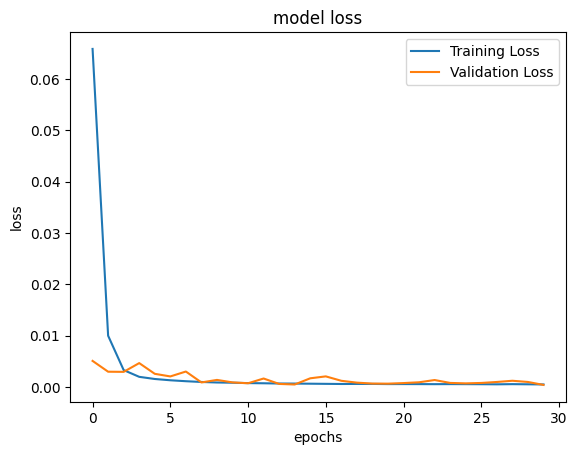

In [122]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

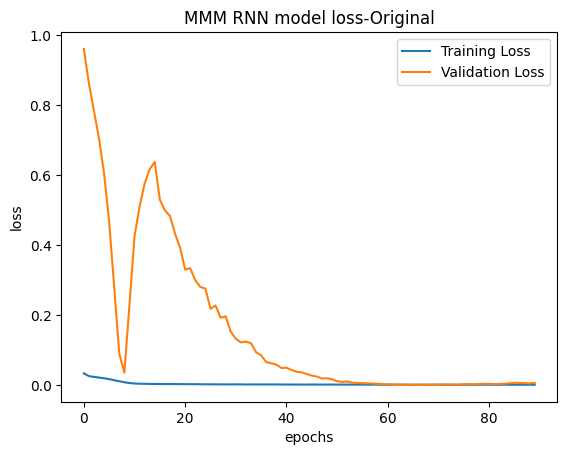

In [39]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [123]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model/{ticker}_model_{study_naam}')


# def save_history_tf(PATH,history_name):
#   with open(f'{PATH}/{history_name}', 'wb') as file:  #autoencoder_cnn_tf_history_v1.pickle
#     pickle.dump(history.history, f'{ticker}_history_{study_naam}')
    # loaded_history = pickle.load(file)

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model/MMM_model_Original/assets


INFO:tensorflow:Assets written to: saved_model/MMM_model_Original/assets


In [ ]:
best_model.save(f'saved_model/{ticker}_model(actv)_{study_naam}')

In [124]:
# Display the model's architecture
best_model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_449 (SimpleRNN)  (None, 10, 50)            2600      
                                                                 
 dropout_442 (Dropout)       (None, 10, 50)            0         
                                                                 
 simple_rnn_450 (SimpleRNN)  (None, 10, 50)            5050      
                                                                 
 dropout_443 (Dropout)       (None, 10, 50)            0         
                                                                 
 simple_rnn_451 (SimpleRNN)  (None, 10, 50)            5050      
                                                                 
 dropout_444 (Dropout)       (None, 10, 50)            0         
                                                                 
 simple_rnn_452 (SimpleRNN)  (None, 10, 50)          

In [ ]:
# Display the model's architecture
best_model.summary()

##### Load model

In [ ]:
# new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

#First load create model object
new_model = tf.keras.models.load_model(f'saved_model/{ticker}_model_{study_naam}')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

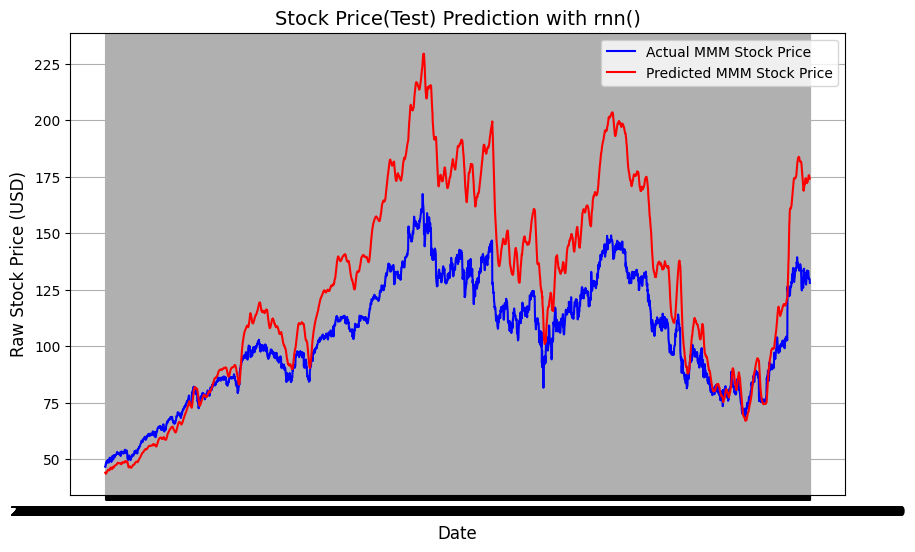

In [40]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
plot_comparison(y_test,predicted_stock_price_raw)

#### MMM - Filtered(SMA)

##### Start Tuning

The file 'MMM_data.csv' does exist.
Filter Name- SMA


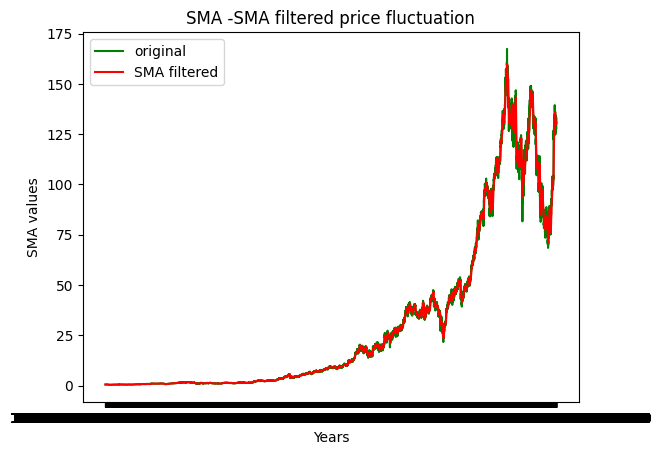

In [32]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Train model with best values

In [ ]:
{'win_size': 10,
 'epoch_no': 30,
 'split_size': 0.1,
 'units': 50,
 'drop_out': 0.2,
 'optimizer_name': 'adam',
 'no_layers': 6,
 'loss_fn_name': 'huber_loss'}

In [33]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 20 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
sma_win = 20
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)


2024-12-20 10:36:47.259939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13874 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-12-20 10:36:47.449233: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-20 10:36:47.452299: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-20 10:36:47.452328: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-20 10:36:47.452387: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to comp

(10, 1)
Epoch 1/20


2024-12-20 10:36:51.975163: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-20 10:36:51.978772: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-20 10:36:52.149685: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-20 10:36:52.149823: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

446/446 [==============================] - 28s 49ms/step - loss: 0.0549 - val_loss: 0.0168
Epoch 2/20
446/446 [==============================] - 21s 47ms/step - loss: 0.0085 - val_loss: 0.0037
Epoch 3/20
446/446 [==============================] - 21s 47ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 4/20
446/446 [==============================] - 20s 45ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 5/20
446/446 [==============================] - 20s 45ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 6/20
446/446 [==============================] - 20s 45ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/20
446/446 [==============================] - 20s 45ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 8/20
446/446 [==============================] - 25s 56ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 9/20
446/446 [==============================] - 20s 45ms/step - loss: 9.6489e-04 - val_loss: 0.0017
Epoch 10/20
446/446 [==============================] - 20s 46ms/step - loss: 8.7563e-04 -

##### Evalute tuned model

In [34]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 11ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.14%
Mean Absolute Error (MAE): 13.65
Root Mean Squared Error (RMSE): 14.93
R2 Score: 0.40


##### Validation and training loss plot

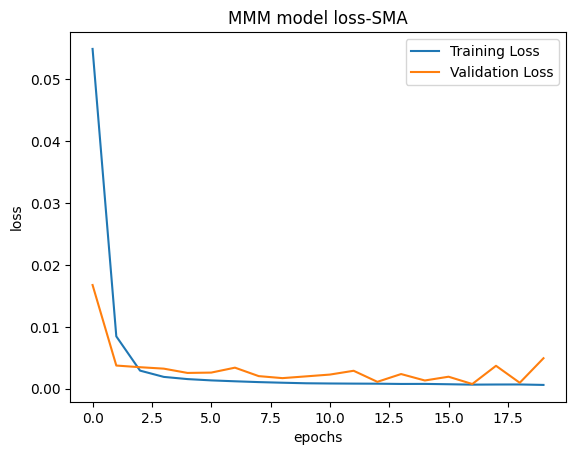

In [35]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [36]:
# Save the entire model as a `.keras` zip archive.
# best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')
best_model.save(f'saved_model/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model/MMM_model_SMA/assets


INFO:tensorflow:Assets written to: saved_model/MMM_model_SMA/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

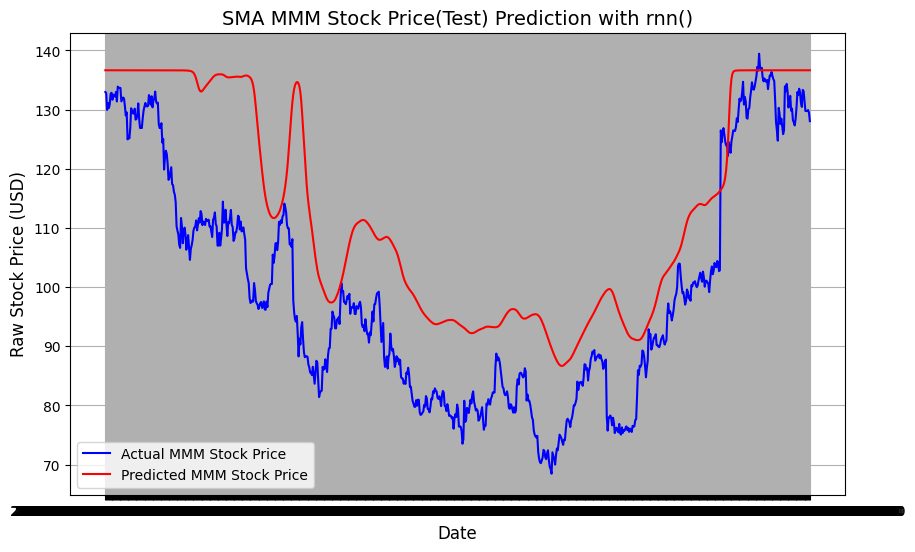

In [45]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="rnn"
plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

#### MMM - Filtered(kalman)

##### Start Tuning

The file 'MMM_data.csv' does exist.
Filter Name- kalman


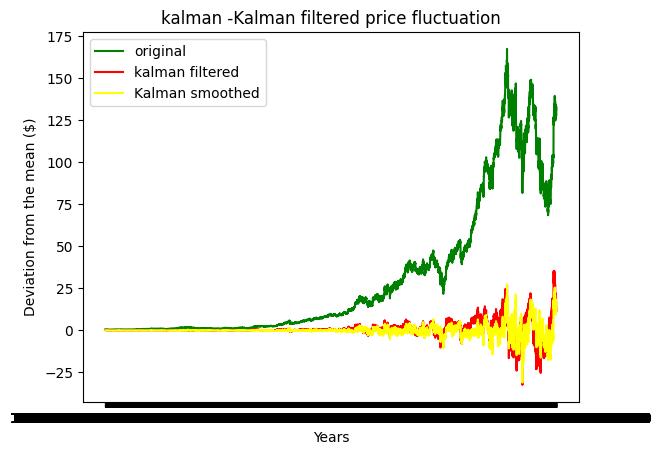

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="kalman" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="kalman"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [38]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/100
446/446 [==============================] - 27s 48ms/step - loss: 0.0702 - val_loss: 0.0328
Epoch 2/100
446/446 [==============================] - 20s 46ms/step - loss: 0.0114 - val_loss: 0.0321
Epoch 3/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0046 - val_loss: 0.0222
Epoch 4/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0029 - val_loss: 0.0142
Epoch 5/100
446/446 [==============================] - 20s 45ms/step - loss: 0.0019 - val_loss: 0.0100
Epoch 6/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0013 - val_loss: 0.0090
Epoch 7/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0011 - val_loss: 0.0090
Epoch 8/100
446/446 [==============================] - 20s 45ms/step - loss: 9.1223e-04 - val_loss: 0.0076
Epoch 9/100
446/446 [==============================] - 20s 45ms/step - loss: 8.1240e-0

##### Evaluate trained model

epoch=20

In [33]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 9ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 0.75%
Mean Absolute Error (MAE): 4.72
Root Mean Squared Error (RMSE): 6.63
R2 Score: 0.77


epoch=100

In [39]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 9ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 0.65%
Mean Absolute Error (MAE): 3.09
Root Mean Squared Error (RMSE): 4.83
R2 Score: 0.88


##### Val and training loss plot

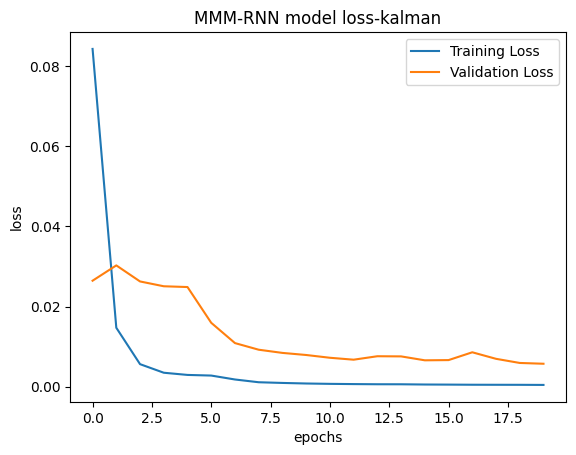

In [34]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker}-RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

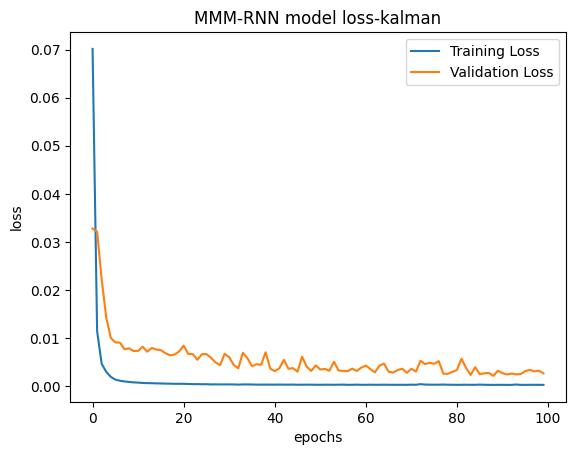

In [40]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker}-RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [36]:
# Save the entire model as a `.keras` zip archive.
# best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')
best_model.save(f'saved_model/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model/MMM_model_kalman/assets


INFO:tensorflow:Assets written to: saved_model/MMM_model_kalman/assets


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [37]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [41]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### MMM - Filtered(EMA)

##### Start Tuning

The file 'MMM_data.csv' does exist.
Filter Name- EMA


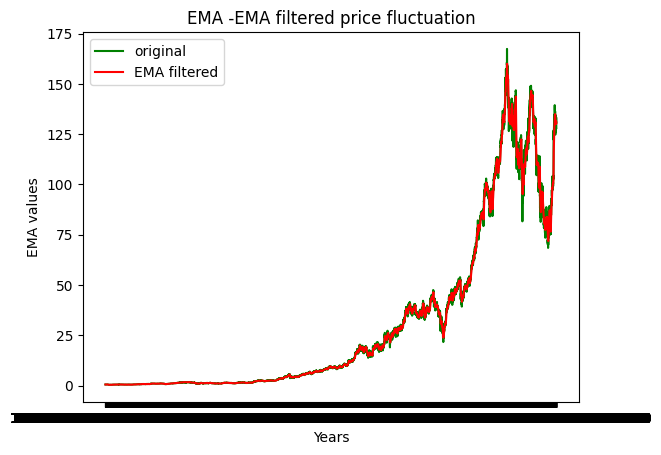

In [42]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
ema_win=100
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'MMM_data.csv' does exist.
Filter Name- EMA


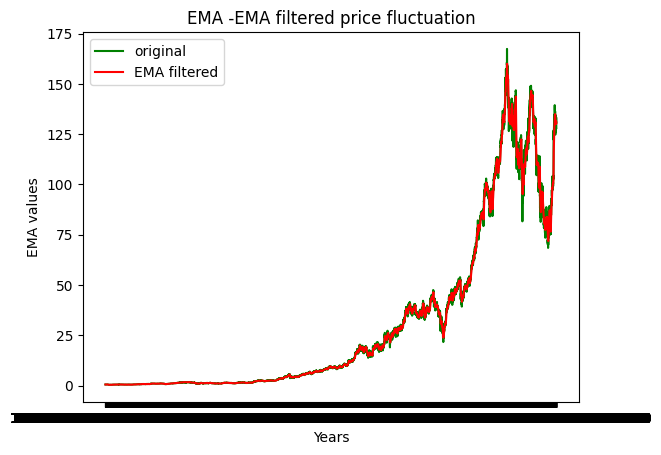

In [55]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
ema_win=20
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Evaluate model with best values

In [43]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']

best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/100
446/446 [==============================] - 27s 48ms/step - loss: 0.0880 - val_loss: 0.0027
Epoch 2/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0153 - val_loss: 0.0028
Epoch 3/100
446/446 [==============================] - 20s 46ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 4/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 5/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 6/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0011 - val_

In [56]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/100
446/446 [==============================] - 27s 48ms/step - loss: 0.0798 - val_loss: 0.0094
Epoch 2/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0126 - val_loss: 0.0052
Epoch 3/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 4/100
446/446 [==============================] - 20s 46ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 5/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 6/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 7/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 9/100
446/446 [==============================] - 21s 47ms/step - loss: 9.6847e-04 - 

##### Evaluate trained model

In [44]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 10ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.06%
Mean Absolute Error (MAE): 6.03
Root Mean Squared Error (RMSE): 7.12
R2 Score: 0.86


In [57]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 10ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.30
Root Mean Squared Error (RMSE): 4.11
R2 Score: 0.95


##### Val and training loss plot

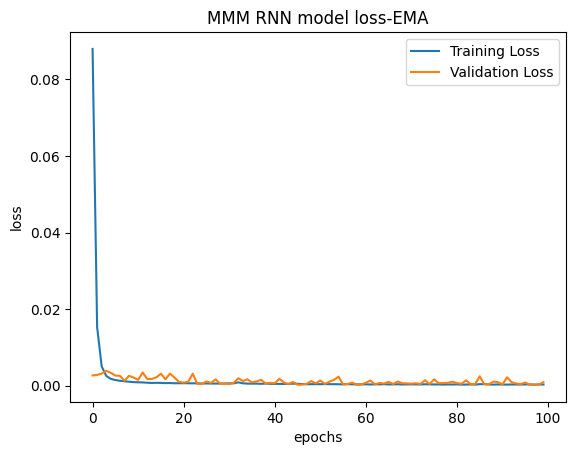

In [45]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

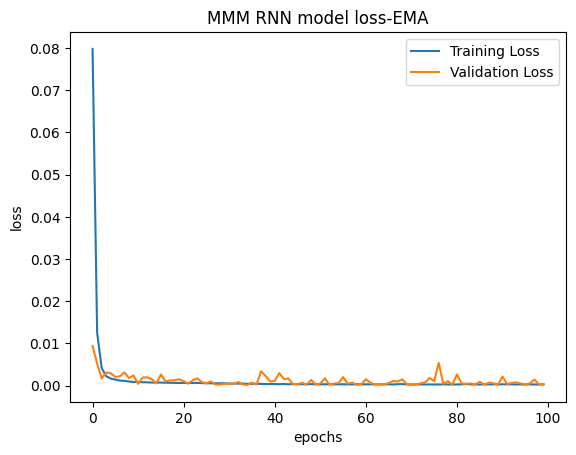

In [58]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [46]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{ema_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_EMA_100/assets


INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_EMA_100/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [47]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [59]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### MMM - Filtered(MACD)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MACD" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MACD"
abc(ticker,n_trial,filter,f"{study_naam}",batch_size_no,attn)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Evaluate model with best values

In [ ]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(stock_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [ ]:
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### MMM - Filtered(Fourier)

##### Start Tuning

The file 'MMM_data.csv' does exist.
freq- [ 0.00000000e+00  6.30954634e-05  1.26190927e-04 ... -1.89286390e-04
 -1.26190927e-04 -6.30954634e-05]
amp- [480674.12022886 341676.29187914 202154.25583769 ... 151775.07892297
 202154.25583769 341676.29187914]


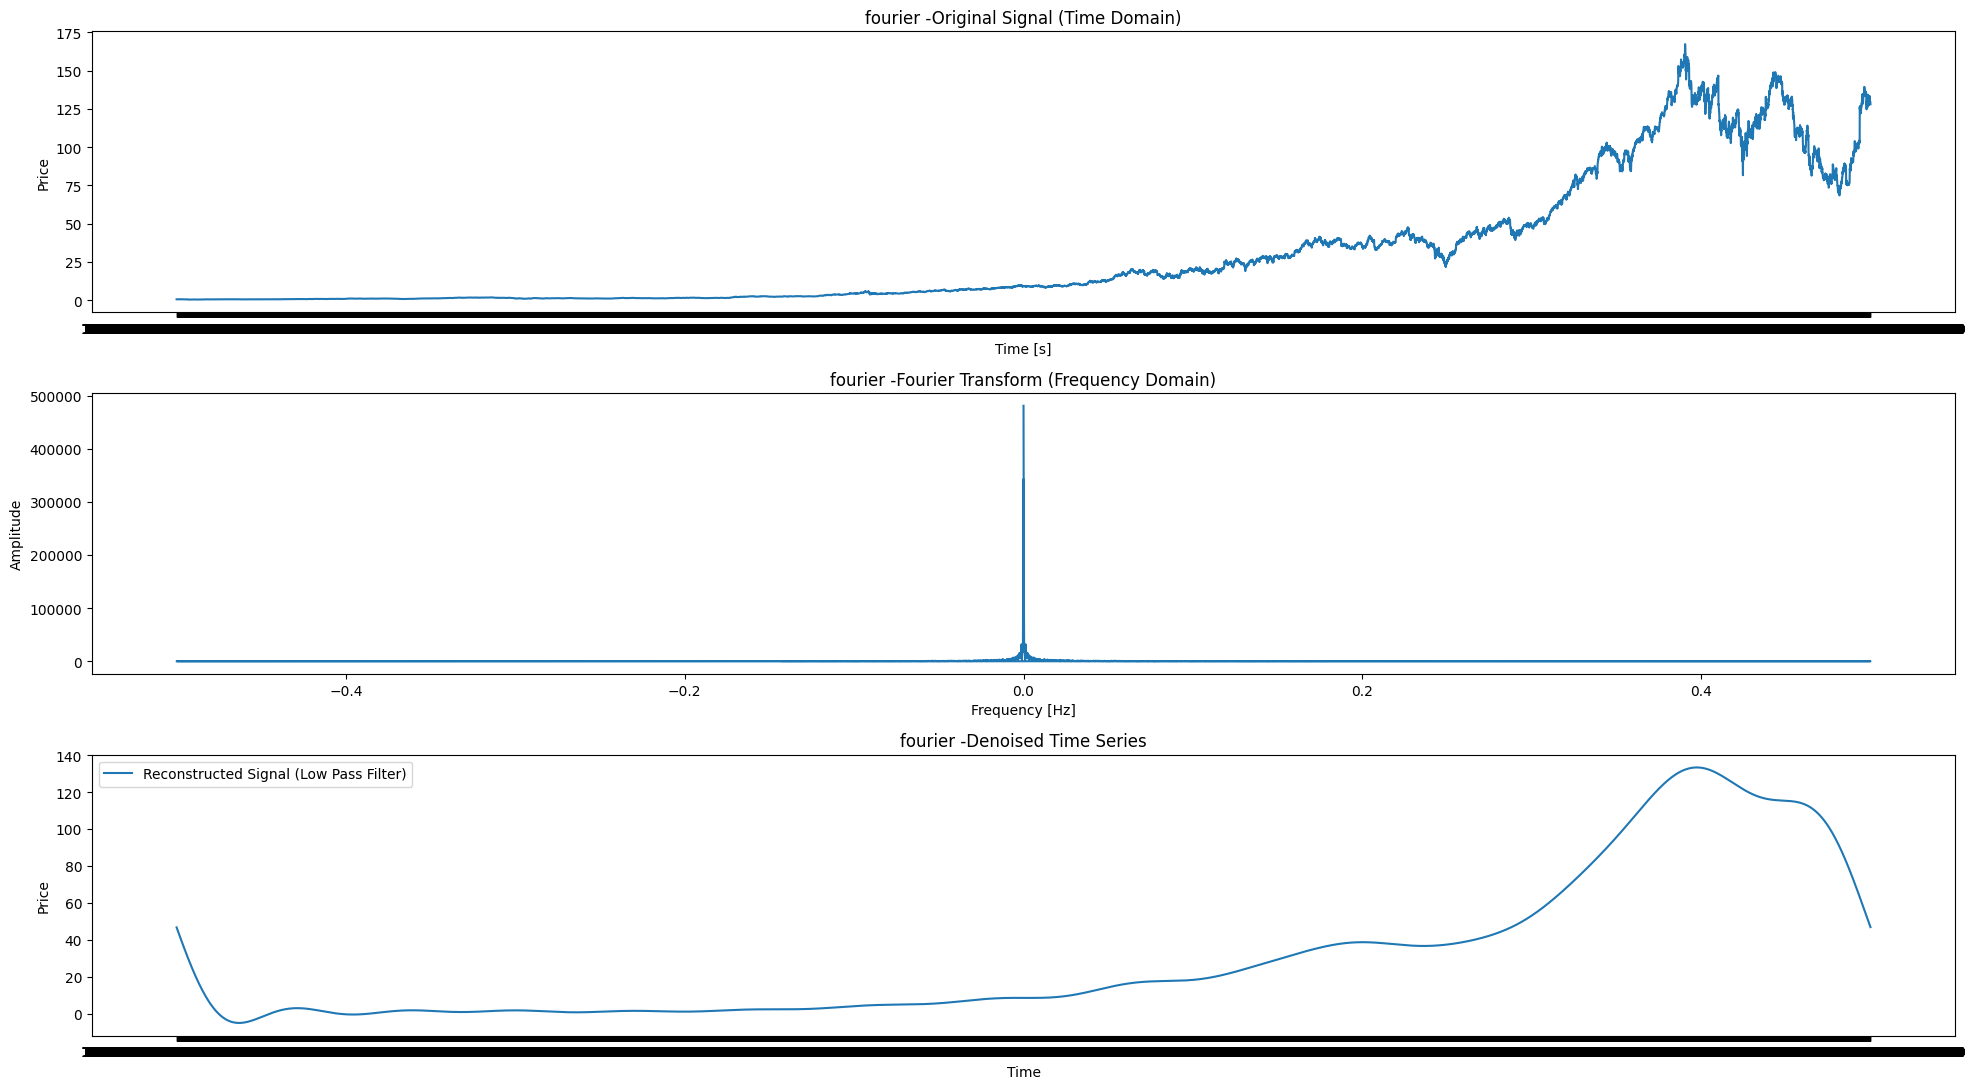

Filter Name- fourier


In [48]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'MMM_data.csv' does exist.
freq- [ 0.00000000e+00  6.30954634e-05  1.26190927e-04 ... -1.89286390e-04
 -1.26190927e-04 -6.30954634e-05]
amp- [480674.12022886 341676.29187914 202154.25583769 ... 151775.07892297
 202154.25583769 341676.29187914]


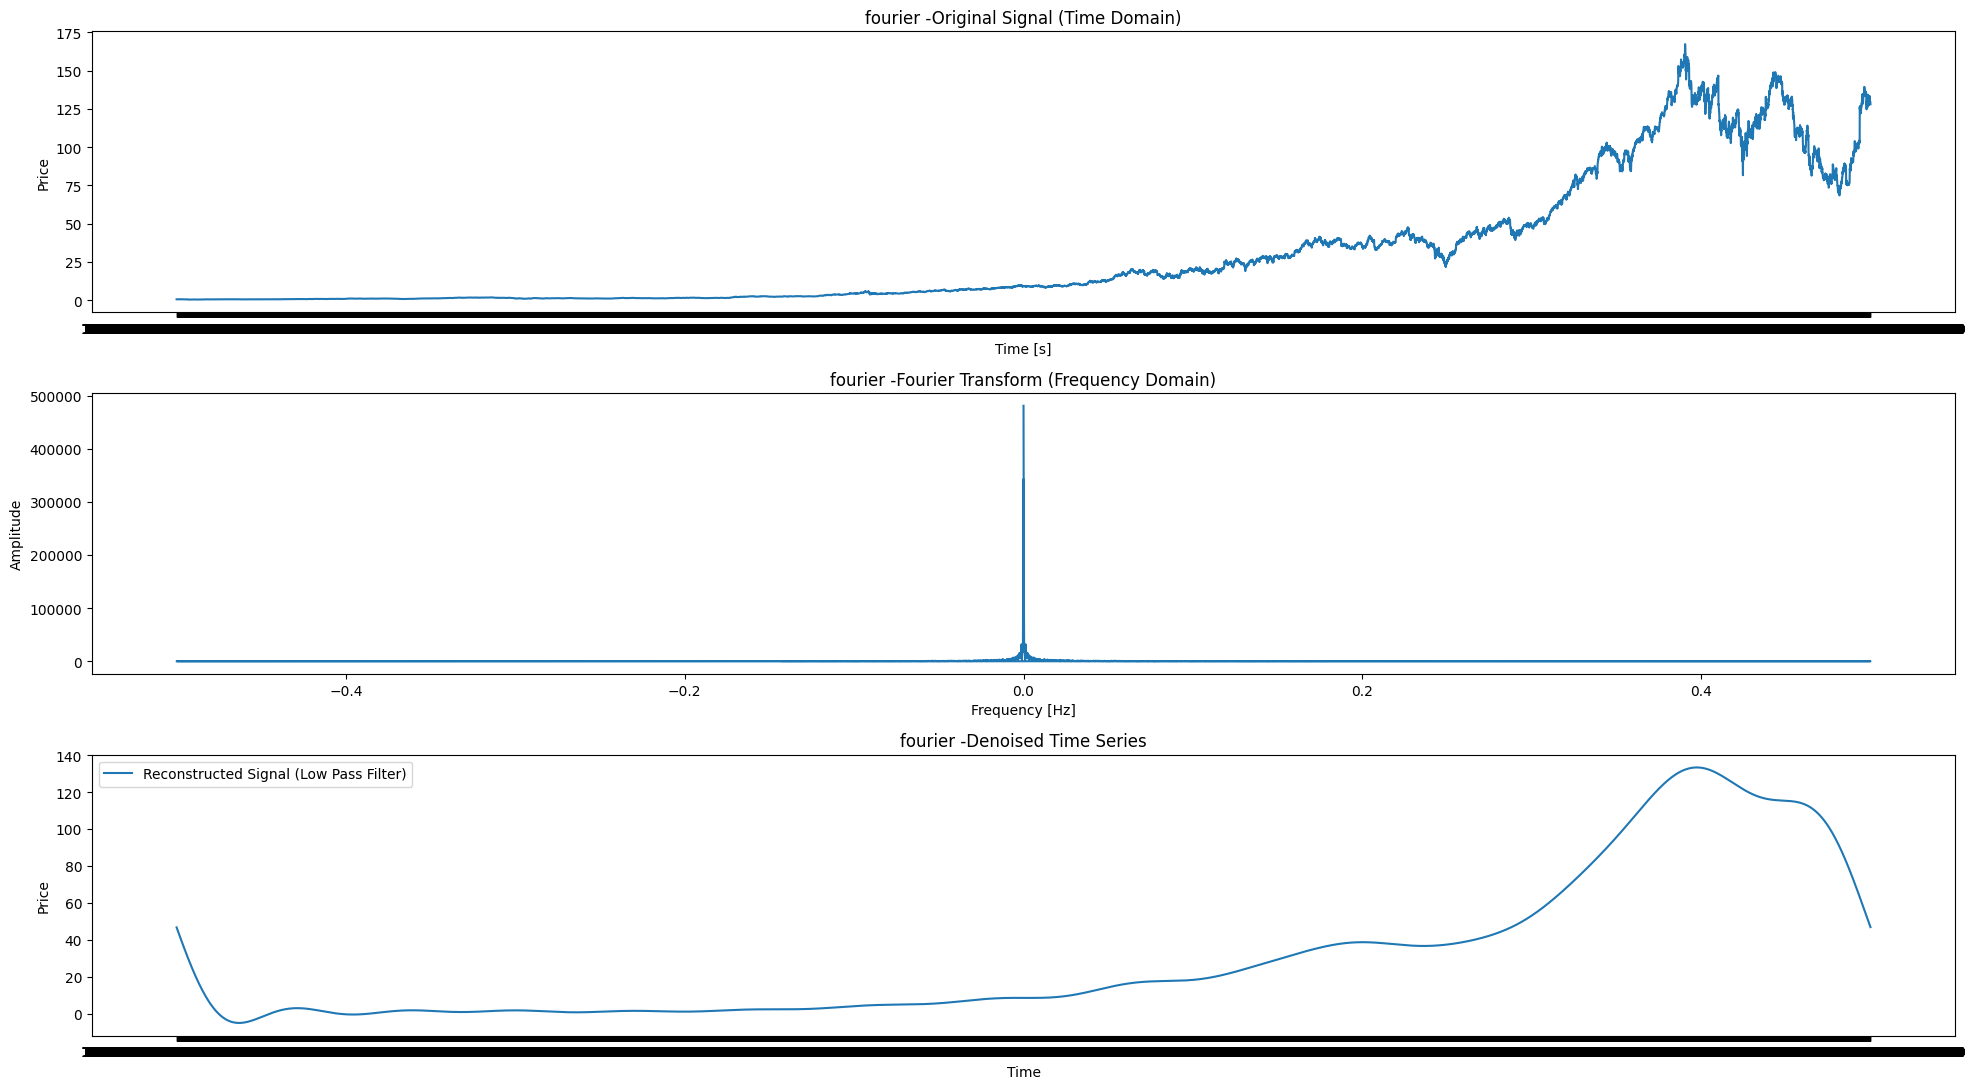

Filter Name- fourier


In [60]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.2 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'MMM_data.csv' does exist.
freq- [ 0.00000000e+00  6.30954634e-05  1.26190927e-04 ... -1.89286390e-04
 -1.26190927e-04 -6.30954634e-05]
amp- [480674.12022886 341676.29187914 202154.25583769 ... 151775.07892297
 202154.25583769 341676.29187914]


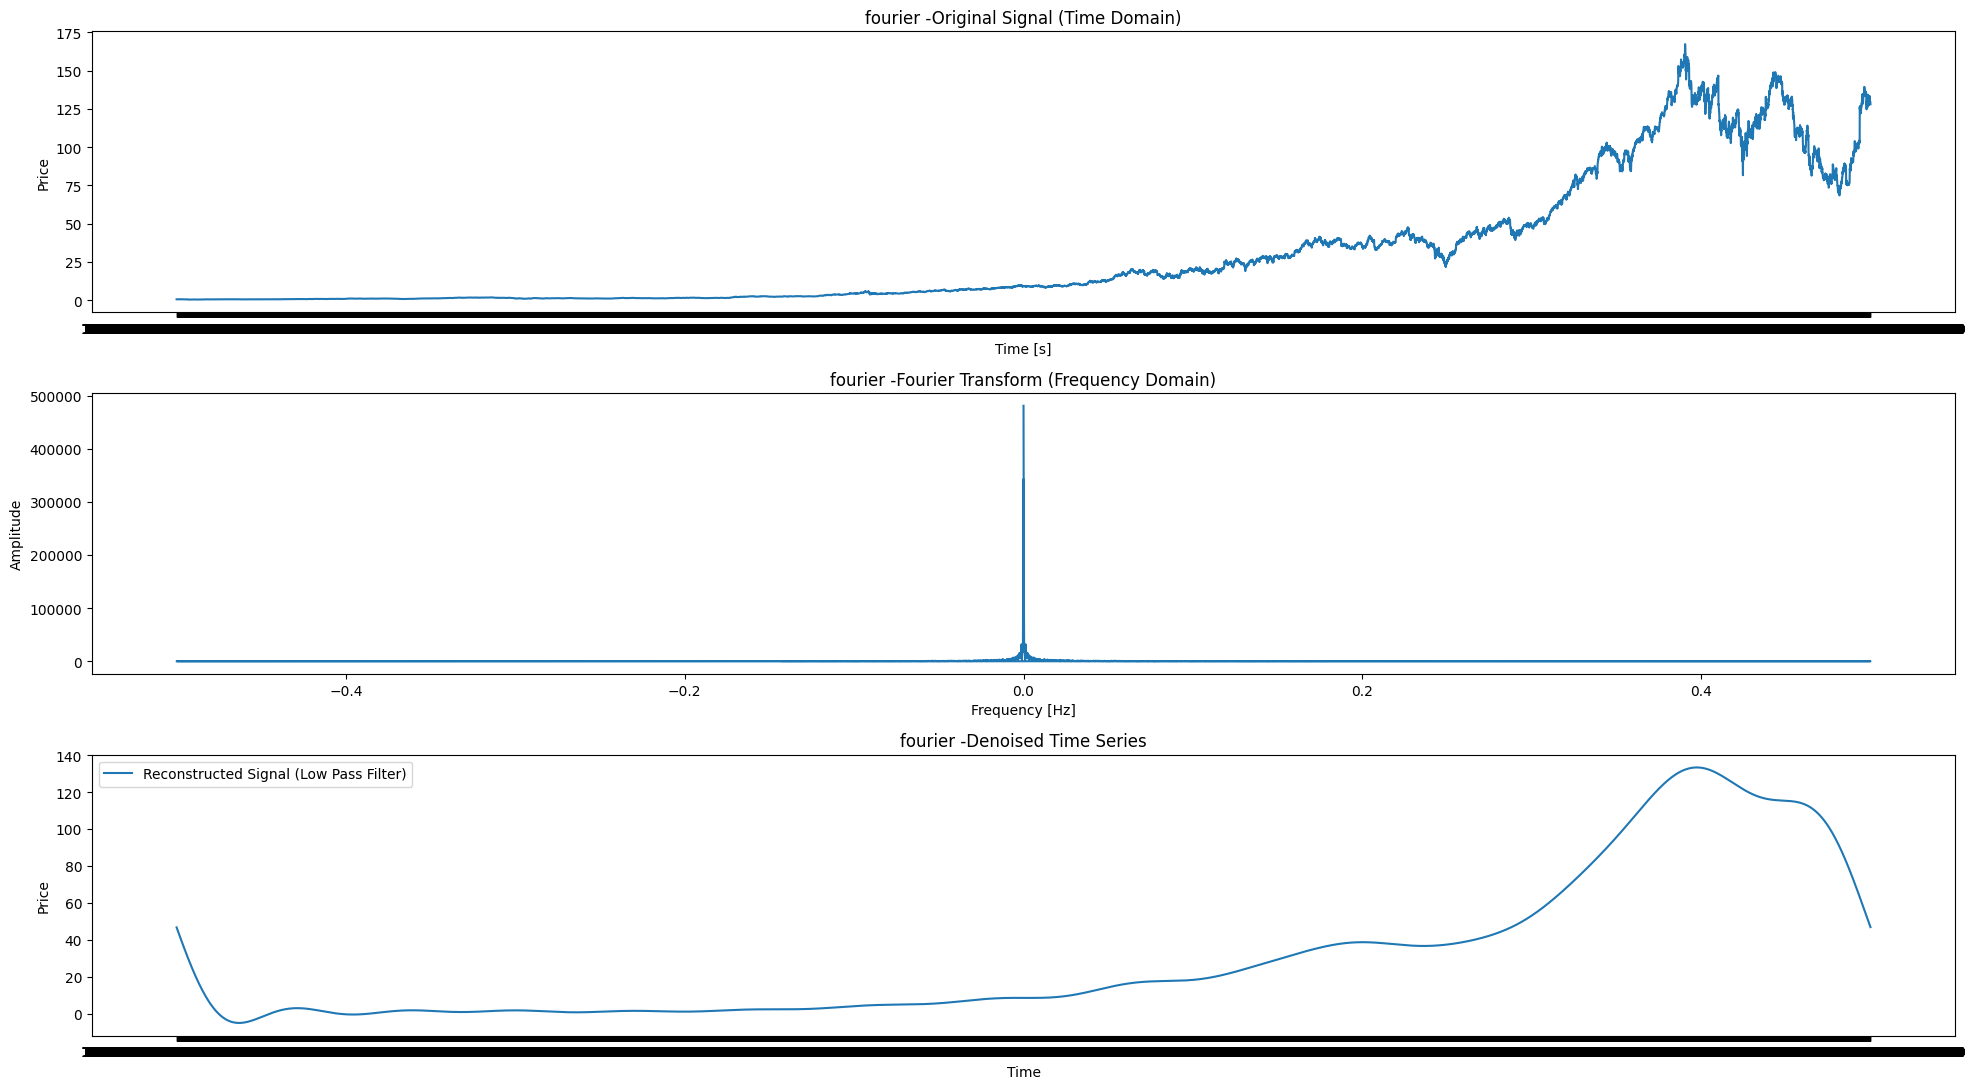

Filter Name- fourier


In [66]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.01 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### After hyperparameter tuning - Train model with best values

In [49]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/100
446/446 [==============================] - 29s 48ms/step - loss: 0.0630 - val_loss: 0.0049
Epoch 2/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 3/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0038 - val_loss: 9.3271e-04
Epoch 4/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/100
446/446 [==============================] - 21s 46ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0012 - 

In [61]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (14255, 10)
scaled X_train size (14255, 10, 1) (14255,)
(10, 1)
Epoch 1/100
446/446 [==============================] - 25s 45ms/step - loss: 0.0676 - val_loss: 0.0029
Epoch 2/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0108 - val_loss: 0.0028
Epoch 3/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 4/100
446/446 [==============================] - 19s 44ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 5/100
446/446 [==============================] - 20s 44ms/step - loss: 0.0019 - val_loss: 8.2041e-04
Epoch 6/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0013 - val_loss: 8.7303e-04
Epoch 8/100
446/446 [==============================] - 21s 47ms/step - loss: 0.0012 - val_loss: 6.8766e-04
Epoch 9/100
446/446 [==============================] - 21s 47ms/step - loss: 0

In [67]:
win_size= 40 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.5 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.4 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_rnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (9485, 40)
scaled X_train size (9485, 40, 1) (9485,)
(40, 1)
Epoch 1/100


2025-01-02 13:17:26.152103: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 13:17:26.153496: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 13:17:26.153813: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-02 13:17:26.153884: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to com

297/297 [==============================] - 26s 76ms/step - loss: 0.6077 - val_loss: 0.1523
Epoch 2/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0885 - val_loss: 0.0866
Epoch 3/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0223 - val_loss: 0.1256
Epoch 4/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0094 - val_loss: 0.1466
Epoch 5/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0057 - val_loss: 0.1407
Epoch 6/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0043 - val_loss: 0.1331
Epoch 7/100
297/297 [==============================] - 22s 74ms/step - loss: 0.0037 - val_loss: 0.1366
Epoch 8/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0034 - val_loss: 0.1225
Epoch 9/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0031 - val_loss: 0.1240
Epoch 10/100
297/297 [==============================] - 22s 75ms/step - loss: 0.0030 

##### Evaluate trained model

In [50]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 10ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.02%
Mean Absolute Error (MAE): 2.03
Root Mean Squared Error (RMSE): 2.37
R2 Score: 0.99


In [62]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 11ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.02%
Mean Absolute Error (MAE): 1.95
Root Mean Squared Error (RMSE): 2.29
R2 Score: 0.99


In [68]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

99/99 [==============================] - 2s 16ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.47%
Mean Absolute Error (MAE): 51.81
Root Mean Squared Error (RMSE): 56.77
R2 Score: -4.38


##### Val and training loss plot

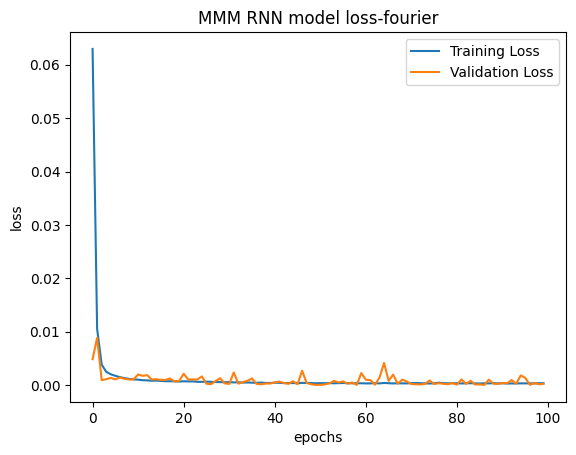

In [51]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

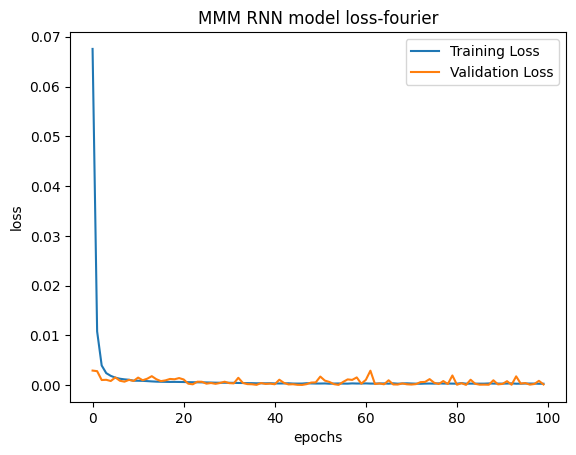

In [63]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

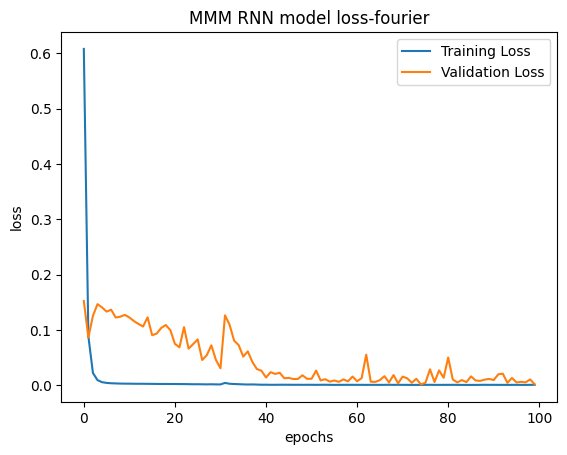

In [69]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [70]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{threshold}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_fourier_0.01/assets


INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_fourier_0.01/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [53]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [65]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [71]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### MMM - Filtered(Wavelet)

##### Start Tuning

The file 'MMM_data.csv' does exist.
length of details- 8
Threshold enabled- False


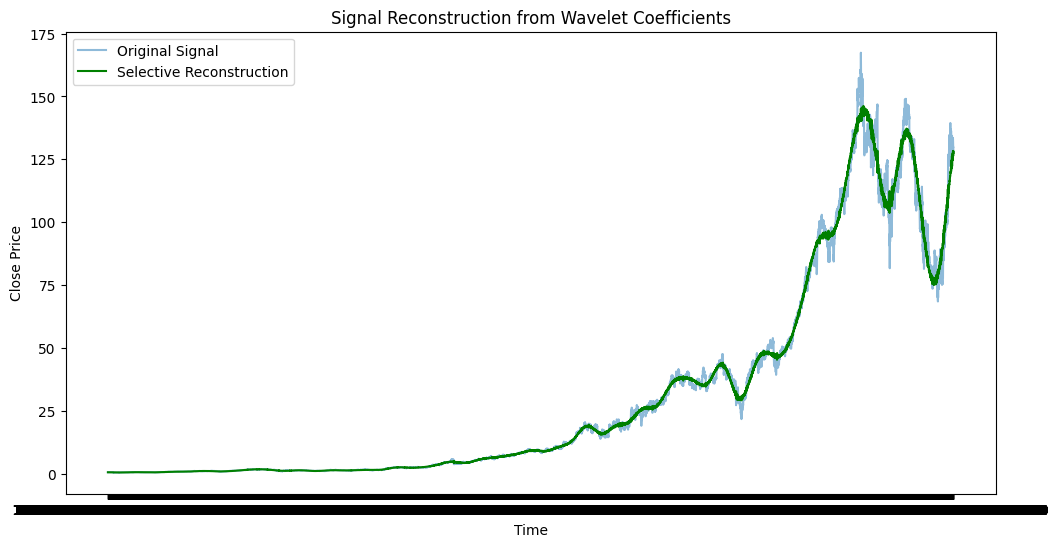

Filter Name- wavelet


In [75]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=6
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'MMM_data.csv' does exist.
length of details- 8
Threshold enabled- False


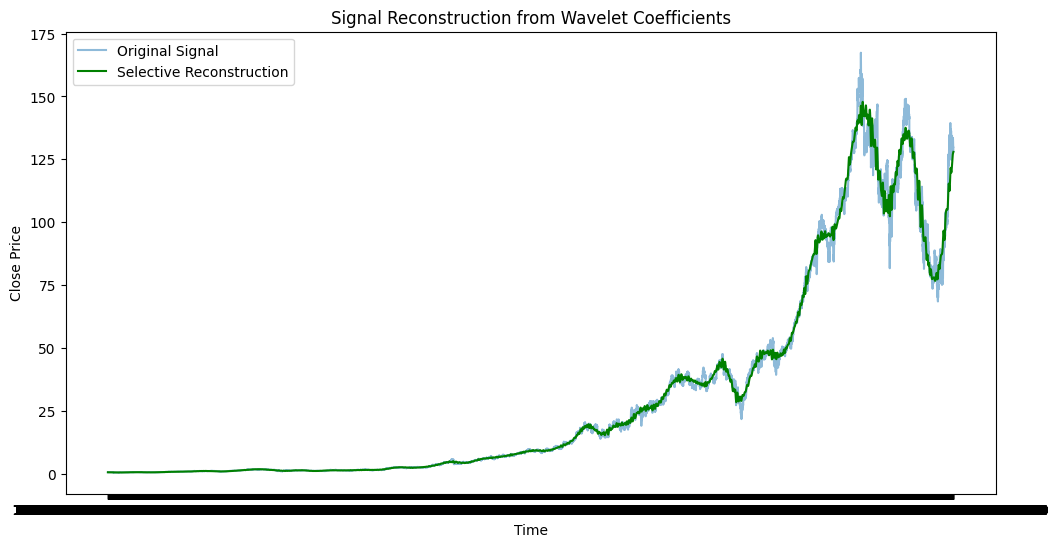

Filter Name- wavelet


In [81]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=3
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=9
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="db4"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

##### After hyperparameter tuning - Train model with best values

In [76]:
win_size= 40 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.4 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (9486, 40)
scaled X_train size (9486, 40, 1) (9486,)
(40, 1)
Epoch 1/100
297/297 [==============================] - 50s 149ms/step - loss: 0.2382 - val_loss: 0.6619
Epoch 2/100
297/297 [==============================] - 42s 141ms/step - loss: 0.0553 - val_loss: 0.5069
Epoch 3/100
297/297 [==============================] - 42s 140ms/step - loss: 0.0126 - val_loss: 0.5458
Epoch 4/100
297/297 [==============================] - 42s 140ms/step - loss: 0.0064 - val_loss: 0.5647
Epoch 5/100
297/297 [==============================] - 41s 140ms/step - loss: 0.0045 - val_loss: 0.5252
Epoch 6/100
297/297 [==============================] - 42s 140ms/step - loss: 0.0035 - val_loss: 0.5485
Epoch 7/100
297/297 [==============================] - 42s 140ms/step - loss: 0.0030 - val_loss: 0.5299
Epoch 8/100
297/297 [==============================] - 41s 139ms/step - loss: 0.0026 - val_loss: 0.5129
Epoch 9/100
297/297 [==============================] - 42s 140ms/step - loss: 0.0025 

In [82]:
win_size= 20 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.5 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_rnn.best_trial.params['no_layers']  
loss_option= 'mean_squared_error' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (14247, 20)
scaled X_train size (14247, 20, 1) (14247,)
(20, 1)
Epoch 1/100
446/446 [==============================] - 22s 44ms/step - loss: 0.1736 - val_loss: 0.0222
Epoch 2/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0230 - val_loss: 0.0022
Epoch 3/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0098 - val_loss: 0.0027
Epoch 4/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 5/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 6/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 7/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0033 - val_loss: 0.0057
Epoch 8/100
446/446 [==============================] - 19s 42ms/step - loss: 0.0029 - val_loss: 0.0146
Epoch 9/100
446/446 [==============================] - 19s 43ms/step - loss: 0.0025 - val_

In [ ]:
win_size= 10 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.2 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.1 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

##### Evaluate trained model

In [77]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

99/99 [==============================] - 3s 25ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.90%
Mean Absolute Error (MAE): 94.48
Root Mean Squared Error (RMSE): 97.82
R2 Score: -13.87


In [83]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

25/25 [==============================] - 1s 11ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 4.26
Root Mean Squared Error (RMSE): 4.75
R2 Score: 0.93


In [ ]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

##### Val and training loss plot

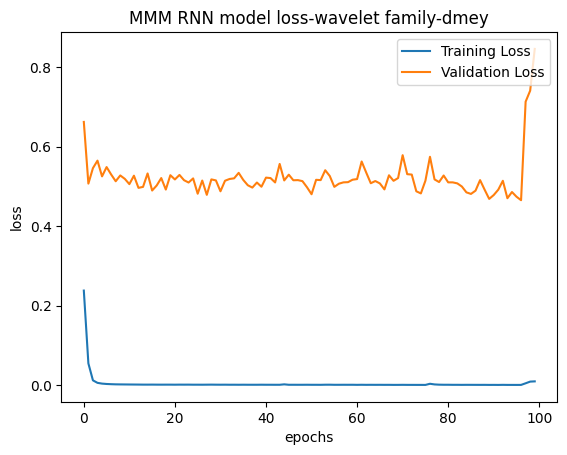

In [78]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

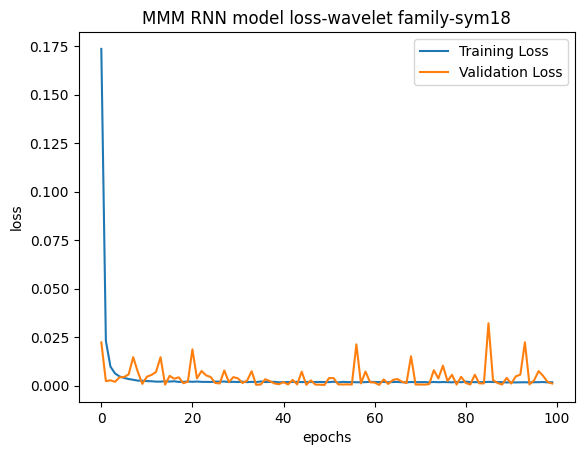

In [84]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [ ]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} RNN model loss-{study_naam} family-{wavelet_name}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [85]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}_{wavelet_name}({detail_index})')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_wavelet_sym18(3)/assets


INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_wavelet_sym18(3)/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [80]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [86]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [ ]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

#### MMM - Filtered(MSTL)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="mstl" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="mstl"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_rnn)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [ ]:
study_rnn.best_trial.params

##### After hyperparameter tuning - Train model with best values

In [ ]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(stock_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [51]:
X_test_unfilt.shape

(719, 40)

In [52]:
type(X_test_unfilt)

numpy.ndarray

In [ ]:
X_test_unfilt

In [ ]:
# scaled_data_org = scaler.transform(stock_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_rnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### MMM - Filtered(STL)

##### Start Tuning

In [37]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="STL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="STL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

[I 2024-12-18 15:02:28,661] A new study created in memory with name: STL
[W 2024-12-18 15:02:28,683] Trial 0 failed with parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.4, 'units': 60, 'drop_out': 0.30000000000000004, 'optimizer_name': 'sgd', 'no_layers': 10, 'loss_fn_name': 'log_cosh'} because of the following error: ValueError('Found array with dim 3. MinMaxScaler expected <= 2.').
Traceback (most recent call last):
  File "/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_12536/3987524730.py", line 13, in objective_rnn
    model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_options)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_12536/3131254804.py", line 15, in build_model
    scaled_tra

X_train size (3643, 1)


ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

##### Optuna plot

In [32]:
optuna.visualization.plot_optimization_history(study_rnn)

In [33]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_rnn)

##### Best parameter values

In [34]:
study_rnn.best_trial.params

{'win_size': 40,
 'epoch_no': 20,
 'split_size': 0.30000000000000004,
 'units': 50,
 'drop_out': 0.4}

##### After hyperparameter tuning - Train model with best values

In [35]:
win_size=study_rnn.best_trial.params['win_size']
pred_step=10
epoch_no=study_rnn.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_rnn.best_trial.params['split_size'],2)
attn=False
units=study_rnn.best_trial.params['units']
drop_out=round(study_rnn.best_trial.params['drop_out'],2)
n_trial=0

best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(stock_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_rnn.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/20
79/79 [==============================] - 5s 41ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 2/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0018 - val_loss: 0.0258
Epoch 3/20
79/79 [==============================] - 3s 39ms/step - loss: 0.0010 - val_loss: 0.0143
Epoch 4/20
79/79 [==============================] - 3s 39ms/step - loss: 8.0450e-04 - val_loss: 0.0141
Epoch 5/20
79/79 [==============================] - 3s 38ms/step - loss: 6.7514e-04 - val_loss: 0.0039
Epoch 6/20
79/79 [==============================] - 3s 40ms/step - loss: 5.1371e-04 - val_loss: 0.0095
Epoch 7/20
79/79 [==============================] - 3s 39ms/step - loss: 4.7500e-04 - val_loss: 0.0052
Epoch 8/20
79/79 [==============================] - 3s 39ms/step - loss: 3.3246e-04 - val_loss: 0.0072
Epoch 9/20
79/79 [==============================] - 3s 39ms/step - loss: 3.9058e-04 - val_loss: 0.0081
Epoch 10/20
79/79 [==============================] - 3s 40ms/step - loss: 3.9896e-04 

##### Evaluate trained model

In [36]:
X_test_unfilt.shape

(1078, 40)

In [40]:
type(X_test_unfilt)

numpy.ndarray

In [41]:
X_test_unfilt

array([[0.1772717 , 0.16990007, 0.17442608, ..., 0.29414616, 0.32745267,
        0.33671899],
       [0.16990007, 0.17442608, 0.16970016, ..., 0.32745267, 0.33671899,
        0.33517731],
       [0.17442608, 0.16970016, 0.17863509, ..., 0.33671899, 0.33517731,
        0.35738406],
       ...,
       [0.69390169, 0.66958778, 0.64700282, ..., 0.91440227, 0.94930625,
        0.91156559],
       [0.66958778, 0.64700282, 0.67245142, ..., 0.94930625, 0.91156559,
        0.91059308],
       [0.64700282, 0.67245142, 0.64746208, ..., 0.91156559, 0.91059308,
        0.89616681]])

In [38]:
# scaled_data_org = scaler.transform(stock_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_rnn.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

34/34 [==============================] - 0s 9ms/step
**********************STL filter***************************
Mean Absolute Percentage Error (MAPE): 0.08%
Mean Absolute Error (MAE): 19.01
Root Mean Squared Error (RMSE): 23.06
R2 Score: 0.84


##### Val and training loss plot

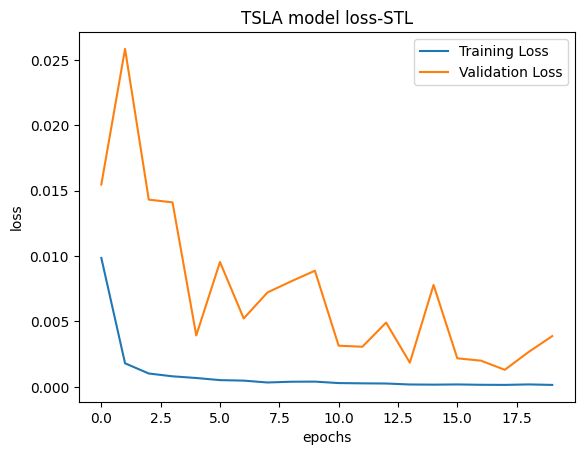

In [39]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [42]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 40, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 40, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7701 (30.08 KB)
Trainable params: 7701 (30.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

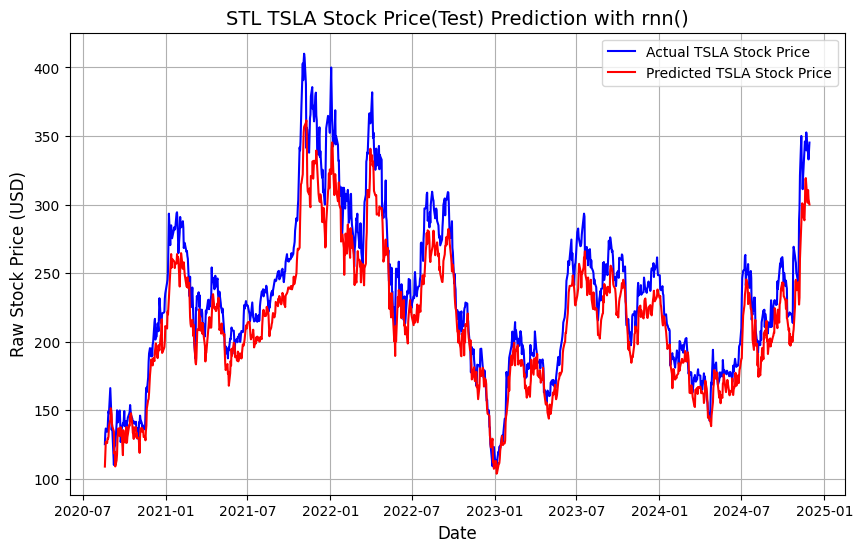

In [43]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="rnn"
plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
rt_fft = tf.signal.fft(stock_data['Close'])
fft = tf.signal.rfft(stock_data[['Close']])
np.fft.fft(stock_data['Close'])
recovered = tf.signal.ifft(rt_fft)
#plot stock_data['Close] and recovered with x axis as stock_data.index
plt.figure(figsize=(16,8))
plt.plot(stock_data.index,stock_data['Close'], label='Org Price', color='blue')
plt.plot(stock_data.index,recovered, label='Rec Price', color='green')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [72]:
len(stock_data['Close'])

5534

In [ ]:
# import scipy.fft as fft
# # Generate a time-domain signal
# t = np.linspace(0, 1, 1000)
# x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)

# # Calculate the Fourier Transform
# X = fft.fft(stock_data['Close'].values)
# freqs = fft.fftfreq(stock_data['Close'].size,d=1)  # Calculate the frequencies

# from scipy import signal
# sos = signal.butter(2, 0.001, 'low', analog=False,output='sos')
# filtered = signal.sosfilt(sos, stock_data[['Close']])
# # w, h = signal.freqs(b, a)

# # Plot the frequency-domain representation of the signal
# import matplotlib.pyplot as plt
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim([0, 50])  # Display frequencies from 0 to 50 Hz for clarity
# plt.show()

# #Plot the filtered data
# plt.figure(figsize=(10,6))
# plt.plot(stock_data.index,filtered,label="filtered")
# plt.plot(stock_data.index,stock_data[['Close']],label="Actual")
# plt.title('Filtered Data')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()


#### MMM - Proposed Filter(hybrid) - fourier_wavelet

In [31]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="MMM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="hybrid" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="hybrid"
tuning=False
stock_file_name="MMM_autoencoder_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [32]:
win_size= 40 #study_rnn.best_trial.params['win_size']
epoch_no= 100 #study_rnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_rnn.best_trial.params['drop_out'],2)
units= 50 #study_rnn.best_trial.params['units']
split_size= 0.4 #round(study_rnn.best_trial.params['split_size'],2)
optimizer_options = 'adam' #study_rnn.best_trial.params['optimizer_name']
num_of_layers= 6 #study_rnn.best_trial.params['no_layers']  
loss_option= 'huber_loss' #study_rnn.best_trial.params['loss_fn_name']
actv_option='relu' #study_rnn.best_trial.params['activation_name']


best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (4176, 40)
scaled X_train size (4176, 40, 1) (4176,)


2025-01-08 12:36:37.338628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14029 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-08 12:36:37.564949: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:36:37.567248: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-08 12:36:37.567294: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-08 12:36:37.567340: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to comp

(40, 1)
Epoch 1/100


2025-01-08 12:36:42.196063: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:36:42.198222: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-01-08 12:36:42.383439: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 12:36:42.384238: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

131/131 [==============================] - 26s 152ms/step - loss: 0.2640 - val_loss: 109.8881
Epoch 2/100
131/131 [==============================] - 19s 145ms/step - loss: 0.1146 - val_loss: 109.7458
Epoch 3/100
131/131 [==============================] - 19s 148ms/step - loss: 0.0545 - val_loss: 109.8509
Epoch 4/100
131/131 [==============================] - 19s 147ms/step - loss: 0.0268 - val_loss: 109.7801
Epoch 5/100
131/131 [==============================] - 19s 145ms/step - loss: 0.0134 - val_loss: 109.7501
Epoch 6/100
131/131 [==============================] - 19s 144ms/step - loss: 0.0078 - val_loss: 109.7501
Epoch 7/100
131/131 [==============================] - 18s 141ms/step - loss: 0.0052 - val_loss: 109.7261
Epoch 8/100
131/131 [==============================] - 18s 141ms/step - loss: 0.0042 - val_loss: 109.7590
Epoch 9/100
131/131 [==============================] - 19s 142ms/step - loss: 0.0036 - val_loss: 109.7237
Epoch 10/100
131/131 [==============================] - 18

In [33]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

44/44 [==============================] - 2s 23ms/step
**********************hybrid filter***************************
Mean Absolute Percentage Error (MAPE): 0.40%
Mean Absolute Error (MAE): 28.00
Root Mean Squared Error (RMSE): 46.73
R2 Score: -0.56


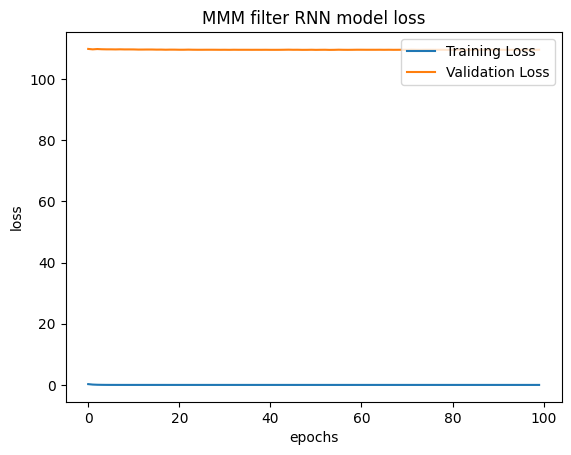

In [34]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} filter RNN model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [35]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_RNN/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_hybrid/assets


INFO:tensorflow:Assets written to: saved_model_RNN/MMM_model_hybrid/assets


In [36]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['org_akam']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="RNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************
